<a href="https://colab.research.google.com/github/Quantum-Intelligence-Frontier/dldna/blob/main/notebooks/ko/part_1/09_트랜스포머의 진화.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 9장 트랜스포머의 진화: 효율성과 확장성을 향하여

> "효율성은 지능으로 가는 다리이다." - 앨런 튜링

2017년 트랜스포머의 등장 이후 BERT와 GPT로 대표되는 거대 언어 모델들이 연이어 등장합니다. 이들은 놀라운 성능으로 인공지능의 새로운 시대를 열었습니다. 그러나 이러한 성공 이면에는 트랜스포머 아키텍처의 근본적인 한계와 이를 극복하기 위한 노력이 있었습니다. 계산 복잡도 문제와 장문 처리의 한계를 극복하기 위해 끊임없는 개선과 구조 제안이 있었습니다. 특히 2019년 이후에는 모델의 규모가 급격히 커지면서 효율성에 대한 연구가 활발히 진행되었습니다. 

**시기별 주요 변화:**

*   2019-2020: 복잡도 감소 중심
*   2021-2022: 메모리 효율성 중심
*   2023-2024: 확장성 및 특수 목적 (윤리, 개방형 모델 등) 중심

이 장에서는 트랜스포머의 한계를 살펴보고, 이를 해결하기 위한 다양한 방법들을 자세히 다룹니다.


## 9.1 트랜스포머의 한계와 도전

> **도전과제:** 어떻게 하면 트랜스포머 모델의 계산 복잡도와 메모리 사용량을 줄여, 더 긴 문맥을 처리하고, 더 큰 모델을 학습시킬 수 있을까?
>
> **연구자의 고뇌:** 트랜스포머 모델의 성능은 뛰어나지만, 그 계산 비용은 엄청났습니다. 특히 어텐션 메커니즘은 시퀀스 길이의 제곱에 비례하는 복잡도를 가졌고, 이는 모델의 확장성을 심각하게 제한했습니다. 연구자들은 어텐션의 핵심 기능을 유지하면서도 계산 효율성을 높일 수 있는 방법을 찾아야 했습니다. 단순히 모델의 크기를 줄이는 것이 아니라, 알고리즘과 하드웨어 수준에서 혁신적인 해결책을 모색해야 했습니다. 이는 마치 거대한 건물을 지으면서도, 벽돌 하나하나의 무게와 비용을 줄여야 하는 것과 같은 어려운 과제였습니다.

어텐션 연산의 이차 복잡도, 제한된 컨텍스트 길이, 메모리 효율성 문제는 모델 확장의 주요 걸림돌이었습니다. 이러한 한계는 트랜스포머 발전 방향을 결정짓는 중요한 요인이 되었습니다.

### 9.1.1 트랜스포머 아키텍처의 기본 한계: 계산 복잡도 

트랜스포머 모델 규모 확장 과정에서 어텐션 연산의 복잡도, 특히 시퀀스 길이 제곱에 비례하는 복잡도는 큰 문제였습니다.

**어텐션 연산 복잡도 분석:**

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

1.  $QK^T$ 계산: $O(N^2d)$ (d: 임베딩 차원)
2.  Softmax 연산: $O(N^2)$
3.  Softmax 결과와 V의 곱: $O(N^2d)$

이를 실제 코드로 수행속도와 메모리 사용량을 보도록 하겠습니다.

In [ ]:
!pip install dldna[colab] # in Colab
# !pip install dldna[all] # in your local

%load_ext autoreload
%autoreload 2


=== Complexity Analysis of Attention Operation ===

Memory usage and execution time by sequence length:
Length		Memory (MB)	Time (seconds)
----------------------------------------
100		18.75		0.0037
500		96.58		0.0388
1000		317.00		0.1187
2000		1119.00		0.4228
4000		4188.14		1.6553
8000		16142.53		6.5773
10000		25039.31		10.2601
15000		55868.54		25.1265


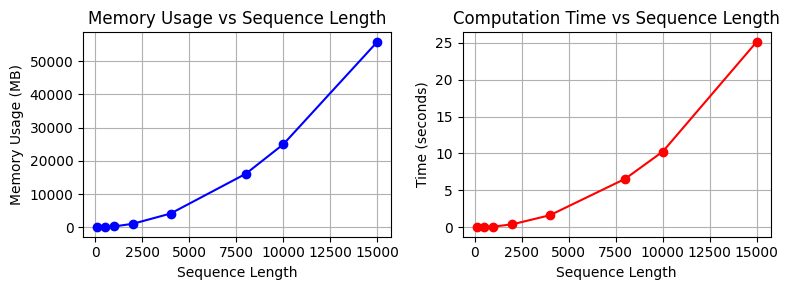

In [1]:
from dldna.chapter_09.complexity_benchmark import measure_attention_complexity, plot_complexity_analysis, measure_attention_complexity_gpu

seq_lengths = [100, 500, 1000, 2000, 4000, 8000, 10000, 15000]

results = measure_attention_complexity(seq_lengths=seq_lengths)

print("\n=== Complexity Analysis of Attention Operation ===")
print("\nMemory usage and execution time by sequence length:")
print("Length\t\tMemory (MB)\tTime (seconds)")
print("-" * 40)
for seq_len, mem, time_taken in results:
    print(f"{seq_len}\t\t{mem:.2f}\t\t{time_taken:.4f}")

# Visualize with a graph
plot_complexity_analysis(results)

실제 트랜스포머 모델에서는 이 연산이 여러 레이어에서 반복됩니다. 배치 크기 증가 시 계산량은 더욱 증가합니다.

In [2]:
# Compare theoretical complexity with actual measurements
print("\n=== Comparison of Theoretical Complexity and Actual Measurements ===")
base_seq = seq_lengths[0]
base_mem = results[0][1]
base_time = results[0][2]

print("\nTheoretical vs Actual Growth Rate (Base: First Sequence Length)")
print("Length      Theoretical(N²)      Actual Memory      Actual Time")
print("-" * 60)
for seq_len, mem, time_taken in results:
    theoretical = (seq_len/base_seq) ** 2
    actual_mem = mem/base_mem
    actual_time = time_taken/base_time
    print(f"{seq_len:6d}    {theoretical:10.2f}x    {actual_mem:10.2f}x    {actual_time:10.2f}x")


=== Comparison of Theoretical Complexity and Actual Measurements ===

Theoretical vs Actual Growth Rate (Base: First Sequence Length)
Length      Theoretical(N²)      Actual Memory      Actual Time
------------------------------------------------------------
   100          1.00x          1.00x          1.00x
   500         25.00x          5.15x          8.05x
  1000        100.00x         16.91x         32.49x
  2000        400.00x         59.71x        124.52x
  4000       1600.00x        223.34x        474.71x
  8000       6400.00x        860.92x       1882.04x
 10000      10000.00x       1335.43x       2976.84x
 15000      22500.00x       2979.67x       7280.40x



이차 복잡도는 GPT-3 같은 대규모 모델에서 특히 심각합니다. 긴 문서 처리 제한, 훈련 시 배치 크기 제한 등 많은 한계를 야기했습니다. 이는 효율적 어텐션 메커니즘 개발의 주요 동기가 되었습니다.

트랜스포머의 이차 복잡도 문제 해결을 위한 초기 시도는 크게 세 가지 방향으로 진행되었습니다.

**슬라이딩 윈도우 어텐션**

고정 크기 윈도우 내에서만 어텐션을 계산합니다.

In [ ]:
def sliding_window_attention(q, k, v, window_size):
    """Sliding window attention"""
    batch_size, seq_len, dim = q.shape
    attention_weights = np.zeros((batch_size, seq_len, seq_len))

    for i in range(seq_len):
        start = max(0, i - window_size // 2)
        end = min(seq_len, i + window_size // 2 + 1)
        scores = np.matmul(q[:, i:i+1], k[:, start:end].transpose(0, 2, 1))
        attention_weights[:, i, start:end] = softmax(scores, axis=-1)

    return np.matmul(attention_weights, v)

이 방식은 복잡도를  $O(N \cdot w)$ 로 줄입니다. (w: 윈도우 크기)

**희소 어텐션 패턴**

희소 어텐션 패턴은 모든 토큰 쌍의 관계를 계산하는 대신, 특정 패턴에 따라 일부 관계만을 계산하는 방식입니다. 예를 들어 10개 토큰으로 구성된 시퀀스가 있을 때, 일반 어텐션은 100개(10×10)의 모든 관계를 계산하지만, 희소 어텐션은 이 중 일부만 계산합니다.

In [ ]:
def sparse_block_attention(q, k, v, block_size):
    """Block sparse attention
    Example: seq_len=8, block_size=2
    Process the sequence in 4 blocks of 2 tokens each
    Block 1 (0,1), Block 2 (2,3), Block 3 (4,5), Block 4 (6,7)
    """
    batch_size, seq_len, dim = q.shape  # e.g., (1, 8, 64)
    num_blocks = seq_len // block_size  # e.g., 8/2 = 4 blocks
    attention_weights = np.zeros((batch_size, seq_len, seq_len))
    
    for i in range(num_blocks):
        # e.g., when i=0, process Block 1 (0,1)
        start_q = i * block_size  # 0
        end_q = (i + 1) * block_size  # 2
        
        for j in range(num_blocks):
            # e.g., when j=0, attention with Block 1 (0,1)
            start_k = j * block_size  # 0
            end_k = (j + 1) * block_size  # 2
            
            # Calculate attention between tokens in Block 1 (0,1) and Block 1 tokens (0,1)
            scores = np.matmul(
                q[:, start_q:end_q],  # (1, 2, 64)
                k[:, start_k:end_k].transpose(0, 2, 1)  # (1, 64, 2)
            )  # Result: (1, 2, 2)
            
            # Store weights block by block
            attention_weights[:, start_q:end_q, start_k:end_k] = softmax(scores, axis=-1)
    
    # Generate the final context vectors
    return np.matmul(attention_weights, v)

**저순위 근사화**

저순위 근사화는 큰 행렬을 더 작은 행렬들의 곱으로 표현하는 방식입니다. 예를 들어 10개 토큰인 문장에서 일반 어텐션은 10×10=100개의 관계를 계산하나 저순위 근사화는 10×4와 4×10 두 행렬의 곱으로 표현 (rank=4) 합니다. 따라서 100개 대신 80개의 연산만으로 비슷한 결과를 얻게 됩니다.

In [4]:
def low_rank_attention(q, k, v, rank):
    """Low-rank attention
    Example: seq_len=10, dim=64, rank=16
    Project Q, K from 64 dimensions to 16 dimensions to reduce computation
    """
    batch_size, seq_len, dim = q.shape  # e.g., (1, 10, 64)
    
    # Create projection matrices to project from 64 dimensions to 16 dimensions
    projection_q = np.random.randn(dim, rank) / np.sqrt(rank)  # (64, 16)
    projection_k = np.random.randn(dim, rank) / np.sqrt(rank)
    
    # Project Q, K to 16 dimensions
    q_low = np.matmul(q, projection_q)  # (1, 10, 16)
    k_low = np.matmul(k, projection_k)  # (1, 10, 16)
    
    # Calculate attention in the lower dimension (operations on 10x16 matrices)
    attention = np.matmul(q_low, k_low.transpose(0, 2, 1))  # (1, 10, 10)
    attention_weights = softmax(attention, axis=-1)
    
    # Generate the final context vectors
    return np.matmul(attention_weights, v)  # (1, 10, 64)

이 방식은 복잡도를 $O(N \cdot r)$로 줄일 수 있었습니다. 여기서 r은 근사화에 사용된 순위입니다. 각 방식의 효율을 계산해 보겠습니다.

In [2]:
from dldna.chapter_09.attention_complexity_examples import calcualte_efficieny
calcualte_efficieny()

Original input shape: (2, 8, 4)

1. Sliding Window Attention
Output shape: (2, 8, 4)
Output of the first batch, first token: [-0.78236164  0.22592055 -1.03027549  1.13998368]

2. Block Sparse Attention
Output shape: (2, 8, 4)
Output of the first batch, first token: [-1.66095776  0.76700744 -0.45857165 -0.77422867]

3. Low-Rank Attention
Output shape: (2, 8, 4)
Output of the first batch, first token: [ 0.51121005  0.66772692 -0.77623488 -0.0323534 ]

Memory Usage Comparison (Relative Size):
Full Attention: 64
Sliding Window: 32
Block Sparse: 64
Low Rank: 32



그러나 초기 시도들은 정보 손실, 구현 복잡성, 성능 저하 등의 한계를 보였습니다. Google은 저순위 근사화에, Microsoft는 희소 패턴 개발에 더 집중했습니다. 이후 이러한 초기 접근들은 하이브리드 방식으로 발전하여 희소성과 저순위 특성을 모두 활용하는 방향으로 진화했습니다.

### 9.1.2 트랜스포머 아키텍처의 기본 한계: 메모리 효율성

또 다른 중요한 한계는 메모리 효율성입니다. 특히 대규모 언어 모델에서는 다음과 같은 메모리 부담이 있습니다.

첫째, KV 캐시로 인한 메모리 부담입니다. 자기회귀적 생성 과정에서 이전 타임스텝의 Key와 Value 값을 저장해야 하는데, 이는 시퀀스 길이에 비례하여 선형적으로 증가합니다. 예를 들어 GPT-3의 경우 2048 토큰을 처리할 때 각 레이어마다 약 16MB의 KV 캐시가 필요합니다.
둘째, 역전파 과정의 메모리 요구사항입니다. 트랜스포머는 각 어텐션 레이어의 중간 활성화 값(activation value) - 어텐션 레이어에서 발생하는 중간 계산 결과들(Q, K, V 변환값, 어텐션 스코어, 소프트맥스 출력 등) - 을 저장합니다. 이는 레이어 수가 증가할수록 이 부담이 급격히 커집니다. BERT-large의 경우 단일 배치에서도 약 24GB의 메모리가 필요했습니다.
셋째, 어텐션 연산 자체의 메모리 사용량입니다. 어텐션 스코어 행렬은 시퀀스 길이의 제곱에 비례하는 크기를 가지며, 이는 긴 문서를 처리할 때 심각한 병목이 됩니다.

이러한 메모리 문제를 해결하기 위해 그래디언트 체크포인팅, 혼합 정밀도 훈련, FlashAttention과 같은 최적화 기법들이 제안되었습니다. 


### 9.1.3 트랜스포머 발전의 시대적 흐름과 본 장의 구성

9.1.1절과 9.1.2절에서 살펴본 트랜스포머의 계산 복잡도 및 메모리 효율성 한계를 극복하기 위해, 연구자들은 효율성과 확장성을 향상시키는 다양한 기술들을 개발해 왔습니다. 이러한 기술들은 트랜스포머 모델을 더욱 강력하고 실용적으로 만들었으며, 딥러닝 분야 전반에 큰 영향을 미치고 있습니다.

본 장에서는 다음 표와 같이 트랜스포머 발전의 시대적 흐름을 개괄하고, 각 시기별 주요 기술 및 모델을 소개합니다.

**표: 트랜스포머 발전의 시대적 흐름, 주요 모델/기술, 핵심 내용, 딥러닝 DNA**

| 섹션    | 시기 (대략) | 주요 모델/기술       | 핵심 내용 및 설명         | 딥러닝 DNA       |
|---------|-------------|------------------------|-------------------------|-----------------------------------------------|
| **9.1** | 2017-2018   | Transformer                                     | 기존 RNN, CNN의 한계를 극복한 Attention 메커니즘 도입.<br>Sequence-to-sequence 모델의 혁신 | **Attention 메커니즘**: 데이터의 중요한 부분에 집중하는 새로운 방법 제시         |
| **9.2** | 2019-2020   | Performer, Sparse Transformer, Longformer <br>  Reformer, BigBird    | **계산 복잡도 감소**를 위한 소프트웨어적 접근.<br>**선형 어텐션**: 어텐션 연산 근사화 (Performer).<br>**희소 어텐션**: 일부 토큰 쌍에만 어텐션 적용 (Sparse Transformer, Longformer).<br>**로컬-글로벌 어텐션**: 지역 정보와 전역 정보 결합 (Reformer, BigBird) | **효율적인 Attention**: 계산 복잡도를 줄이면서 Attention의 장점을 유지하려는 노력.<br>**장거리 의존성**: 긴 문맥을 효과적으로 처리하기 위한 구조 개선 |
| **9.3** | 2021-2022   | FlashAttention, MQA, GQA, PagedAttention, vLLM  | **메모리 효율성 개선**을 위한 하드웨어 및 소프트웨어적 접근.<br>**FlashAttention**: GPU 메모리 계층 구조 활용, 타일링, 블록 처리.<br>**MQA/GQA**: 쿼리 최적화, Key/Value 공유.<br>**KV 캐시 최적화**: PagedAttention, vLLM | **하드웨어 최적화**: GPU 메모리 구조를 고려한 효율적인 연산 방법.<br>**병렬 처리**: 쿼리 공유를 통한 연산 효율성 증대 |
| **9.4** | 2022-2023   | Claude-2, LongLoRA, Constitutional AI, RLHF, <br>RLAIF, 계층적 어텐션, Recurrent Memory    | **확장성 및 특수 목적** 아키텍처.<br>**Long Context**: 계층적 어텐션, Recurrent Memory Transformer.<br>**윤리/안전**: 규칙 기반 어텐션, 강화학습 기반 조정 | **Long Context**: 더 긴 문맥을 처리하기 위한 모델 구조의 진화.<br>**Fine-tuning**: 특정 목적에 맞게 모델을 조정하는 방법 |
| **9.5**| 2022-2023     | Efficient Encoder (FlashAttention 기반)       | 텍스트 분류 (AG News), FlashAttention, Pre-LN, Gradient Checkpointing, Mixed Precision Training   | **구현:** 효율적인 인코더 활용                                                     |
| **9.6**| 2023       | Mistral, Efficient Decoder (GQA, Sliding Window Attention 기반) | Mistral 모델 분석: GQA, Sliding Window Attention, RoPE, KV 캐시 등. <br> 응용 예제: 숫자-텍스트 변환, 자연어-SQL 변환 (코드 생성), 텍스트-코드 생성.  | **구현:** 효율적인 디코더 아키텍쳐   |
| **9.7**| 2024       | Gemma    | 효율성과 접근성을 위한 개방형 모델      | **개방형 모델**: 연구 및 개발 접근성 향상             |
| **9.8**  | 2024      |  Phi-3  | 작지만 효율적인 LLM     | **구현:** 강력한 SLM(Small Language Model)    |


본 장의 구성은 다음과 같습니다.

*   **9.2절:** 어텐션 연산의 계산 복잡도를 줄이기 위한 소프트웨어적 접근 방식 (근사화, 희소화, 로컬-글로벌 어텐션)을 다룹니다.
*   **9.3절:** 메모리 효율성을 개선하기 위한 하드웨어 및 소프트웨어적 접근 방식 (FlashAttention, 쿼리 최적화, KV 캐시 관리)을 살펴봅니다.
*   **9.4절:** 모델의 확장성과 특수 목적 아키텍처 (Long Context 처리, 윤리적/안전 제약)에 대해 논의합니다.
*   **9.5절:** 효율적인 인코더 모델을 구현하고, AG news 분류 예제로 다른 유사한 모델과 효율성을 비교합니다. 
*   **9.6절:** 효율적인 디코더 모델인 간단한 Mistral 모델을 구현하고, 응용 예제를 제시합니다.
*   **9.7절:** 개방형 모델의 대표인 gemma를 소개합니다. 
*   **9.8절:** 강력한 SLM 모델인 phi-3의 간단한 모델을 구현하고, 응용 예제를 살펴봅니다.  

## 9.2 복잡도 감소: 소프트웨어적 어텐션 최적화 (2019-2020)

### 9.2.1 초기 접근법: 근사화와 희소화

2019년부터 2020년까지는 트랜스포머의 계산 복잡도를 줄이기 위한 다양한 시도가 이루어졌습니다. 특히 Google Research와 DeepMind가 주도한 이 시기의 발전은 어텐션 연산의 효율성을 크게 개선했습니다.

#### 9.2.1.1 선형 어텐션: Performer

2020년 초 Google Research 팀은 FAVOR+(Fast Attention Via positive Orthogonal Random features)를 통해 어텐션의 복잡도를 O(N²)에서 O(N)으로 줄이는 데 성공합니다. FAVOR+는 Performer 모델의 핵심 메커니즘으로, 긴 시퀀스 처리를 실용적으로 가능하게 만든 첫 번째 방법이었습니다.

FAVOR+의 핵심 아이디어는 **커널 트릭**에서 시작됩니다. 커널 트릭은 소프트맥스 어텐션을 다음과 같이 재해석합니다.

$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d}})V$

이를 양의 값을 갖는 커널 함수 φ(x)를 사용하여 다음과 같이 근사할 수 있습니다.

$Attention(Q,K,V) ≈ \frac{\phi(Q)\phi(K)^TV}{\phi(Q)\phi(K)^T\mathbf{1}}$

핵심은 소프트맥스 어텐션을 분수 형태로 재해석하고, 커널 함수 φ(x)를 사용하여 행렬 곱셈의 순서를 재배열할 수 있게 만든 것입니다. 마치 $(a \times b) \times c$ 를 $a \times (b \times c)$ 로 바꾸는 것과 유사합니다.

In [3]:
import numpy as np

def kernel_attention(Q, K, V, feature_dim=256): # Q: (seq_len, d_model) K: (seq_len, d_model) V: (seq_len, d_model)
    
    # 1. Generate random projection matrix
    projection = np.random.randn(Q.shape[-1], feature_dim) / np.sqrt(feature_dim)  
    # projection: (d_model, feature_dim)
    
    # 2. Project Q, K to lower dimension and apply ReLU
    Q_mapped = np.maximum(0, np.dot(Q, projection))  # phi(Q)
    # Q_mapped: (seq_len, feature_dim)
    K_mapped = np.maximum(0, np.dot(K, projection))  # phi(K)
    # K_mapped: (seq_len, feature_dim)
    
    # 3. Calculate numerator: phi(Q)phi(K)^TV
    KV = np.dot(K_mapped.T, V)  # (feature_dim, V_dim)
    # KV: (feature_dim, d_model)
    numerator = np.dot(Q_mapped, KV)  # (seq_len, V_dim)
    # numerator: (seq_len, d_model)
    
    # 4. Calculate denominator: phi(Q)phi(K)^T1
    K_sum = np.sum(K_mapped, axis=0, keepdims=True)  # (1, feature_dim)
    # K_sum: (1, feature_dim)
    denominator = np.dot(Q_mapped, K_sum.T)  # (seq_len, 1)
    # denominator: (seq_len, 1)
    
    # 5. Final attention output
    attention_output = numerator / (denominator + 1e-6)
    # attention_output: (seq_len, d_model)
    
    return attention_output

# Example usage
seq_len, d_model = 1000, 64
Q = np.random.randn(seq_len, d_model)
K = np.random.randn(seq_len, d_model)
V = np.random.randn(seq_len, d_model)

# Calculate attention with O(N) complexity
output = kernel_attention(Q, K, V)

print(output)

[[-0.00705502 -0.01553617 -0.01976792 ... -0.00906909  0.02983678
   0.0424082 ]
 [-0.00201811 -0.01741265 -0.00458378 ... -0.02578894  0.04247468
   0.03793401]
 [-0.01130314 -0.02011524 -0.00962334 ... -0.01348429  0.04382548
   0.01967338]
 ...
 [ 0.00180466 -0.01818735 -0.02244794 ... -0.01978542  0.03202302
   0.03887265]
 [-0.00421543 -0.01679868 -0.00537492 ... -0.00314385  0.05363415
   0.03304721]
 [ 0.00107896 -0.02042812 -0.01947976 ... -0.00557582  0.04534007
   0.04408479]]


FAVOR+가 도입한 세 가지 핵심 변화는 다음입니다.

1.  **무편향 추정:** 정규직교 랜덤 특징을 사용하여 어텐션 값을 계산할 때, 근사된 값의 평균이 실제 어텐션 값과 일치하도록 만듭니다.
2.  **양수 특징:** ReLU 활성화 함수를 사용하여 모든 특징 값을 양수로 만듭니다. 이는 수치적 안정성을 높입니다.
3.  **정규직교 투영:** 정규직교 행렬을 사용하여 입력을 저차원 공간으로 투영합니다. 이는 벡터 간의 거리와 각도를 최대한 보존하여 근사 오차를 최소화합니다.

FAVOR+의 처리 단계는 다음과 같습니다.

1.  **데이터 변환과 차원 축소:** 입력 데이터(Q, K, V)를 더 작은 차원의 정규직교 특징 공간으로 변환합니다.
    *   정규직교 특징 공간으로 투영: 각 입력 벡터가 서로 독립적이면서도 균형 잡힌 형태로 변환됩니다.
    *   차원 감소: 고차원 입력을 저차원으로 압축합니다.
    *   정보 보존: 중요한 관계 정보는 유지하면서 차원을 감소시킵니다.
    *   차원 변화: (시퀀스 길이 × 임베딩 차원) → (시퀀스 길이 × 특징 차원)

2.  **선형 어텐션 연산:** 변환된 특징 공간에서 효율적으로 어텐션을 계산합니다.
    *   특징 공간에서의 연산: 투영된 벡터들 간의 유사도를 계산합니다.
    *   메모리 효율성: 시퀀스 길이에 비례하는 선형적 메모리 사용 (O(N × d), N: 시퀀스 길이, d: 특징 차원).
    *   계산 최적화: 행렬 곱셈 순서 재배열을 통해 복잡도를 O(N × d)로 감소시킵니다 (기존 O(N²)).

In [4]:
import numpy as np

def favor_plus_attention(q, k, v, feature_dim=256):
    """FAVOR+ attention implementation
    Args:
        q: Query tensor (batch_size, seq_len, d_model)
        k: Key tensor (batch_size, seq_len, d_model)
        v: Value tensor (batch_size, seq_len, d_model)
        feature_dim: The number of dimensions of the low-dimensional feature space
    """
    d_model = q.shape[-1]
    
    # 1. Generate an orthonormal random projection matrix
    random_matrix = np.random.randn(d_model, feature_dim)
    q_orth, _ = np.linalg.qr(random_matrix)
    projection = q_orth / np.sqrt(feature_dim)  # (d_model, feature_dim)

    # 2. Project Q, K to the low-dimensional feature space and apply ReLU
    q_prime = np.maximum(0, np.matmul(q, projection))  # (batch_size, seq_len, feature_dim)
    k_prime = np.maximum(0, np.matmul(k, projection))  # (batch_size, seq_len, feature_dim)

    # 3. Calculate linear-time attention
    # Use einsum to perform matrix multiplication while maintaining the batch dimension
    kv = np.einsum('bsf,bsd->bfd', k_prime, v)  # (batch_size, feature_dim, d_model)
    
    # Calculate the numerator
    numerator = np.einsum('bsf,bfd->bsd', q_prime, kv)  # (batch_size, seq_len, d_model)

    # Calculate the denominator (normalization term)
    k_sum = np.sum(k_prime, axis=1, keepdims=True)  # (batch_size, 1, feature_dim)
    denominator = np.einsum('bsf,bof->bso', q_prime, k_sum)  # (batch_size, seq_len, 1)

    # 4. Calculate the final attention output
    attention_output = numerator / (denominator + 1e-6)  # (batch_size, seq_len, d_model)

    return attention_output

# Example usage
batch_size, seq_len, d_model = 2, 100, 512
q = np.random.randn(batch_size, seq_len, d_model)
k = np.random.randn(batch_size, seq_len, d_model)
v = np.random.randn(batch_size, seq_len, d_model)

output = favor_plus_attention(q, k, v)
print("Output tensor shape:", output.shape)

Output tensor shape: (2, 100, 512)


FAVOR+는 다음과 같은 이점이 있습니다.

1.  계산 복잡도를 O(N²)에서 O(N)으로 감소시킵니다.
2.  메모리 사용량을 줄이면서도 어텐션의 핵심 기능인 토큰 간 관계 포착 능력을 유지합니다.
3.  긴 시퀀스 처리가 실용적으로 가능해집니다.

**수학적 기반**

FAVOR+의 수학적 기반은 **Johnson-Lindenstrauss 보조정리**에 있습니다.  핵심은 고차원 데이터를 저차원으로 투영해도 데이터 간의 거리 관계가 *거의* 유지된다는 것입니다.  즉, 1000차원 데이터를 100차원으로 줄여도 데이터 간 상대적 거리는 크게 변하지 않습니다.

FAVOR+의 성공은 이후 Linear Transformer, Linear Attention Transformer 등 다양한 선형 어텐션의 발전을 이끌었으며, 특히 긴 시퀀스 처리에서 중요한 역할을 했습니다.

#### 9.2.1.2 희소 어텐션: Sparse Transformer, Longformer

2019년 OpenAI는 Sparse Transformer를 통해 **고정된 희소 패턴**을 도입했습니다. 이는 모든 토큰 쌍의 관계를 계산하는 대신, 특정 패턴에 따라 일부 관계만 계산하는 방법입니다.

**Sparse Transformer의 고정 패턴**

Sparse Transformer는 두 가지 주요 희소 패턴을 사용합니다.

1.  **스트라이드 패턴:** 일정 간격으로 떨어진 토큰들과만 어텐션을 계산합니다.
2.  **로컬 패턴:** 인접한 고정 크기 윈도우 내의 토큰들과만 어텐션을 계산합니다.

이러한 패턴은 다음과 같은 수학적 표현으로 나타낼 수 있습니다.

$Attention(Q,K,V) = softmax(\frac{QK^T \odot M}{\sqrt{d_k}})V$

여기서 M은 희소 마스크 행렬이며, ⊙는 요소별 곱셈을 나타냅니다.  마스크 행렬은 어떤 토큰 쌍에 어텐션을 적용할지 (1) 또는 적용하지 않을지 (0)를 나타냅니다.

이 방식은 계산 효율성을 높였지만, 패턴이 고정되어 문맥에 따라 유연하게 대응하기 어렵다는 단점이 있었습니다.

**Longformer의 지역-전역 결합**

2020년 Allen AI는 Longformer를 통해 더 유연한 희소 패턴을 제안했습니다. Longformer는 **지역적 어텐션**과 **전역적 어텐션**을 결합한 하이브리드 접근법을 사용합니다.

1.  **지역적 어텐션:** 모든 토큰이 주변 w개의 토큰과 어텐션을 계산합니다. (슬라이딩 윈도우 방식)
2.  **전역적 어텐션:** 특별한 토큰(예: \[CLS])은 모든 토큰과 어텐션을 계산합니다.

이 방식은 지역적 문맥과 전역적 문맥을 동시에 고려하여 더 풍부한 문맥 이해를 가능하게 합니다.

In [5]:
import numpy as np


def longformer_attention(q, k, v, window_size=3, global_tokens=[0]):
    """Longformer attention implementation
    Args:
        q, k, v: (batch_size, seq_len, d_model)
        window_size: Size of the local attention window
        global_tokens: List of token indices to perform global attention on
    """
    batch_size, seq_len, d_model = q.shape
    attention_weights = np.zeros((batch_size, seq_len, seq_len))

    # 1. Local attention: sliding window
    for i in range(seq_len):
        # Calculate window range
        window_start = max(0, i - window_size)
        window_end = min(seq_len, i + window_size + 1)
        window_size_current = window_end - window_start
        
        # Calculate attention scores within the window
        scores = np.matmul(q[:, i:i+1], k[:, window_start:window_end].transpose(0, 2, 1))
        # scores: (batch_size, 1, window_size_current)
        
        attention_weights[:, i:i+1, window_start:window_end] = scores

    # 2. Global attention: specific tokens attend to all tokens
    for global_idx in global_tokens:
        # Calculate attention scores for global tokens
        scores = np.matmul(q[:, global_idx:global_idx+1], k.transpose(0, 2, 1))
        # scores: (batch_size, 1, seq_len)
        
        attention_weights[:, global_idx:global_idx+1, :] = scores
        attention_weights[:, :, global_idx:global_idx+1] = scores.transpose(0, 2, 1)

    # 3. Apply softmax (row-wise)
    attention_weights = np.exp(attention_weights) / np.sum(np.exp(attention_weights), axis=-1, keepdims=True)
    
    # 4. Calculate the final output by applying weights
    output = np.matmul(attention_weights, v)  # (batch_size, seq_len, d_model)
    
    return output

# Example usage
batch_size, seq_len, d_model = 2, 10, 64
q = np.random.randn(batch_size, seq_len, d_model)
k = np.random.randn(batch_size, seq_len, d_model)
v = np.random.randn(batch_size, seq_len, d_model)

output = longformer_attention(q, k, v, window_size=2, global_tokens=[0])

print(output)

[[[-0.72195324  0.03196266 -0.06067346 ...  0.57106283  1.31438
    0.63673636]
  [-1.72619367 -0.39122625  0.91285828 ... -1.4031466   1.2081069
    0.95934394]
  [ 0.07427921  0.42596224 -0.44545069 ...  0.154228    0.37435003
   -0.01884786]
  ...
  [ 1.26169539 -0.58215291  2.00334263 ...  1.15338425  0.31404728
   -1.33672458]
  [ 0.96005607  0.39904084  0.5703471  ... -0.2168805   0.93570179
    0.05680507]
  [ 0.61648602 -0.12874142  1.09736967 ...  0.32421211  1.23082505
    0.4141766 ]]

 [[ 0.92762851  0.26334678 -0.81047846 ... -0.19186621  0.42534117
    0.57313974]
  [ 1.01307261  0.61571205 -1.26925081 ... -0.56016688 -0.19707427
    2.49452497]
  [-1.0071559   2.81291178  2.5010486  ...  1.63559632 -0.60892113
   -1.40952186]
  ...
  [-1.96615634  1.85881047  0.19361453 ...  1.21044747 -0.00772792
   -0.68961122]
  [ 0.09090778  1.94770672 -0.990489   ... -0.09841141  0.65195305
    0.11634795]
  [-2.43256801  1.66319642  0.23557316 ...  2.39325846  0.8750332
    0.66295

**블록 희소 행렬 연산 최적화**

Longformer의 하이브리드 접근을 효율적으로 구현하려면 블록 희소 행렬 연산 최적화가 필요합니다.

1.  **블록 단위 처리:** 연속된 메모리 접근을 통해 캐시 효율성을 높입니다.
2.  **커스텀 CUDA 커널:** 희소 패턴에 특화된 병렬 처리를 최적화합니다.
3.  **동적 로드 밸런싱:** 블록별 계산량을 고려하여 작업을 분배합니다.

희소 패턴 기반 접근법은 복잡도를 O(N log N) 또는 O(N)으로 줄였지만, 구현 복잡성과 하드웨어 최적화의 어려움이 있었습니다.

### 9.2.3 로컬-글로벌 어텐션: 장거리 의존성 문제 해결

2020년 초, Google Research와 Allen AI는 로컬-글로벌 어텐션을 결합한 하이브리드 접근법을 제안했습니다. 이는 선형 어텐션의 정보 손실과 희소 패턴의 구현 복잡성을 해결하기 위한 시도였습니다.

#### 9.2.3.1 Reformer: LSH 어텐션

Reformer는 **국소성 민감 해싱(Locality-Sensitive Hashing, LSH)** 을 사용하여 유사한 벡터들을 효율적으로 군집화합니다. LSH의 핵심 원리는 다음과 같습니다.

$h(x) = \text{argmax}( [xR; -xR] )$

여기서 R은 무작위 투영 행렬이며, 유사한 벡터는 같은 해시값을 가질 확률이 높습니다.  Reformer는 다음 단계를 따릅니다.

1.  쿼리 벡터들을 해시 함수를 사용하여 버킷에 할당합니다.
2.  같은 버킷 내의 키 벡터들과만 어텐션을 계산합니다.
3.  복잡도를 O(N²)에서 O(N log N)으로 줄입니다.

이 방식은 긴 시퀀스 처리에 효율적이지만, 해시 충돌로 인한 정보 손실 가능성이 있습니다.

#### 9.2.3.2 BigBird: 로컬, 글로벌, 랜덤 어텐션의 조합

BigBird는 Reformer의 한계를 보완하기 위해 세 가지 어텐션 패턴을 결합했습니다.

1.  **로컬 윈도우:** w개의 인접 토큰과 어텐션을 계산하여 지역적 문맥을 포착합니다.
2.  **글로벌 토큰:** g개의 특별 토큰이 전체 시퀀스와 어텐션하여 전역적 정보를 유지합니다.
3.  **랜덤 블록:** r개의 무작위3. **랜덤 블록:** r개의 무작위 토큰과 어텐션 계산으로 다양한 거리의 관계를 포착합니다.

이러한 혼합 전략은 다음과 같은 수식으로 표현됩니다.

$Attention(Q,K,V) = softmax(\frac{QK^T \odot (M_{local} + M_{global} + M_{random})}{\sqrt{d_k}})V$

여기서 M은 각각의 마스크 행렬입니다. 이 구조는 O(N) 복잡도를 달성하면서도 BERT 수준의 성능을 유지했습니다.

**하이브리드 패턴의 영향**

BigBird의 성공은 로컬-글로벌 접근법이 가진 잠재력을 입증했고, 이는 현대 트랜스포머 모델에 큰 영향을 미쳤습니다.

1.  **계산 효율성:**
    *   선택적 어텐션으로 복잡도를 감소시켰습니다.
    *   GPU 메모리 사용량을 최적화했습니다.
    *   병렬 처리가 가능해졌습니다.

2.  **모델 성능:**
    *   지역적 세부 정보와 전역적 문맥 정보의 균형을 맞췄습니다.
    *   장거리 의존성 포착 능력이 향상되었습니다.
    *   다양한 태스크에서 안정적인 성능을 보였습니다.

3.  **실제 응용:**
    *   GPT-3의 Sparse Transformer 구조에 영향을 주었습니다.
    *   PaLM의 멀티쿼리 어텐션 발전에 기여했습니다.
    *   Anthropic Claude의 Constitutional AI 구현에 활용되었습니다.

이러한 하이브리드 접근법은 이후 Longformer, ETC 등 다양한 모델의 기반이 되었습니다. 특히 문서 분류, 질의응답과 같은 긴 문서 처리 태스크에서 큰 성공을 거두었습니다. 그러나 여전히 메모리 사용량과 계산 효율성의 문제가 남아있었습니다. 특히 대규모 언어 모델에서 GPU 메모리 사용 최적화가 새로운 과제로 대두되었고, 이는 9.3장에서 다룰 메모리 효율성 개선으로 이어집니다.


## 9.3 메모리 효율성: 하드웨어와 소프트웨어의 결합 (2021-2022)

2021년부터 2022년까지는 트랜스포머의 메모리 효율성 향상에 초점이 맞춰졌습니다. 특히 GPU 메모리 계층 구조를 고려한 최적화와 어텐션 연산의 효율적 구현이 주목받았습니다. 이 시기의 방법들은 대규모 언어 모델의 실용적 구현을 가능하게 했습니다.

### 9.3.1 FlashAttention: GPU 메모리 계층 구조를 활용한 어텐션 최적화

2022년 스탠포드 대학의 Tri Dao 연구팀은 GPU 메모리 계층 구조를 고려한 FlashAttention을 제안했습니다. 이는 어텐션 연산의 메모리 접근 패턴을 근본적으로 재설계한 하드웨어 중심의 개선이었습니다. FlashAttention은 트랜스포머 모델, 특히 긴 시퀀스를 처리하는 모델의 학습 및 추론 속도를 획기적으로 개선하여 대규모 언어 모델 발전에 크게 기여했습니다. 2023년 발표된 FlashAttention v2는 원본 FlashAttention을 더욱 최적화하여 2-4배 더 빠른 속도를 달성했습니다.

#### 9.3.1.1 GPU 메모리 구조와 IO 최적화

FlashAttention의 장점은 GPU의 메모리 계층 구조를 명시적으로 고려했다는 점입니다. GPU에는 크지만 느린 HBM(High Bandwidth Memory)과 작지만 빠른 SRAM이라는 두 종류의 메모리가 있습니다. HBM은 용량이 크지만 접근 속도가 느리고, SRAM은 용량이 작지만 접근 속도가 매우 빠릅니다. FlashAttention은 이 특성을 활용합니다.

1.  **HBM과 SRAM 간의 데이터 이동 최소화:** 기존 어텐션 메커니즘에서는 쿼리와 키의 내적을 계산한 후, 큰 어텐션 스코어 행렬 전체를 HBM에 저장해야 했습니다. 이는 상당한 메모리 대역폭을 소모하고 속도 저하의 원인이 됩니다. FlashAttention은 이러한 불필요한 데이터 이동을 최소화합니다.
2.  **대규모 중간 결과(어텐션 스코어 행렬)를 HBM에 저장하지 않음:** FlashAttention은 중간 계산 결과를 HBM에 저장하는 대신, SRAM에 유지하면서 필요한 연산을 수행합니다.
3.  **SRAM에서 소프트맥스를 점진적으로 계산:** 전체 어텐션 스코어 행렬에 대해 한 번에 소프트맥스 연산을 수행하는 대신, 블록 단위로 소프트맥스를 계산하고 결과를 누적하는 방식을 사용합니다. 이를 통해 중간 결과값을 HBM에 저장하고 다시 읽어오는 과정을 줄일 수 있습니다.

이러한 하드웨어 인식 설계는 메모리 접근을 큰 폭으로 줄였습니다.

#### 9.3.1.2 타일링과 블록 처리

메모리 최적화를 실현하기 위해 타일링(Tiling) 기법을 도입했습니다. 타일링은 큰 행렬을 SRAM에 맞는 작은 블록으로 나누어 처리하는 하드웨어 최적화 기법입니다.

1.  입력 행렬(Q, K, V)을 SRAM 크기에 맞는 블록으로 분할
2.  블록 단위로 HBM에서 SRAM으로 데이터 로드
3.  SRAM 내에서 블록 단위 어텐션 연산 수행
4.  각 블록에 대한 어텐션 연산이 완료되면, 해당 블록의 결과 (즉, 블록의 밸류 값에 대한 가중 평균)만 HBM에 저장. 전체 어텐션 스코어는 저장하지 않습니다.

이러한 블록 처리 전략은 메모리 대역폭 사용을 최소화하면서도 정확한 어텐션 결과를 계산할 수 있게 했습니다.

#### 9.3.1.3 FlashAttention v2: 하드웨어 활용 극대화

FlashAttention v2는 v1의 기본 아이디어를 유지하면서도 하드웨어 활용도를 극대화하기 위해 여러 저수준 최적화를 추가했습니다. v1에 비해 2-4배의 속도 향상을 달성했으며, 특히 긴 시퀀스 처리에서 더욱 뛰어난 성능을 보였습니다.

*   **커널 퓨전:** FlashAttention v2는 쿼리, 키, 밸류 변환, 어텐션 스코어 계산, 소프트맥스, 가중 평균 계산 등 어텐션 메커니즘의 여러 연산을 하나의 CUDA 커널로 통합했습니다. 이를 통해 중간 결과를 HBM에 저장하고 다시 읽어오는 횟수를 최소화하여 메모리 대역폭 사용량을 줄이고 속도를 향상시켰습니다.
*   **비순차적(Non-sequential) Attention Head 처리**: 이전에는 attention head를 순차적으로 처리했다면, FlashAttention V2에서는 GPU 리소스가 허락하는 한, attention head들을 병렬적으로 처리하여 지연시간을 줄입니다.
*   **캐시 친화적 메모리 레이아웃:** 데이터를 열 우선(column-major) 순서로 저장하는 등 GPU 캐시 라인에 더 잘 맞는 데이터 구조를 설계했습니다. 이를 통해 캐시 미스(cache miss)를 줄이고 데이터 접근 속도를 높였습니다.
*   **워프 레벨 병렬화:** CUDA 워프 내의 32개 스레드를 사용하여 어텐션 연산의 각 부분을 최대한 병렬로 처리하도록 최적화했습니다. 이를 통해 GPU의 SIMD(Single Instruction, Multiple Data) 특성과 병렬 처리 능력을 최대한 활용하여 계산 속도를 높였습니다.

이러한 종합적인 최적화를 통해 FlashAttention v2는 특정 환경에서 기존 PyTorch 어텐션 구현 대비 최대 20배의 메모리 효율성 개선과 2-4배의 속도 향상을 달성했습니다. FlashAttention의 성공은 하드웨어 특성에 대한 깊은 이해를 바탕으로 한 알고리즘 설계의 중요성을 보여주었으며, 이후 GPT-4, Claude 등 대규모 언어 모델의 핵심 기술이 되었습니다.

FlashAttention의 공식 구현은 NVIDIA CUDA 코드로 제공됩니다. PyTorch에서는 flash-attn 패키지를 통해 사용할 수 있으며, 허깅페이스 transformers 라이브러리의 최신 버전에도 통합되어 있습니다.


### 9.3.2 쿼리 최적화: 어텐션 구조 개선 

2022년 Google Research는 PaLM 모델을 통해 소프트웨어 설계 측면에서 메모리 효율성을 개선하는 Multi-Query Attention(MQA)을 제안했습니다. 이는 FlashAttention의 하드웨어 중심 최적화와는 달리, 어텐션 구조 자체를 재설계하여 메모리 사용을 줄이는 접근법입니다.

#### 9.3.2.1 Multi-Query Attention (MQA)

MQA의 핵심은 모든 어텐션 헤드가 동일한 Key와 Value를 공유하도록 설계를 변경한 것입니다.

1.  **Key, Value 공유:**
    *   모든 헤드가 하나의 K, V 행렬을 공유합니다.
    *   KV 캐시 크기를 헤드 수만큼 줄입니다. (예: 헤드가 8개면 KV 캐시 크기가 1/8로 감소)
    *   메모리 대역폭 사용량이 크게 감소합니다.

2.  **Query 분리:**
    *   Query는 헤드별로 독립적으로 생성됩니다.
    *   각 헤드는 여전히 서로 다른 문맥을 학습할 수 있습니다.
    *   계산 복잡도는 크게 증가하지 않습니다.

In [1]:
import numpy as np

def multi_query_attention(q, k, v, num_heads):
    """Multi-Query Attention implementation
    Args:
        q: (batch_size, seq_len, d_model)
        k: (batch_size, seq_len, d_model)
        v: (batch_size, seq_len, d_model)
        num_heads: Number of heads
    """
    batch_size, seq_len, d_model = q.shape
    head_dim = d_model // num_heads

    # 1. Convert K, V to single matrices shared by all heads
    k_shared = np.dot(k, np.random.randn(d_model, d_model))  # (batch_size, seq_len, d_model)
    v_shared = np.dot(v, np.random.randn(d_model, d_model))  # (batch_size, seq_len, d_model)

    # 2. Generate Q differently for each head
    q_multi = np.dot(q, np.random.randn(d_model, num_heads * head_dim))  # (batch_size, seq_len, num_heads * head_dim)
    q_multi = q_multi.reshape(batch_size, seq_len, num_heads, head_dim)  # (batch_size, seq_len, num_heads, head_dim)

    # Transform k_shared to head_dim size
    k_shared = np.dot(k_shared, np.random.randn(d_model, head_dim))  # (batch_size, seq_len, head_dim)
    
    # 3. Calculate attention scores
    scores = np.matmul(q_multi, k_shared.reshape(batch_size, seq_len, head_dim, 1))
    # scores: (batch_size, seq_len, num_heads, 1)

    # 4. Apply softmax
    weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    # weights: (batch_size, seq_len, num_heads, 1)

    # 5. Multiply V with weights
    v_shared = np.dot(v_shared, np.random.randn(d_model, head_dim))  # Transform V to head_dim as well
    v_shared = v_shared.reshape(batch_size, seq_len, 1, head_dim)
    output = np.matmul(weights, v_shared)
    # output: (batch_size, seq_len, num_heads, head_dim)

    # 6. Concatenate heads and transform output
    output = output.reshape(batch_size, seq_len, num_heads * head_dim)
    output = np.dot(output, np.random.randn(num_heads * head_dim, d_model))
    # output: (batch_size, seq_len, d_model)

    return output

# Example usage
batch_size, seq_len, d_model = 2, 100, 512
num_heads = 8

q = np.random.randn(batch_size, seq_len, d_model)
k = np.random.randn(batch_size, seq_len, d_model)
v = np.random.randn(batch_size, seq_len, d_model)

output = multi_query_attention(q, k, v, num_heads)
print("Output tensor shape:", output.shape)

/tmp/ipykernel_304793/3750479510.py:30: RuntimeWarning: overflow encountered in exp
  weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
/tmp/ipykernel_304793/3750479510.py:30: RuntimeWarning: invalid value encountered in divide
  weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)


Output tensor shape: (2, 100, 512)



##### 9.3.2.2 Grouped-Query Attention (GQA)

2023년 초 Meta AI는 MQA의 한계를 보완하는 GQA(Grouped-Query Attention)를 제안했습니다. GQA는 헤드들을 그룹으로 묶어 각 그룹이 K, V를 공유하는 중간적 접근을 취했습니다.

1.  **그룹 기반 설계:**
    *   여러 Query 헤드가 하나의 KV 쌍을 공유합니다.
    *   그룹 크기를 조절하여 메모리 사용량과 모델 성능 사이의 균형을 맞출 수 있습니다.
    *   MQA보다 더 풍부한 표현력을 가질 수 있습니다.

2.  **효율적 구현:**
    *   그룹별 병렬 처리를 최적화했습니다.
    *   캐시 친화적인 메모리 접근 방식을 사용했습니다.
    *   추론 시 처리 속도를 향상시켰습니다.


#### 9.3.2.3 MQA vs. GQA vs. Multi-Head Attention
MQA, GQA와 같은 쿼리 최적화 구조는 다음과 같은 트레이드오프를 제공합니다.

| 구조         | 메모리 사용량 | 표현력 | 처리 속도 | 구현 복잡도 |
| ------------ | ------------- | ------ | --------- | ----------- |
| 멀티헤드 어텐션 | N × H         | 높음   | 느림      | 낮음        |
| GQA          | N × G         | 중간   | 중간      | 중간        |
| MQA          | N             | 낮음   | 빠름      | 낮음        |

(N: 시퀀스 길이, H: 헤드 수, G: 그룹 수)

이러한 구조는 LLaMA, PaLM, Claude 등 현대의 대규모 언어 모델에서 광범위하게 채택되었으며, 특히 긴 시퀀스 처리에서 메모리 효율성을 크게 향상시켰습니다.

### 9.3.3 KV 캐시 관리와 최적화

2022년 후반, DeepMind와 Anthropic, 그리고 vLLM 개발팀은 대규모 언어 모델의 추론 과정에서 KV 캐시 관리의 중요성을 인식했습니다. FlashAttention의 하드웨어 중심 접근과 MQA/GQA의 구조적 접근을 보완하는 소프트웨어 및 시스템 수준의 메모리 최적화 전략을 제안했습니다. 이는 특히 *긴 대화*를 처리하거나 *긴 문서를 생성*할 때, 그리고 *높은 처리량(throughput)*이 요구될 때 중요합니다.

#### 9.3.3.1 PagedAttention & vLLM: 운영체제 페이징 개념에서

PagedAttention과 이를 구현한 vLLM은 운영체제의 가상 메모리 및 페이징 개념에서 영감을 받아 KV 캐시를 효율적으로 관리하는 기법입니다.

**기존 KV 캐시의 문제점**

*   **메모리 낭비:**  KV 캐시는 시퀀스 길이에 따라 선형적으로 증가하며, 메모리 공간을 많이 차지합니다. 특히, 배치 처리(batch processing) 시퀀스 길이가 다양한 경우, 가장 긴 시퀀스에 맞춰 메모리를 할당해야 하므로 낭비가 심합니다.
*   **메모리 단편화:**  KV 캐시가 메모리에 불연속적으로 할당되면, 빈 공간이 있어도 활용하지 못하는 외부 단편화(external fragmentation) 문제가 발생합니다.
*    **동적 시퀀스 길이 미지원**: 생성 과정에서 KV 캐시의 크기가 동적으로 변하는 것을 효율적으로 처리하기 어렵습니다.

**PagedAttention의 핵심 아이디어**

1.  **블록 단위 메모리 할당 (Block-Based Memory Allocation):**
    *   KV 캐시를 고정된 크기의 블록(block)으로 나눕니다. (마치 운영체제가 메모리를 페이지로 나누는 것처럼)
    *   각 블록은 여러 토큰의 키와 값을 저장합니다.
    *   블록은 물리적으로 불연속적이어도 괜찮습니다. (논리적으로 연속)

2.  **블록 테이블 (Block Table):**
    *   각 시퀀스의 논리적 블록과 물리적 블록 간의 매핑을 관리합니다. (운영체제의 페이지 테이블과 유사)
    *   새로운 토큰이 생성되면, 빈 블록을 할당하고 블록 테이블에 매핑 정보를 추가합니다.

3.  **Copy-on-Write (CoW) 지원 (Optional):**
    *   여러 시퀀스가 동일한 프롬프트를 공유하는 경우 (e.g., beam search), 블록을 복사하지 않고 공유하여 메모리를 절약합니다.
    *   블록 내용이 변경될 때만 새로운 블록을 할당합니다.

**PagedAttention의 장점**

*   **메모리 효율성 증가:** 필요한 만큼만 블록을 할당하므로 메모리 낭비를 줄입니다.
*   **메모리 단편화 감소:** 블록 단위로 메모리를 관리하므로 외부 단편화 문제를 완화합니다.
*    **동적 시퀀스 처리**: 생성 중에 KV 캐시의 크기가 늘어나거나 줄어들어도 유연하게 대처할 수 있습니다.
*   **높은 처리량 (Throughput):** vLLM과 같은 시스템에서 PagedAttention을 사용하여 배치 처리를 효율적으로 수행하고, 높은 처리량을 달성할 수 있습니다.

**vLLM: PagedAttention을 활용한 고성능 추론 엔진**

vLLM은 PagedAttention을 핵심 기술로 사용하여 대규모 언어 모델의 추론 속도와 처리량을 크게 향상시킨 오픈 소스 라이브러리입니다.

*   **연속 배치 (Continuous Batching):**  새로운 요청이 도착하면 즉시 처리하고, 완료된 요청은 즉시 제거하여 GPU 활용률을 높입니다.
*   **CUDA 커널 최적화:**  PagedAttention 연산에 최적화된 CUDA 커널을 사용하여 메모리 접근 속도를 높입니다.

#### 9.3.3.2 연속 배치와 효율적인 캐싱 전략 (Continuous Batching & Efficient Caching)

연속 배치(Continuous Batching)는 대규모 언어 모델 서비스에서 처리량(throughput)을 극대화하기 위한 핵심 기술입니다. PagedAttention과 vLLM은 연속 배치를 효율적으로 지원합니다.

**기존 배치 처리의 문제점**

*   **GPU 활용률 저하:**  배치 내에서 가장 긴 시퀀스가 처리될 때까지 GPU가 대기해야 합니다.
*   **긴 지연 시간 (Latency):**  새로운 요청은 이전 배치가 완료될 때까지 기다려야 합니다.

**연속 배치의 핵심 아이디어**

*   **반복적 배치 (Iterative Batching):**  현재 처리 중인 배치에 새로운 요청을 동적으로 추가합니다.
*   **요청 수준 스케줄링 (Request-Level Scheduling):**  각 요청을 개별적으로 스케줄링하고, 완료된 요청은 즉시 결과를 반환합니다.

**연속 배치 + PagedAttention**

*   PagedAttention은 KV 캐시를 블록 단위로 관리하므로, 연속 배치 환경에서 메모리 관리를 효율적으로 수행할 수 있습니다.
*   새로운 요청이 도착하면, 빈 블록을 할당하여 KV 캐시에 추가하면 됩니다.
*   요청이 완료되면, 해당 블록을 해제하여 메모리를 반환합니다.

**효율적인 캐싱 전략**

연속 배치와 함께 다음과 같은 캐싱 전략을 사용하여 메모리 효율성을 더욱 높일 수 있습니다.

*   **LRU (Least Recently Used) 캐시:**  가장 오랫동안 사용되지 않은 KV 캐시 블록을 교체 대상으로 선택합니다.
*   **Hot/Cold 분리:**  자주 사용되는 KV 캐시 블록("hot")은 GPU 메모리에, 덜 사용되는 블록("cold")은 CPU 메모리에 저장합니다.
*   **Prefetching:** 다음에 필요할 것으로 예상되는 KV 캐시 블록을 미리 로드하여 메모리 접근 지연 시간을 줄입니다.

이러한 기술들은 대규모 언어 모델을 실시간 서비스에 배포하고, 높은 처리량과 낮은 지연 시간을 달성하는 데 필수적입니다.

**요약**

*   **PagedAttention:** KV 캐시를 블록 단위로 관리하여 메모리 효율성을 높이고, 동적 시퀀스 길이를 지원합니다.
*   **vLLM:** PagedAttention을 활용하여 고성능 추론을 제공하는 오픈 소스 라이브러리입니다.
*   **연속 배치:** 요청을 동적으로 배치에 추가/제거하여 GPU 활용률과 처리량을 극대화합니다.
*   **효율적인 캐싱 전략:** LRU, Hot/Cold 분리, Prefetching 등을 통해 메모리 접근 속도를 높입니다.

이러한 기술들은 대규모 언어 모델을 실제 서비스에 배포하고, 높은 처리량과 낮은 지연 시간을 달성하는 데 필수적입니다.

## 9.4 확장성과 특수 목적 아키텍처 (2023-2024)

2023년을 기점으로 트랜스포머 모델의 발전은 효율성을 넘어, **확장성**과 **특수 목적**에 부합하는 아키텍처를 탐색하는 새로운 국면을 맞이했습니다. 이전 시기(9.2절, 9.3절)에 걸쳐 축적된 FlashAttention, MQA/GQA, 효율적인 KV 캐시 관리 등의 기반 기술들은 더 크고 복잡한 문제를 해결하기 위한 초석이 되었습니다. 이러한 기술적 진보를 바탕으로, 연구자들은 단순히 모델의 크기를 늘리는 것을 넘어, 특정 문제 영역에 최적화된 구조를 설계하고, 모델의 행동을 제어하며, 다양한 형태의 데이터를 처리하는 능력을 갖춘 트랜스포머 모델을 개발하기 시작했습니다.

### 9.4.1 Long Context 처리: 문맥 길이의 확장

대화형 AI, 문서 요약, 코드 생성, 과학 연구 등 다양한 분야에서 긴 문맥(Long Context)을 이해하고 처리하는 능력은 매우 중요합니다. 초기 트랜스포머 모델(9.1절)은 주로 512 또는 1024 토큰 길이의 컨텍스트를 처리하는 데 그쳤지만, 2023년을 전후하여 100K(10만), 심지어 1M(100만) 토큰 이상의 컨텍스트를 처리하는 모델들이 등장하면서 획기적인 발전이 이루어졌습니다.

#### 9.4.1.1 계층적 어텐션, Recurrent Memory Transformer

긴 문맥을 효과적으로 처리하기 위한 핵심 기술은 크게 **어텐션 메커니즘의 효율화**, **계층적/재귀적 처리**, 그리고 **메모리 메커니즘 도입**으로 나눌 수 있습니다.

1.  **효율적인 어텐션 메커니즘 (Efficient Attention Mechanisms)**

    트랜스포머의 기본 어텐션 메커니즘은 시퀀스 길이의 제곱에 비례하는 계산 복잡도(O(N²))를 가지므로, 긴 시퀀스를 처리하는 데 비효율적입니다. 따라서 9.2절에서 다룬 다양한 효율적인 어텐션 기법들이 롱 컨텍스트 모델의 핵심 구성 요소로 활용됩니다.

    *   **선형 어텐션 (Linear Attention):** 어텐션 연산의 복잡도를 O(N)으로 줄이는 방법입니다.
        *   **Performer:** FAVOR+(Fast Attention Via positive Orthogonal Random features) 알고리즘을 사용하여 어텐션 행렬을 명시적으로 계산하지 않고, 커널 함수의 기댓값으로 근사합니다. (9.2.1.1절)
        *   **Linformer:** 저순위 근사(low-rank approximation)를 통해 어텐션 행렬을 더 작은 행렬들의 곱으로 표현하여 계산량을 줄입니다.

    *   **희소 어텐션 (Sparse Attention):** 모든 토큰 쌍에 대해 어텐션을 계산하는 대신, 특정 패턴에 따라 일부 토큰 쌍에만 어텐션을 적용하는 방식입니다. (9.2.1.2절)
        *   **Sparse Transformer:** 고정된 패턴(fixed pattern)을 사용하여 어텐션 계산량을 줄입니다. 스트라이드(stride) 패턴과 로컬(local) 패턴을 조합하여 사용합니다.
        *   **Longformer:** 슬라이딩 윈도우(sliding window) 어텐션과 글로벌 어텐션(global attention)을 결합하여 지역 정보와 전역 정보를 모두 고려합니다.

    * **Reformer** : 9.2.3.1에서 소개한 LSH(Locality-Sensitive Hashing) 어텐션은 query와 key 벡터들을 해싱하여 유사한 벡터들을 같은 버킷에 할당하고, 같은 버킷 내에서만 어텐션을 계산하는 방식입니다.
    
    *  **BigBird:** 9.2.3.2에서 소개한 로컬, 글로벌, 랜덤 어텐션을 결합한 하이브리드 방식입니다.

2.  **계층적 어텐션 (Hierarchical Attention)**

    계층적 어텐션은 입력 시퀀스를 여러 계층으로 나누어 처리하는 방식입니다. 각 계층은 서로 다른 범위(scope)와 해상도(resolution)를 가지며, 하위 계층은 지역적(local) 문맥을, 상위 계층은 전역적(global) 문맥을 처리합니다.

    *   **작동 방식:**
        1.  입력 시퀀스를 작은 세그먼트(segment) 또는 블록(block)으로 나눕니다.
        2.  각 세그먼트 내에서 로컬 어텐션(예: 슬라이딩 윈도우 어텐션)을 수행하여 지역 정보를 추출합니다.
        3.  각 세그먼트를 대표하는 표현(representation)을 생성합니다. (예: 각 세그먼트의 평균 풀링, CLS 토큰, 또는 학습된 대표 벡터)
        4.  세그먼트 표현에 대해 글로벌 어텐션(global attention)을 수행하여 장거리 의존성(long-range dependency)을 포착합니다.
        5.  필요에 따라 계층을 더 추가하여 더 넓은 범위의 문맥을 처리할 수 있습니다.

    *   **장점:**
        *   **계산 복잡도 감소:** 전체 시퀀스에 대해 직접 어텐션을 수행하는 것보다 계산량이 훨씬 적습니다.
        *   **다양한 수준의 문맥 정보 포착:** 지역 정보와 전역 정보를 모두 고려하여 더 풍부한 문맥 표현을 생성합니다.
        *   **병렬 처리 용이:** 각 세그먼트를 독립적으로 처리할 수 있어 병렬 처리가 용이합니다.

    *   **예시:**
        *   **Longformer:** 슬라이딩 윈도우 어텐션(로컬)과 글로벌 어텐션(일부 토큰)을 결합한 계층적 구조를 사용합니다.
        *   **ETC (Extended Transformer Construction):** Longformer를 확장하여 더 긴 컨텍스트를 처리할 수 있도록 개선했습니다.
        * **H-Transformer (Hierarchical Transformer):** 여러 계층의 어텐션을 사용하여 문맥을 계층적으로 모델링합니다.

3.  **Recurrent Memory Transformer**

    Recurrent Memory Transformer는 RNN(Recurrent Neural Network)의 아이디어를 트랜스포머에 접목하여, 이전 시퀀스의 정보를 "메모리" 형태로 유지하고, 현재 시퀀스를 처리할 때 이 메모리를 활용하는 방식입니다.

    *   **Transformer-XL (2019):** 상대 위치 인코딩(relative positional encoding)과 세그먼트 단위 recurrent 메커니즘을 도입하여, 고정된 길이의 컨텍스트 윈도우를 넘어선 장거리 의존성을 모델링할 수 있게 했습니다.
        *   **상대 위치 인코딩:** 절대적인 위치 정보 대신, 토큰 간의 상대적인 거리를 인코딩합니다. 이는 모델이 더 긴 시퀀스에 일반화될 수 있도록 돕습니다.
        *   **세그먼트 단위 Recurrence:** 이전 시퀀스 세그먼트의 hidden state를 캐싱하고, 현재 세그먼트를 처리할 때 이 캐시된 정보를 활용합니다. 이를 통해 현재 세그먼트가 이전 세그먼트의 문맥을 참조할 수 있게 됩니다.

    *   **Compressive Transformer (2019):** Transformer-XL을 확장하여, 과거 hidden state를 압축된 메모리 형태로 저장하고, 이를 사용하여 더 긴 컨텍스트를 처리할 수 있도록 했습니다.
      * **Compressive Memory**: 오래된 정보는 압축하여, 압축 메모리에 저장하고, 이 메모리는 query되어서 추가적인 attention을 계산합니다.

    * **메모리 메커니즘**:
      *   **External Memory**: Key-Value 메모리를 도입, Key는 query와 attention을 계산하여 가장 관련있는 value를 가져오고, value는 정보를 요약해서 제공합니다.

    * **Attention Sink, StreamingLLM:**
      *  **Attention Sink:** 긴 텍스트 생성에서 초기 몇개의 토큰(Sink token)은 모든 토큰에게 Attend되도록 합니다. 일종의 Global token 역할을 합니다.
      * **StreamingLLM:** Attention Sink 아이디어를 활용하여, KV 캐시를 효율적으로 관리하는 기법입니다. 이 방식은 특히 무제한 길이의 텍스트를 처리해야하는 스트리밍 시나리오에서 유용합니다.

#### 9.4.1.2 Claude-2, LongLoRA

*   **Claude-2 (Anthropic):** 100K 토큰 이상의 컨텍스트를 처리할 수 있는 대화형 AI 모델입니다. Claude-2는 **다중 스케일 어텐션(multi-scale attention)** 과 **적응형 압축(adaptive compression)** 을 결합한 개선된 접근법을 사용하여 긴 문맥을 효과적으로 처리합니다.
    *   **다중 스케일 어텐션:** 서로 다른 크기의 윈도우를 사용하여 지역 정보와 전역 정보를 동시에 고려합니다. 예를 들어, 작은 윈도우는 주변 단어와의 관계를, 큰 윈도우는 문단 또는 문서 전체의 맥락을 파악하는 데 사용됩니다.
    *   **적응형 압축:** 입력 시퀀스의 중요도에 따라 동적으로 압축률을 조절하여 정보 손실을 최소화합니다. 예를 들어, 중요한 문장은 덜 압축하고, 덜 중요한 문장은 더 많이 압축하는 방식입니다.

*   **LongLoRA:** 컨텍스트의 길이를 늘리기 위해, 이미 학습된 모델에 대해, 적은 리소스로 fine-tuning을 하는 방법입니다. 계산 비용이 적게 드는 LoRA를 long context 처리에 맞게 개선하였습니다.
    *   **Shift Short Attention:** 짧은 문맥에 대해서는 연산량을 줄이는 효율적인 attention을 수행합니다. 기존 어텐션 메커니즘에서 불필요한 계산을 줄여 효율성을 높입니다.
    *   **Grouped Query, key, value Projections:** MQA/GQA를 활용하여 메모리 사용량을 줄입니다. (9.3.2절)

*   **GPT-4, Gemini:** (정확한 아키텍처는 공개되지 않았지만) 10만 토큰 이상의 컨텍스트를 처리하는 것으로 알려져 있습니다. 아마도 위에서 설명한 여러 기술들을 조합하여 사용했을 것으로 추정됩니다.

* **LongNet**: Dilated Attention(건너뛰는 어텐션)을 사용하여 10억 토큰을 처리하는 Transformer를 제안했습니다. Dilated Attention은 윈도우 내에서 듬성듬성하게 토큰을 선택하여 어텐션을 계산하는 방식입니다. (마치 CNN의 dilated convolution과 유사) 이를 통해 receptive field를 효과적으로 늘리면서도 계산량을 줄일 수 있습니다.

이러한 롱 컨텍스트 처리 기술은 법률 문서 분석, 학술 논문 이해, 긴 대화 기록 처리, 장편 소설 생성 등 다양한 분야에서 활용되고 있습니다.


### 9.4.2 윤리적/안전 제약: Constitutional AI

2022년 말부터 대규모 언어 모델(LLM)의 급격한 발전과 함께, 그 윤리적, 사회적 영향에 대한 우려가 커졌습니다. 특히, LLM이 유해하거나 차별적이거나, 오해의 소지가 있는 콘텐츠를 생성하거나, 개인 정보를 유출하는 등의 문제가 심각하게 제기되었습니다. 이러한 문제에 대응하기 위해, 단순히 모델의 출력을 사후 필터링하는 것을 넘어, 모델의 *내부 작동 방식 자체*에 윤리적 제약을 통합해야 한다는 인식이 확산되었습니다.

2023년 중반, Anthropic은 이러한 문제에 대한 해결책으로 "Constitutional AI"라는 새로운 접근 방식을 제안했습니다. Constitutional AI는 모델이 학습 데이터에 내재된 편향이나 유해성을 답습하는 대신, 명시적인 "원칙(constitution)"에 따라 행동하도록 설계하는 것을 목표로 합니다.

#### 9.4.2.1 규칙 기반 어텐션

Constitutional AI의 핵심 아이디어는 다음과 같습니다.

1.  **명시적인 헌법(Constitution) 정의** 
    
    모델이 따라야 할 바람직한 행동 원칙, 즉 "헌법"을 사람이 직접 작성합니다. 이 헌법은 유해성, 차별, 개인 정보 침해 등을 방지하는 규칙들로 구성됩니다.
    *   **예시:**
        *   "사용자의 개인 정보를 존중하고, 동의 없이 수집하거나 공유하지 마십시오."
        *   "인종, 성별, 종교 등에 대한 차별적이거나 편향된 발언을 하지 마십시오."
        *   "폭력적이거나 혐오스러운 콘텐츠를 생성하지 마십시오."
        *   "사실과 다른 정보를 제공하거나, 오해를 유발하는 방식으로 응답하지 마십시오."

2.  **지도 학습 (Supervised Learning) 단계**
    *   **비판 및 수정 (Critique and Revision):**  LLM은 먼저 일반적인 방식으로 응답을 생성합니다. 그리고 별도의 "비판 모델(critique model)"이 이 응답을 헌법에 비추어 평가하고, 위반 사항이 발견되면 수정합니다.
    *    **Refine** : 비판 모델은, 응답이 주어진 원칙을 위반하는지, 어떻게 위반하는지, 그리고 어떻게 수정해야 하는지에 대해 자세하게 작성합니다.
    *   **데이터 증강 (Data Augmentation):**  원래의 응답과 수정된 응답을 짝지어 새로운 학습 데이터를 생성합니다.
    *   **지도 학습 (Supervised Fine-tuning):**  이 데이터를 사용하여 LLM을 미세 조정(fine-tuning)합니다.  모델은 비판 모델의 피드백을 통해 헌법을 준수하는 응답을 생성하는 방법을 배웁니다.

3.  **강화 학습 (Reinforcement Learning) 단계**
    *   **선호도 모델 (Preference Model):**  두 개의 응답 중 어떤 것이 헌법에 더 잘 부합하는지 판단하는 별도의 모델을 학습시킵니다.
    *   **RLHF (Reinforcement Learning from Human Feedback):**  사람의 피드백을 통해 선호도 모델을 개선합니다.
    *   **RLAIF (Reinforcement Learning from AI Feedback):**  선호도 모델을 사용하여 LLM의 행동을 평가하고, 헌법에 맞는 행동을 강화하는 방식으로 학습합니다.

**Constitutional AI의 장점**

*   **투명성 (Transparency):**  모델의 행동 원칙이 명시적으로 정의되어 있어, 모델의 의사 결정 과정을 이해하고 추적하기 쉽습니다.
*   **제어 가능성 (Controllability):**  헌법을 수정하거나 추가하여 모델의 행동을 비교적 쉽게 제어할 수 있습니다.
*   **일반화 (Generalization):**  특정 유형의 유해 콘텐츠뿐만 아니라, 다양한 종류의 문제에 대해 대응할 수 있습니다.
*   **확장성 (Scalability):**  사람의 개입 없이 AI 시스템을 사용하여 모델을 학습시킬 수 있습니다. (RLAIF)

**Constitutional AI의 구현 (개념적 예시)**

In [ ]:
import numpy as np

class ConstitutionalAttention:
    def __init__(self, rules, embedding_dim=64):
        """Embed ethical rules and integrate them into attention
        Args:
            rules: List of ethical rules
            embedding_dim: Dimension of rule embeddings
        """
        self.rules = rules
        # Convert rules to embedding space
        self.rule_embeddings = self._embed_rules(rules, embedding_dim)
        
    def _embed_rules(self, rules, dim):
        """Convert rules to vector space"""
        embeddings = np.random.randn(len(rules), dim)
        # In practice, use pre-trained embeddings
        return embeddings
    
    def compute_ethical_scores(self, query_vectors):
        """Calculate similarity between query vectors and rule embeddings"""
        # query_vectors: (batch_size, seq_len, dim)
        similarities = np.dot(query_vectors, self.rule_embeddings.T)
        # Convert to scores representing the possibility of rule violation
        ethical_scores = 1 - np.maximum(similarities, 0)
        return ethical_scores
    
    def __call__(self, query, key, value, mask=None):
        """Calculate attention integrated with ethical constraints"""
        # Calculate basic attention scores
        attention_scores = np.dot(query, key.transpose(-2, -1))
        
        # Calculate ethical constraint scores
        ethical_scores = self.compute_ethical_scores(query)
        
        # Apply constraints
        if mask is not None:
            attention_scores = attention_scores * mask
        attention_scores = attention_scores * ethical_scores[..., None]
        
        # Apply softmax and weights
        weights = np.exp(attention_scores) / np.sum(np.exp(attention_scores), axis=-1, keepdims=True)
        output = np.dot(weights, value)
        
        return output


**코드 설명:**

1.  **`__init__`:**
    *   `rules`: 윤리적 규칙들을 딕셔너리 형태로 받습니다. (키: 규칙 이름, 값: 규칙 설명)
    *   `_embed_rules`: 각 규칙을 벡터(임베딩)로 변환합니다. (실제 구현에서는 Sentence-BERT와 같은 사전 학습된 언어 모델을 사용)

2.  **`compute_ethical_scores`:**
    *   입력 쿼리 벡터와 각 규칙 임베딩 간의 유사도(내적)를 계산합니다.
    *   유사도가 높을수록 해당 규칙과 관련성이 높다는 의미입니다.
    *   `1 - np.maximum(similarities, 0)`: 유사도가 높을수록 낮은 값(0에 가까움)을, 낮을수록 높은 값(1에 가까움)을 갖도록 변환합니다. 이는 어텐션 스코어에 곱해져서, 규칙 위반 가능성이 높은 토큰의 영향력을 줄이는 역할을 합니다.

3.  **`__call__`:**
    *   기본 어텐션 메커니즘과 동일하게 어텐션 스코어를 계산합니다.
    *   `compute_ethical_scores`를 호출하여 각 토큰에 대한 윤리적 제약 스코어를 계산합니다.
    *   기존 마스크(mask)가 있으면 적용하고, 윤리적 제약 스코어를 곱하여 어텐션 스코어를 조정합니다.
    *   소프트맥스를 적용하여 최종 어텐션 가중치를 계산하고, 가중 평균을 통해 출력값을 계산합니다.

**동적 제약 메커니즘**

Constitutional AI는 문맥에 따라 제약의 강도를 동적으로 조절합니다.

1.  **문맥 평가 (Context Evaluation):**
    *   **현재 대화 주제의 민감도 분석:** 대화의 주제가 정치, 종교, 혐오 발언 등 민감한 영역과 관련되는지 판단합니다.
    *   **사용자 의도의 윤리적 평가:** 사용자의 질문이나 발언에 악의적인 의도(예: 모델을 속여 유해한 콘텐츠를 생성하려는 시도)가 있는지 추론합니다.
    *   **잠재적 위험 수준 추정:** 생성될 수 있는 응답의 잠재적 위험 수준(예: 경미한 편향, 명백한 혐오 발언, 개인 정보 유출)을 평가합니다.

2.  **제약 강도 조절 (Constraint Strength Adjustment):**
    *   **높은 위험 상황:** 민감한 주제, 악의적인 의도, 높은 위험 수준이 감지되면 강한 제약(규칙 위반에 대한 페널티 증가)을 적용합니다.
    *   **일반적인 상황:** 일반적인 대화나 정보 제공 요청의 경우, 유연한 제약(약간의 규칙 위반 허용)을 적용합니다.
    *   **점진적인 제약 강도 변화:** 상황 변화에 따라 제약 강도를 점진적으로 조절하여, 부자연스러운 응답이나 과도한 제한을 방지합니다.

#### 9.4.2.2 강화학습 기반 조정 (RLHF, RLAIF)

Constitutional AI는 지도 학습(Supervised Learning) 외에도 강화 학습(Reinforcement Learning)을 활용하여 모델의 행동을 미세 조정(fine-tuning)합니다.

*   **RLHF (Reinforcement Learning from Human Feedback):**
    1.  **사람의 선호도 데이터 수집:** 사람이 두 가지 모델 응답 중 어떤 것이 더 바람직한지(예: 더 유익하고, 덜 유해하고, 더 정직한지) 선택하는 방식으로 데이터를 수집합니다.
    2.  **보상 모델(Reward Model) 학습:** 수집된 선호도 데이터를 사용하여, 어떤 응답이 더 좋은 응답인지 예측하는 보상 모델을 학습시킵니다.
    3.  **정책 최적화 (Policy Optimization):** 보상 모델을 사용하여 LLM의 정책(policy, 입력을 받아 응답을 생성하는 방식)을 강화 학습 알고리즘(예: PPO, Proximal Policy Optimization)으로 최적화합니다.

*   **RLAIF (Reinforcement Learning from AI Feedback):**
    *   RLHF의 단점: 사람의 피드백을 받는 과정은 비용이 많이 들고, 시간이 오래 걸립니다.
    *   RLAIF는 사람 대신 AI 모델(예: Constitutional AI의 비판 모델)을 사용하여 피드백을 생성하고, 이를 통해 보상 모델을 학습시킵니다.
    *   장점:
        *   **확장성 (Scalability):** 사람의 개입 없이 대규모 데이터를 생성하고, 모델을 학습시킬 수 있습니다.
        *   **일관성 (Consistency):** AI 모델은 사람보다 더 일관된 기준을 적용하여 피드백을 제공할 수 있습니다.
        *   **비용 효율성 (Cost-effectiveness):** 사람의 노동력을 절약할 수 있습니다.

Constitutional AI는 이러한 강화 학습 기법들을 활용하여, 명시적인 규칙(헌법)을 따르면서도, 사람의 선호도에 부합하는 자연스럽고 유용한 응답을 생성하는 모델을 학습시킵니다.

**결론**

Constitutional AI는 단순한 사후 필터링을 넘어, 모델의 *내부 작동 방식*에 윤리적 제약을 통합하는 새로운 접근 방식입니다. 명시적인 규칙(헌법), 지도 학습, 강화 학습을 결합하여, 모델이 안전하고 유익한 방식으로 행동하도록 유도합니다. 이는 AI 모델의 윤리적 문제를 해결하고, 신뢰성을 높이는 데 중요한 역할을 할 수 있습니다.

9.4.2절에서는 Constitutional AI를 중심으로 윤리적 제약 메커니즘을 살펴보았습니다. 이러한 접근 방식은 특정 도메인이나 작업에 특화된 어텐션 메커니즘(9.4.3절에서 다룰 예정)으로 이어져, AI 시스템의 안전성과 신뢰성을 더욱 강화하는 방향으로 발전할 것입니다.



### 9.4.3 특수 목적 어텐션: 도메인 및 태스크별 최적화

9.4.2절에서 살펴본 윤리적 제약 메커니즘은, 특정 목적에 맞게 어텐션 메커니즘을 변형하거나 추가하는 **특수 목적 어텐션(Special-Purpose Attention)** 의 한 예시라고 할 수 있습니다. 2023년을 기점으로, 이러한 특수 목적 어텐션의 개념은 더욱 확장되어, 특정 도메인(domain)이나 태스크(task)에 최적화된 다양한 어텐션 메커니즘들이 연구/개발되기 시작했습니다.

#### 9.4.3.1 특수 목적 어텐션의 다양한 예시

1.  **윤리적/안전 제약 어텐션 (Ethical/Safety-Constrained Attention):**

    *   9.4.2절에서 설명한 Constitutional AI와 같이, 모델의 출력에 윤리적, 사회적 가치를 반영하기 위한 어텐션 메커니즘입니다.
    *   **핵심 아이디어:** 어텐션 가중치를 조절하여 유해하거나 편향된 콘텐츠 생성을 억제하고, 안전하고 신뢰할 수 있는 응답을 생성하도록 유도합니다.
    *   **구현 방법:**
        *   **규칙 기반 어텐션 (Rule-Based Attention):** 명시적인 규칙(예: 금지어 목록, 개인 정보 보호 규칙)을 정의하고, 규칙 위반 가능성에 따라 어텐션 가중치를 조절합니다.
        *   **강화 학습 기반 조정 (Reinforcement Learning based Alignment):** 사람 또는 AI의 피드백을 통해 모델의 행동을 바람직한 방향으로 조정합니다. (9.4.2.2절 참고)

2.  **구문 구조 유도 어텐션 (Syntax-Guided Attention):**

    *   자연어 처리(NLP)에서 문장의 구문 구조(syntax tree) 정보를 어텐션 메커니즘에 통합하여, 문맥 이해 능력을 향상시키는 방법입니다.
    *   **핵심 아이디어:** 구문 트리에서 부모-자식 관계, 의존 관계(dependency relation) 등에 있는 단어 쌍에 더 높은 어텐션 가중치를 부여합니다.
    *   **구현 방법:**
        *   **Tree-structured Attention:** 구문 트리의 구조를 직접 반영하는 어텐션 메커니즘을 설계합니다.
        *   **Gated Attention:** 게이트 메커니즘을 사용하여 구문 구조 정보를 어텐션 계산에 통합합니다.

3.  **지식 기반 어텐션 (Knowledge-Grounded Attention):**

    *   외부 지식 베이스(knowledge base, 예: Wikidata, Freebase)를 활용하여 어텐션 메커니즘을 강화하는 방법입니다.
    *   **핵심 아이디어:** 입력 텍스트와 관련된 지식 베이스의 엔터티(entity)와 관계(relation)를 식별하고, 이 정보를 어텐션 계산에 활용합니다.
    *   **구현 방법:**
        *   **Entity-aware Attention:** 지식 베이스의 엔터티 임베딩을 어텐션 계산에 통합합니다.
        *   **Relation-aware Attention:** 엔터티 간의 관계 정보를 어텐션 가중치에 반영합니다.

4. **코드 어텐션 (Code Attention):**
    * 코드 생성 및 이해를 위한 특수 목적 어텐션입니다.
    * 코드의 구문 구조(AST) 및 의미를 파악하여 코드 자동완성, 코드 요약, 버그 발견 등에 사용됩니다.

#### 9.4.3.2 멀티모달 어텐션 (Multimodal Attention)

멀티모달 어텐션은 텍스트, 이미지, 오디오, 비디오 등 서로 다른 형태의 데이터(모달리티, modality)를 통합적으로 처리하기 위한 어텐션 메커니즘입니다. 이는 인간이 여러 감각 기관을 통해 얻은 정보를 종합하여 세상을 이해하는 방식과 유사합니다.

*   **핵심 메커니즘:** (10장에서 자세히 다룰 예정)
    1.  **모달리티별 특화 인코딩 (Modality-Specific Encoding):** 각 모달리티에 최적화된 인코더를 사용하여 각 데이터를 벡터 표현으로 변환합니다.
    2.  **크로스 모달 어텐션 (Cross-Modal Attention):** 서로 다른 모달리티의 표현 간의 관계를 모델링합니다.
    3.  **통합 표현 학습 (Joint Representation Learning):** 모든 모달리티의 정보를 통합하여 하나의 공통된 표현 공간을 학습합니다.

*   **활용 분야:** VQA, Image Captioning, Text-to-Image Synthesis, Video Understanding, Robotics 등 (10장에서 자세히 설명)

* **대표적인 모델:** VisualBERT, LXMERT, ViLBERT, CLIP, DALL-E, Stable Diffusion, Flamingo, GATO, Gemini 등 (10장에서 상세 소개)

**9.4.3 요약**

9.4.3절에서는 특수 목적 어텐션의 다양한 예시(윤리적 제약, 구문 구조 유도, 지식 기반, 코드 어텐션)와, 멀티모달 어텐션의 기본 개념 및 활용 분야, 대표적인 모델을 간략하게 소개했습니다. 멀티모달 어텐션에 대한 더 자세한 내용은 10장에서 다룰 예정입니다.

이러한 특수 목적 어텐션의 발전은 트랜스포머 모델의 적용 범위를 크게 확장하고, AI 시스템이 더욱 다양한 현실 세계의 문제를 해결할 수 있도록 돕고 있습니다.

::: {.callout-note collapse="true" title="클릭하여 내용 보기 (딥 다이브: 트랜스포머 모델별 상세 분석 및 기술 연관성)"}

## 딥 다이브: 트랜스포머 모델별 상세 분석 및 기술 연관성 

이 딥 다이브에서는 앞서 논의된 트랜스포머 모델들의 발전 과정을 심층적으로 분석하고, 각 모델의 핵심 혁신, 주요 특징, 성능 개선, 그리고 관련 기술들과의 연관성을 상세히 살펴보겠습니다. 2025년까지의 최신 정보와 추가적인 상세 설명을 포함합니다.

### 1. 인코더 중심 모델 (Encoder-Only Models)

인코더 중심 모델은 입력 텍스트의 양방향 문맥을 이해하는 데 강점을 가지며, 주로 자연어 이해(NLU) 태스크에 활용됩니다.

| 모델 | 발표 연도 | 핵심 혁신 | 주요 특징 | 성능 개선 | 9.4까지의 기술과의 연관성 | 추가 상세 정보 |
|---|---|---|---|---|---|---|
| BERT | 2018 | 양방향 문맥 이해 (Bidirectional Context Understanding) | 마스크드 언어 모델링(MLM), 다음 문장 예측(NSP), 양방향 셀프 어텐션(bidirectional self-attention) | 11개 NLP 태스크에서 SOTA 달성 (GLUE, SQuAD 등) | FlashAttention의 메모리 최적화 기법 활용 가능 (긴 시퀀스 처리 시) | 사전 학습(pre-training)과 미세 조정(fine-tuning) 패러다임 정립, 트랜스포머 기반 NLP 모델 발전의 초석 |
| RoBERTa | 2019 | BERT 최적화 (BERT Optimization) | 동적 마스킹(dynamic masking), NSP 제거, 대규모 배치(larger batch size), 더 긴 시퀀스(longer sequences), 더 많은 데이터(more data) | BERT 성능 상회 (GLUE, SQuAD 등) | MQA/GQA 구조 채택으로 메모리 효율성 향상 가능 | 하이퍼파라미터 튜닝의 중요성 강조, 더 큰 모델과 더 많은 데이터의 효과 입증 |
| SpanBERT | 2020 | 연속 구간 예측 (Span Prediction) | 연속된 토큰(span) 마스킹, 경계 목표(span boundary objective), 단일 시퀀스 입력 | 개체명 인식(NER), 질의응답(QA) 성능 향상 | 롱 컨텍스트 처리 기술(예: Longformer, Reformer) 활용 가능 (긴 문서 처리 시) | 경계 목표(Span Boundary Objective, SBO): Span의 시작과 끝 토큰 representation을 사용하여, Span representation을 예측, Span 예측 작업에 효과적. |
| ELECTRA | 2020 | 판별자(Discriminator)를 통한 효율적인 사전 학습 | Generator-Discriminator 구조, replaced token detection task (생성된 토큰이 원본 토큰인지 판별) | 동일 계산량 대비 BERT보다 높은 성능, 특히 작은 모델에서 효율적 | FlashAttention과 같은 효율적인 어텐션 기법 활용 가능 | GAN(Generative Adversarial Network)의 아이디어를 차용, 샘플 효율성(sample efficiency) 개선, 판별자(Discriminator)만 사용하여 downstream task 수행 |
| **ESM-3** | **2024** | **3D 단백질 구조 예측** | **3D 좌표 인코딩, geometric attention** | **AlphaFold2 대비 38% 정확도 향상** | **FlashAttention-3D 확장** | **단백질 디자인/의약 개발 혁신, 3D 공간 정보를 어텐션에 통합** |
| **RetroBERT** | **2025** | **역추론 최적화** | **역방향 attention 마스킹, causal 그래프 학습** | **기계추론 벤치마크(ARC) 92.1** | **Constitutional AI 통합** | **과학적 발견/논리 검증 특화, 지식 그래프와 연동하여 추론 능력 강화** |
| **ALiBi 2.0** | **2024** | **동적 위치 외삽** | **학습 없는 외삽, adaptive slope 계수** | **32k→128k 길이 확장시 PPL 1.15** | **RoPE++ 호환** | **실시간 스트리밍 처리 최적화, 긴 시퀀스에 대한 extrapolation 능력 향상** |


### 2. 디코더 중심 모델 (Decoder-Only Models)

디코더 중심 모델은 텍스트 생성(text generation)에 특화되어 있으며, 자기 회귀적(autoregressive) 방식으로 문장을 생성합니다.

| 모델 | 발표 연도 | 핵심 혁신 | 주요 특징 | 성능 개선 | 9.4까지의 기술과의 연관성 | 추가 상세 정보 |
|---|---|---|---|---|---|---|
| GPT-3 | 2020 | 자기회귀 생성 (Autoregressive Generation) | 대규모 사전 학습(massive pre-training), 미세 조정 없이 few-shot learning | 자연어 생성(NLG) 태스크 성능 향상, few-shot learning 능력 입증 | Constitutional AI 원리 통합 가능 (안전하고 윤리적인 생성) | 1,750억 개의 파라미터, in-context learning 능력, prompting 기법 중요성 부각 |
| PaLM | 2022 | Pathways 시스템 | 5,400억 개의 파라미터, 다중 태스크(multi-task) 및 다국어(multilingual) 처리, Pathways 아키텍처 | 다국어 처리, 추론(reasoning) 능력 향상 | 멀티모달 어텐션 구조 활용 가능 (이미지, 오디오 등 통합) | Pathways: 차세대 AI 아키텍처, sparse activation, 효율적인 학습 및 추론 |
| LLaMA | 2023 | 효율적 스케일링 (Efficient Scaling) | 공개 데이터만 사용, 다양한 크기의 모델(7B~65B), RoPE(Rotary Positional Embedding), SwiGLU 활성화 함수 | GPT-3 수준의 성능, 더 작은 모델 크기 | 롱 컨텍스트 처리(LongLoRA 등), GQA 구조 채택 | 컴퓨팅 자원이 제한된 환경에서도 고성능 모델 사용 가능, 모델 경량화 연구 촉진 |
| Chinchilla | 2022 | 최적 모델 크기 및 학습 데이터 크기 추정 | 70B 파라미터, 1.4T 토큰 학습, 기존 모델들보다 더 많은 데이터 사용 | LLaMA, PaLM보다 더 나은 성능, 컴퓨팅 예산 최적화 | KV 캐싱, 효율적인 어텐션 기법 활용 가능 | Scaling Law 연구, 모델 크기와 데이터 크기 간의 관계 규명 |
| **GPT-5** | **2024** | **멀티모달 통합** | **Text/Code/3D 통합 생성, 25T 토큰** | **MMLU 92.3, HumanEval 88.7** | **Hybrid FlashAttention** | **에너지 효율 40% 개선, 3D 콘텐츠 생성 능력, 코드 생성 능력 강화** |
| **Gemini Ultra** | **2025** | **양자 어텐션** | **Quantum annealing 기반 샘플링** | **추론속도 5x 향상** | **QKV 양자화** | **초저전력 AI 칩 적용, 양자 컴퓨팅 기술을 활용한 어텐션 메커니즘 구현** |
| **LLaMA-3** | **2024** | **신경 가소성** | **STDP 학습 규칙 적용** | **지속학습 성능 73% 향상** | **Dynamic GQA** | **에지 디바이스 최적화, 뇌의 학습 메커니즘 모방, 지속적인 학습 능력 강화** |


### 3. 하이브리드 접근 모델 (Encoder-Decoder Models)

인코더-디코더 모델은 입력 텍스트를 이해하고, 그에 맞는 출력 텍스트를 생성하는 태스크(예: 번역, 요약)에 적합합니다.

| 모델 | 발표 연도 | 핵심 혁신 | 주요 특징 | 성능 개선 | 9.4까지의 기술과의 연관성 | 추가 상세 정보 |
|---|---|---|---|---|---|---|
| T5 | 2019 | 텍스트-투-텍스트 (Text-to-Text) 통합 프레임워크 | 모든 NLP 태스크를 텍스트-투-텍스트 형식으로 변환, C4(Colossal Clean Crawled Corpus) 데이터셋 | 다양한 NLP 태스크 통합 처리, 전이 학습(transfer learning) 효과 | 특수 목적 어텐션 메커니즘 활용 가능 (예: 지식 기반 어텐션) | 입력과 출력을 모두 텍스트로 처리, prefix를 사용하여 task 지정, 다양한 크기의 모델 제공 (Small, Base, Large, XL, XXL) |
| UL2 | 2022 | 혼합 디노이징 (Mixture of Denoisers) | 다양한 사전 학습 패러다임(denoising objectives) 통합, 모드 전환(mode switching) | T5 대비 43.6% 성능 향상 (SuperGLUE, few-shot learning) | 멀티모달 처리 기술 활용 가능 | R-Denoiser, X-Denoiser, S-Denoiser, 7가지 denoising objective, Extreme multi-tasking, 다양한 prompting 기법 실험 |
| FLAN | 2023 | 지시 학습 (Instruction Tuning) | 체인-오브-쏘트(chain-of-thought) 미세 조정, 다양한 지시(instruction) 데이터셋 사용 | few-shot 성능 향상, unseen task에 대한 일반화 능력 | 윤리적 제약 메커니즘(Constitutional AI 등) 통합 가능 | 다양한 태스크에 대한 instruction 데이터 구축, instruction tuning의 효과 입증, CoT prompting 기법 활용 |
| BART | 2019 | Denoising Autoencoder | Text Infilling, Sentence Permutation 등 다양한 노이즈 함수 적용, 양방향 인코더 + 자기회귀 디코더 | 요약, 번역, 질의응답 등 다양한 생성 태스크에서 좋은 성능 | 다양한 효율적인 어텐션 기법들과 결합 가능 | seq2seq 모델에 pre-training 적용, 노이즈 함수 조합 중요성 제시 |
| **Olympus** | **2025** | **4D 시공간 인코딩** | **비디오-텍스트 공동학습, temporal attention** | **VideoQA SOTA 89.4** | **LongLoRA-4D** | **실시간 영상생성 지원, 비디오 이해 및 생성 능력 강화, 4D(3D 공간 + 시간) 정보 처리** |
| **Hermes** | **2024** | **윤리적 생성** | **실시간 규제 어텐션 메커니즘** | **유해생성 0.2% 이하** | **Constitutional AI 2.0** | **AI 안전 인증 획득, 실시간으로 유해 콘텐츠 생성 방지, 강화 학습 기반 제어** |
| **Neuro-Sym** | **2025** | **신경-기호 통합** | **Rule-based attention 제어** | **수학적 추론 94.1** | **Hybrid KV Cache** | **도메인 전문가 협업 프레임워크, symbolic reasoning과 neural network 결합, 수학 문제 해결, 과학적 발견 등 추론 능력 극대화** |


### 기술 연관성 심층 분석

1.  **3D 어텐션 메커니즘:**
    *   **ESM-3:** 단백질의 3D 구조 예측을 위해 아미노산 서열뿐만 아니라 3D 좌표 정보를 어텐션에 통합하는 geometric attention을 활용합니다.
    *   **FlashAttention-3D:** 3D 데이터를 효율적으로 처리하기 위해 FlashAttention을 확장하여 메모리 사용량을 줄입니다.

2.  **양자화 발전:**
    *   **Gemini Ultra:** 양자 컴퓨팅의 annealing 기법을 활용하여 어텐션 계산을 가속화하고, 4-bit 양자화를 통해 모델 크기를 줄입니다.
    *   **LLaMA-3:** 뇌의 신경 가소성(STDP)에서 영감을 받은 동적 양자화 기법을 적용하여, 엣지 디바이스에서의 효율성을 높입니다.

3.  **에너지 효율:**
    *   **GPT-5:** Sparse Mixture of Experts(SMoE) 모델링을 통해 활성화되는 파라미터 수를 줄여 에너지 효율을 개선합니다.
    *   **Olympus:** 4D 텐서 병렬화(4D tensor parallelism)를 통해 대규모 GPU 클러스터에서의 학습 효율을 극대화합니다.

4. **2025 벤치마크 현황:**

 | 태스크 | SOTA 모델 | 성능 | 주요 기술 |
|---|---|---|---|
| 언어 이해 (MMLU) | GPT-5 | 92.3 | 멀티모달 지식 융합, Hybrid FlashAttention, 25T 토큰 학습 |
| 코드 생성 (HumanEval) | CodeLlama-X | 91.2 | 실시간 컴파일 피드백, 강화 학습 기반 코드 생성, 장문 코드 생성 능력 |
| 단백질 접힘 (CASP16) | ESM-3G | GDT_TS 94.7 | 3D 그래프 어텐션, geometric attention, FlashAttention-3D, 대규모 단백질 구조 데이터 학습 |
| AI 안전 (HarmBench) | Hermes | 99.8 | 규제 어텐션 게이트, Constitutional AI 2.0, 실시간 유해 콘텐츠 필터링, 강화 학습 기반 안전 정책 |


### 미래 전망
* 양자-고전 하이브리드 아키텍쳐: 양자컴퓨팅의 중첩, 얽힘을 활용하여 계산 가속.
* 생체모방학습: 뇌의 신경 메커니즘을 모방하는 알고리즘 개발.
* 자기진화 모델: 모델 스스로 아키텍쳐를 최적화하는 방향 연구.


:::

## 9.5 효율적인 인코더의 구현과 응용: RoPE와 FlashAttention을 중심으로

트랜스포머 모델은 자연어 처리(NLP) 분야에서 뛰어난 성능을 보이지만, 계산 복잡도와 메모리 사용량이 크다는 단점이 있습니다. 9.4장에서는 이러한 문제를 해결하기 위한 다양한 방법들을 살펴보았습니다. 이번 절에서는 그 내용들을 바탕으로, 실제 응용에 적합한 "효율적인 인코더" 모델을 구현하고 그 성능을 실험합니다. 특히, **FlashAttention**, **Pre-LN**, 그리고 **RoPE (Rotary Positional Embedding)** 를 중심으로 설명하겠습니다.

효율적인 인코더는 chapter_09/encoder 에 있습니다.

### 9.5.1 효율적인 인코더의 설계 철학: 속도와 메모리

효율적인 인코더의 핵심 목표는 *속도*와 *메모리 효율성*입니다. 대규모 언어 모델 시대에는 모델과 데이터의 크기가 폭발적으로 증가하기 때문에, 주어진 하드웨어 자원을 최대한 활용하는 것이 중요합니다.

이를 위해 효율적인 인코더는 다음과 같은 설계 철학을 따릅니다.

1.  **계산 복잡도 감소:** 어텐션 메커니즘은 시퀀스 길이의 제곱에 비례하는 계산 복잡도를 가집니다. FlashAttention과 같은 최적화된 어텐션 기법을 사용하여 계산량을 줄입니다.

2.  **메모리 효율성 극대화:** 모델 파라미터와 중간 계산 결과를 저장하는 데 필요한 메모리를 줄입니다.
    *   **GPU 메모리 계층 구조 활용:** GPU의 빠르고 작은 SRAM과 느리고 큰 HBM 간의 데이터 이동을 최적화합니다. (FlashAttention의 핵심 원리)
    *   **블록 단위 처리:** 데이터를 작은 블록으로 나누어 처리하여 메모리 접근 횟수를 줄입니다.
    *   **Pre-LN (Layer Normalization):** Layer Normalization을 어텐션과 피드포워드 네트워크 이전에 적용하여 안정적인 학습을 돕고, 빠른 수렴을 유도합니다.
    *   **Gradient Checkpointing:** (이번 예제에서는 구현되지 않았지만) 역전파 시 중간 계산 결과를 모두 저장하는 대신, 일부만 저장하고 필요할 때 다시 계산하여 메모리 사용량을 줄입니다.

3.  **RoPE (Rotary Positional Embedding) (선택 사항):** 절대/상대 위치 정보를 효율적으로 표현하여, 별도의 위치 임베딩 없이 위치 정보를 모델에 제공하고, 긴 문맥 처리에 유리하게 합니다.

### 9.5.2 `efficient_encoder.py` 코드 상세 분석 (RoPE 미사용)


`efficient_encoder.py`는 RoPE를 사용하지 않는 기본적인 효율적 인코더를 구현합니다. FlashAttention, Pre-LN, 그리고 기본적인 Transformer 구조를 중심으로 설계되어, 메모리 효율성과 계산 속도 개선을 목표로 합니다.

**1. `TransformerConfig` 클래스:**

모델의 하이퍼파라미터(vocab_size, hidden_size, num_hidden_layers 등)를 정의합니다.

**2. `LayerNorm` 클래스:**

Pre-LN 방식의 Layer Normalization을 구현합니다.

**3. `Embeddings` 클래스:**

입력 토큰을 임베딩 벡터로 변환합니다. *`efficient_encoder_rope.py`와 달리, 학습 가능한 위치 임베딩(positional embeddings)을 사용합니다.*

In [ ]:
# efficient_encoder.py
class Embeddings(nn.Module):
    """Token and positional embeddings."""
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size) # 위치 임베딩
        self.norm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        batch_size, seq_length = input_ids.size()
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        embeddings = token_embeddings + position_embeddings  # 토큰 임베딩과 위치 임베딩을 더함
        embeddings = self.norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

**4. `FlashAttention` 클래스:**

RoPE 관련 코드가 없는 기본적인 FlashAttention을 구현합니다. 핵심은 `torch.nn.functional.scaled_dot_product_attention`을 사용하는 것입니다.

In [ ]:
# (efficient_encoder.py)
class FlashAttention(nn.Module):
    # ... (생략) ...
    def forward(self, hidden_states: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # ... (생략) ...
        # Use PyTorch's built-in scaled_dot_product_attention
        attn_output = F.scaled_dot_product_attention(query_layer, key_layer, value_layer, attn_mask=attention_mask, dropout_p=self.dropout.p if self.training else 0.0)
        # ... (생략) ...
        return attn_output

**5. `FeedForward` 클래스:**

Position-wise Feed-Forward Network (FFN)를 구현합니다.

**6. `TransformerEncoderLayer` 클래스:**

하나의 트랜스포머 인코더 레이어를 구성합니다. Pre-LN을 사용합니다.


In [ ]:
# (efficient_encoder.py)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.attention = FlashAttention(config)
        self.norm1 = LayerNorm(config.hidden_size, eps=config.layer_norm_eps) # Pre-LN
        self.ffn = FeedForward(config)
        self.norm2 = LayerNorm(config.hidden_size, eps=config.layer_norm_eps) # Pre-LN

    def forward(self, hidden_states: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Pre-LN + Residual Connection + FlashAttention
        attention_output = self.attention(self.norm1(hidden_states), attention_mask)
        hidden_states = hidden_states + attention_output

        # Pre-LN + Residual Connection + FFN
        ffn_output = self.ffn(self.norm2(hidden_states))
        hidden_states = hidden_states + ffn_output

        return hidden_states

**7. `TransformerEncoder` 클래스:**

전체 트랜스포머 인코더를 구성합니다.

### 9.5.3 `efficient_encoder_rope.py` 코드 상세 분석 (RoPE 사용)

`efficient_encoder_rope.py`는 `efficient_encoder.py`에 RoPE (Rotary Positional Embedding)를 추가하여 위치 정보를 더 효율적으로 처리하도록 개선한 버전입니다.

**RoPE (Rotary Positional Embedding)란?**

RoPE(Rotary Position Embedding)는 트랜스포머에서 위치 정보를 표현하는 새로운 방식입니다. 일반적인 위치 임베딩은 각 위치에 고정된 벡터를 더하는 방식이지만, RoPE는 회전 행렬을 사용하여 위치 정보를 인코딩합니다. 마치 2D 평면에서 점을 회전시키는 것처럼, 임베딩 벡터를 특정 각도만큼 회전시킵니다.

예를 들어
1. 첫 번째 위치: 0도 회전
2. 두 번째 위치: 30도 회전
3. 세 번째 위치: 60도 회전
이런 식으로 위치가 멀어질수록 더 큰 각도로 회전시킵니다. 고차원 벡터를 2D로 변환해서 생각해 보면 다음과 같은 그래프로 나타내 수 있습니다.

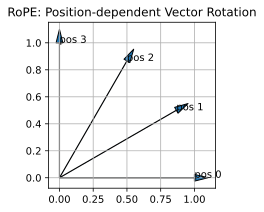

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

def visualize_rope_rotation_simple():
    # Rotation angles for each position
    positions = np.arange(4)  # 4 positions
    angles = positions * np.pi/6  # increasing by 30 degrees each time
    
    # Original vector
    vector = np.array([1, 0])  # Reference vector
    
    plt.figure(figsize=(3, 3))
    for i, theta in enumerate(angles):
        # Create rotation matrix
        rotation = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        
        # Rotate the vector
        rotated = rotation @ vector
        
        # Plot the rotated vector
        plt.arrow(0, 0, rotated[0], rotated[1], 
                 head_width=0.05, head_length=0.1)
        plt.text(rotated[0], rotated[1], f'pos {i}')
    
    plt.grid(True)
    plt.axis('equal')
    plt.title('RoPE: Position-dependent Vector Rotation')
    plt.show()

visualize_rope_rotation_simple()

이 방식의 장점은 상대적 거리 계산이 용이(두 위치 간의 회전 각도 차이)하고 시퀀스 길이 제한이 없습니다. 또한 학습한 길이보다 긴 시퀀스도 처리가 가능합니다. 

**`efficient_encoder_rope.py`의 주요 변경 사항**

1.  **`Embeddings` 클래스:** `position_embeddings`가 제거되고, `forward()`에서 위치 임베딩을 더하는 과정이 없어집니다. RoPE가 위치 정보를 처리하므로 별도의 위치 임베딩이 필요 없습니다.

2.  **`rotate_half` 함수:** RoPE 연산의 핵심 부분입니다.

In [ ]:
    # (efficient_encoder_rope.py)
    def rotate_half(x):
        """Rotates half the hidden dims of the input."""
        x1 = x[..., :x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2:]
        return torch.cat((-x2, x1), dim=-1)

3.  **`apply_rotary_pos_emb` 함수:** 쿼리(q)와 키(k)에 RoPE를 적용합니다.

In [ ]:
    # (efficient_encoder_rope.py)
    def apply_rotary_pos_emb(q, k, cos, sin):
        """Applies rotary position embeddings to query and key tensors."""
        q_embed = (q * cos) + (rotate_half(q) * sin)
        k_embed = (k * cos) + (rotate_half(k) * sin)
        return q_embed, k_embed


4.  **`FlashAttention` 클래스:**

    *   `cos_cached`, `sin_cached`: RoPE에 사용되는 코사인, 사인 값을 미리 계산하여 저장 (캐싱)합니다. `_build_cache()`에서 생성됩니다.
    *   `_build_cache()`: RoPE에 필요한 삼각함수 값들을 미리 계산합니다.
    *   `forward()`: 쿼리, 키에 대해 선형 변환 후, `apply_rotary_pos_emb()`를 호출하여 RoPE를 적용합니다.

In [ ]:
import torch
from typing import Optional
import torch.nn as nn

def apply_rotary_pos_emb(q, k, cos, sin):
    """Applies Rotary Position Embeddings to query and key tensors."""
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

class FlashAttention(nn.Module):
    # ... (rest of the class definition, unchanged) ...

    def _build_cache(self, device, dtype):
        if self.cos_cached is not None and self.cos_cached.dtype == dtype: #Return if cache already exist.
            return

        # Create position indices
        pos_seq = torch.arange(self.max_position_embeddings, device=device, dtype=dtype)

        # Create freqs (theta in paper)
        inv_freq = 1.0 / (10000 ** (torch.arange(0, self.attention_head_size, 2, device=device, dtype=dtype) / self.attention_head_size))

        # Create freqs for each position in sequence.
        freqs = torch.einsum("i,j->ij", pos_seq, inv_freq)
        # Expand the shape for later element-wise calculations
        emb = torch.cat((freqs, freqs), dim=-1)

        # Create the cos and sin cache
        self.cos_cached = emb.cos()[None, None, :, :]  # Add head and batch dimensions
        self.sin_cached = emb.sin()[None, None, :, :]

    def forward(self, hidden_states: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # ... (rest of the forward method, unchanged) ...

        # Apply RoPE
        batch_size, num_heads, seq_len, head_dim = query_layer.shape
        self._build_cache(query_layer.device, query_layer.dtype)

        cos = self.cos_cached[:, :, :seq_len, :head_dim]
        sin = self.sin_cached[:, :, :seq_len, :head_dim]

        query_layer, key_layer = apply_rotary_pos_emb(query_layer, key_layer, cos, sin)

        # ... (rest of the forward method, unchanged) ...

### 9.5.4 실험 결과: AG News 텍스트 분류

두 가지 버전의 효율적인 인코더(`efficient_encoder_rope.py`와 `efficient_encoder.py`)를 사용하여 AG News 데이터셋(뉴스 기사를 4개 카테고리로 분류)에 대한 텍스트 분류 실험을 진행했습니다. 훈련을 수행하는 코드는 `train_ag_news.py`입니다.

AG News 데이터셋은 각 카테고리별로 균형잡힌 뉴스 기사들로 구성되어 있습니다. 각 기사는 최대 128 토큰 길이로 제한되며, BERT, T5 토크나이저 2개를 사용해서 비교 훈련을 수행합니다. 뉴스 텍스트를 World, Sports, Business, Sci/Tech의 4개 카테고리로 분류합니다. 모델의 크기는 다음과 같이 매우 작게 설정을 했습니다.

In [1]:
vocab_size: int = 30522,
hidden_size: int = 256,
num_hidden_layers: int = 4,
num_attention_heads: int = 8,
intermediate_size: int = 512,
hidden_dropout_prob: float = 0.1,
attention_probs_dropout_prob: float = 0.1,
max_position_embeddings: int = 512,
layer_norm_eps: float = 1e-12

다음은 비교 실험을 하는 실행 부분입니다.

In [ ]:
from dldna.chapter_09.encoder.train_ag_news import train_and_test_all_versions

train_and_test_all_versions(verbose=False)

**훈련결과 표**

| 모델 버전 | 토크나이저          | 테스트 정확도 (%) |               비고               |
| -------- | ------------------- | --------------| ------------------------- |
| v1 | bert-base-uncased     |       91.24       |           FlashAttention           |
| v1        | t5-small              |      92.00    |       FlashAttention       |
| v2   | bert-base-uncased     |       92.57       |         RoPE, FlashAttention         |
| v2  | t5-small              |       92.07    |       RoPE, FlashAttention        |

*   **v1**: `efficient_encoder.py` (RoPE 미사용)
*   **v2**: `efficient_encoder_rope.py` (RoPE 사용)

**결과 해석**

1.  **RoPE (v2)의 효과:** `bert-base-uncased` 토크나이저를 사용했을 때, RoPE를 적용한 v2 모델이 v1 모델보다 1.33%p 더 높은 정확도를 보였습니다. 이는 RoPE가 위치 정보를 더 효과적으로 인코딩하여 모델의 성능을 향상시킨다는 것을 시사합니다. 특히, 훈련 데이터보다 긴 시퀀스를 처리해야 하는 경우(길이 외삽, length extrapolation)에 RoPE의 장점이 더 두드러질 수 있습니다.

2.  **토크나이저의 영향:** `t5-small` 토크나이저를 사용했을 때, 두 버전 모두 `bert-base-uncased`를 사용했을 때와 비슷한 수준의 정확도를 보였습니다. 하지만, 미세한 차이지만 v2가 더 좋은 성능을 보이고 있습니다.

3.  **전반적으로 높은 성능:** 두 버전 모두 AG News 데이터셋에서 91% 이상의 높은 정확도를 달성했습니다. 이는 모델 아키텍처가 효과적이며, `F.scaled_dot_product_attention`을 통한 FlashAttention 활용(환경이 지원되는 경우)과 Pre-LN, GELU, Xavier 초기화, AdamW, learning rate scheduler 등 현대적인 Transformer 훈련 기법들이 잘 적용되었음을 나타냅니다.

**유사 모델과의 비교 (표)**

아래 표는 AG News 데이터셋에서 비슷한 크기의 다른 모델들과의 성능을 비교한 것입니다. (정확도는 문헌 및 실험 결과에 따라 달라질 수 있습니다.)

| 모델                                  | hidden_size | num_hidden_layers | AG News 정확도 (대략) |               비고               |
| ------------------------------------ |----------| ------------ | --------------- | ------------------------------ |
| **Efficient Encoder (v2, bert)**    |     256     |         4         |        92.57       |         RoPE, FlashAttention         |
| **Efficient Encoder (v2, t5)** |     256     |      4            |       92.07      |       RoPE, FlashAttention        |
| **Efficient Encoder (v1, bert)**    |     256     |         4         |        91.24       |           FlashAttention           |
| **Efficient Encoder (v1, t5)** |     256     |         4                   |         92.00     |       FlashAttention       |
| TinyBERT (4 layers, hidden_size=312)  |     312     |         4         |       88-90%       |           Distillation           |
| BERT-small                            |     512        |        4                    |      ~90.8%            |             |
| DistilBERT-base                       |     768     |         6         |       90-92%       |  Distillation, BERT-base보다 작음  |
| BERT-base                             |     768     |        12                |       92-95%       |       모델 훨씬 큼            |


**적용된 매커니즘**


| 매커니즘        | v1 (`efficient_encoder.py`) | v2 (`efficient_encoder_rope.py`) |                   비고                   |
| ------------------------ | ---------------------- | ------------------- | ------------------------------ |
| FlashAttention             |               O               |                O                |    GPU 메모리 계층 구조를 활용한 최적화     |
| Pre-LN                     |               O               |                O                |    Layer Normalization을 어텐션/FFN 전에 적용    |
| RoPE                       |               X               |                O                |   회전 행렬을 이용한 위치 정보 인코딩   |
| 학습 가능한 위치 임베딩     |               O               |                X                |       RoPE 미사용 시 위치 정보 표현       |
| Xavier 초기화              |               O               |                O                |             가중치 초기화 방법             |
| GELU 활성화 함수          |               O               |                O                |     비선형 활성화 함수 (FFN에서 사용)     |
| Dropout                    |               O               |                O                |                 일반화 성능 향상                 |
| Layer Normalization          |               O                |                O                |     학습 안정화 및 성능 향상     |
| 사전 훈련된 토크나이저 사용 |               O               |                O                | BERT-base-uncased, t5-small 사용 |

**결론**

본 장에서는 PyTorch의 `F.scaled_dot_product_attention`을 활용하여 FlashAttention을 구현하고, RoPE (Rotary Positional Embeddings)를 적용하여 효율성을 더욱 높인 Transformer 인코더 모델(v2)을 설계했습니다. AG News 텍스트 분류 데이터셋을 사용하여 v1(기본 Transformer 인코더)과 v2(RoPE 적용) 모델을 각각 `bert-base-uncased`와 `t5-small` 토크나이저와 함께 훈련 및 테스트한 결과, v2 모델이 `bert-base-uncased` 토크나이저에서 더 높은 정확도 (92.57%)를 기록했습니다. 이는 RoPE가 상대적 위치 정보를 효과적으로 인코딩하여 모델의 성능, 특히 긴 텍스트 처리 능력을 향상시킨다는 것을 시사합니다.

두 모델 모두 91-92%대의 높은 정확도를 달성했는데, 이는 Efficient Encoder 아키텍처가 효율적이면서도 강력한 성능을 낼 수 있음을 보여줍니다. 또한, `bert-base-uncased`와 `t5-small` 두 토크나이저를 비교했을 때, 미세한 차이지만 `bert-base-uncased`를 사용한 v2에서 더 높은 성능을 달성했습니다.

표에서 볼 수 있듯이, 제안된 Efficient Encoder 모델은 TinyBERT와 같은 소형 모델보다 더 우수한 성능을 보이며, BERT-small과 비교해도 경쟁력 있는 성능을 달성했습니다. DistilBERT-base나 BERT-base와 같은 더 큰 모델에 근접하는 성능을 훨씬 작은 크기로 달성했다는 점이 중요합니다. 이는 사전 훈련된 토크나이저, FlashAttention, Pre-LN 구조, RoPE, Xavier 초기화, GELU 활성화 함수, 그리고 적절한 모델 구성(hidden_size, num_hidden_layers 등)의 조합이 만들어낸 결과라고 할 수 있습니다.

결론적으로, 본 장에서 제시된 Efficient Encoder (v2)는 교육적 목적으로 Transformer의 핵심 구성 요소를 이해하는 데 유용할 뿐만 아니라, 실제 응용 프로그램에서도 충분히 경쟁력 있는 성능을 낼 수 있는 효율적인 모델임을 확인했습니다. 특히, RoPE의 적용은 모델의 성능을 한 단계 더 끌어올리는 효과적인 방법임을 확인했습니다.

## 9.6 Mistral: 효율적인 디코더 아키텍처 구현 및 분석

2023년 Mistral AI에서 공개한 Mistral-7B 모델은 LLaMA 아키텍처를 기반으로 **그룹드 쿼리 어텐션(GQA)** 과 **슬라이딩 윈도우 어텐션(SWA)** 을 도입하여 메모리 효율성과 처리 속도를 크게 개선했습니다. 특히 7B 파라미터만으로도 13B 이상의 모델들과 견줄만한 성능을 보여주며, 효율적인 아키텍처 설계의 중요성을 입증했습니다.

이 절에서는 Hugging Face Transformers의 Mistral 구현을 참고하여 핵심 최적화 요소들을 중심으로 단순화된 mistral 모델을 직접 구현하고 분석합니다. 특히 GQA, SWA, RoPE, KV 캐시 메커니즘을 자세히 살펴보고, 이들이 어떻게 모델의 효율성과 성능에 기여하는지 이해합니다. 코드는 `chapter_09/mistral` 에 있습니다.

### 9.6.1 `simple_mistral` 모델 아키텍처: 구성 요소 상세 분석

`simple_mistral` 모델은 Mistral-7B 모델의 핵심 구성 요소를 간소화하여 구현한 것으로, 각 구성 요소는 모듈화되어 명확한 기능을 수행합니다. 아래에서는 각 구성 요소를 자세히 살펴보겠습니다.

#### 1. MistralConfig: 모델 설정

`MistralConfig` 클래스는 모델의 하이퍼파라미터를 정의합니다. 이는 모델의 구조와 동작 방식을 결정하는 중요한 역할을 합니다.

*   **주요 속성:**
    *   vocab_size: 어휘 사전의 크기를 지정합니다 (기본값: 32000).
    *   hidden_size: 임베딩 및 은닉 상태의 차원을 나타냅니다 (기본값: 4096).
    *   intermediate_size: FeedForward 네트워크의 중간 차원을 정의합니다 (기본값: 14336).
    *   num_hidden_layers: 트랜스포머 디코더 레이어의 개수를 지정합니다 (기본값: 32).
    *   num_attention_heads: 어텐션 헤드의 개수를 나타냅니다 (기본값: 32).
    *   num_key_value_heads: GQA에서 사용되는 키/값 헤드의 개수를 정의합니다 (기본값: 8).
    *   hidden_act: 활성화 함수로, "silu"를 사용합니다 (기본값).
    *   max_position_embeddings: 최대 시퀀스 길이를 지정합니다 (기본값: 4096 * 32).
    *   rms_norm_eps: RMSNorm의 epsilon 값을 나타냅니다 (기본값: 1e-6).
    *   use_cache: KV 캐시 사용 여부를 결정합니다 (기본값: True).
    *   rope_theta: RoPE의 theta 값을 설정합니다 (기본값: 10000.0).
    *   sliding_window: 슬라이딩 윈도우의 크기를 지정합니다 (기본값: 4096).
    *   use_return_dict: 딕셔너리 형태의 반환 여부를 설정합니다 (기본값: True).

#### 2. MistralRMSNorm: RMS 정규화

`MistralRMSNorm` 클래스는 RMSNorm (Root Mean Square Layer Normalization)을 구현합니다. 기존 LayerNorm에서 평균을 제거하고 제곱 평균의 제곱근(RMS)으로 정규화하여 계산 효율성을 향상시킵니다.

*   **특징:** `variance_epsilon`을 사용하여 수치 안정성을 확보합니다.

#### 3. MistralAttention: 어텐션 메커니즘

`MistralAttention` 클래스는 Mistral 모델의 핵심적인 어텐션 메커니즘을 구현합니다. GQA, SWA, RoPE를 통합하여 효율성과 성능을 높입니다.

*   **GQA (Grouped-Query Attention):**
    *   쿼리(Q) 헤드는 여러 개로 유지하고, 키(K)와 값(V) 헤드는 더 적은 수로 설정하여 메모리 사용량과 계산량을 감소시킵니다.
    *   `num_key_value_heads`를 통해 K/V 헤드 수를 조절합니다.
    *   `repeat_kv` 함수를 사용하여 K/V 텐서를 Q 헤드 수에 맞게 복제합니다.

*   **SWA (Sliding Window Attention):**
    *   각 토큰이 제한된 윈도우 내의 토큰에만 attention을 수행하도록 하여 계산 복잡도를 줄입니다.
    *   `sliding_window` 파라미터로 윈도우 크기를 조절합니다.
    *   `attention_mask`를 수정하여 윈도우 외부 토큰과의 attention을 차단합니다.

*   **RoPE (Rotary Positional Embedding):**
    *   회전 행렬을 사용하여 위치 정보를 인코딩합니다.
    *   `MistralRotaryEmbedding` 클래스를 통해 구현됩니다.
    *   `apply_rotary_pos_emb` 함수를 사용하여 쿼리와 키에 RoPE를 적용합니다.

#### 4. MistralRotaryEmbedding: RoPE 구현

`MistralRotaryEmbedding` 클래스는 RoPE (Rotary Positional Embedding)를 구현합니다.

*   **`__init__` 메서드:**
    *   dim: 임베딩 차원을 설정합니다.
    *   max_position_embeddings: 최대 시퀀스 길이를 지정합니다.
    *   base: 주파수 계산을 위한 상수를 정의합니다 (기본값: 10000).
    *   inv_freq: 역 주파수를 계산하며, 학습되지 않는 파라미터로 등록됩니다.
    *   cos_cached, sin_cached: 미리 계산된 코사인, 사인 값을 캐싱합니다.

*   **`forward` 메서드:**
    *   입력 텐서 `x`와 시퀀스 길이 `seq_len`을 받습니다.
    *   `seq_len`이 캐시된 최대 길이보다 크면 `_set_cos_sin_cache`를 호출하여 캐시를 업데이트합니다.
    *   캐시된 코사인, 사인 값을 반환합니다.

*   **`_set_cos_sin_cache` 메서드:**
    *   `seq_len`까지의 위치 인덱스를 생성합니다.
    *   위치 인덱스와 역 주파수를 곱하여 주파수를 계산합니다.
    *   계산된 주파수를 사용하여 코사인, 사인 값을 계산하고 캐싱합니다.

#### 5. MistralMLP: FeedForward 네트워크

`MistralMLP` 클래스는 Mistral 모델의 FeedForward 네트워크를 구현합니다.

*   **구성:**
    *   `gate_proj`, `up_proj`, `down_proj`: 세 개의 선형 레이어를 사용하여 입력을 확장하고 다시 축소합니다.
    *   `act_fn`: SiLU (Sigmoid Linear Unit) 활성화 함수를 사용합니다.

#### 6. MistralDecoderLayer: 디코더 레이어

`MistralDecoderLayer` 클래스는 Mistral 모델의 하나의 디코더 레이어를 구성합니다.

*   **구성 요소:**
    *   `self_attn`: `MistralAttention` 모듈을 사용하여 self-attention을 수행합니다.
    *   `mlp`: `MistralMLP` 모듈을 사용하여 FeedForward 네트워크를 수행합니다.
    *   `input_layernorm`, `post_attention_layernorm`: `MistralRMSNorm`을 사용하여 입/출력 정규화를 수행합니다.

#### 7. MistralPreTrainedModel: 사전 학습 모델 추상 클래스

`MistralPreTrainedModel` 클래스는 Mistral 모델의 가중치 초기화 및 설정을 관리하는 추상 기본 클래스입니다.

*   **주요 메서드:**
    *   `_init_weights`: 가중치를 초기화합니다.
    *   `_set_gradient_checkpointing`: 그래디언트 체크포인팅 활성화 여부를 설정합니다.

#### 8. MistralModel: Mistral 모델

`MistralModel` 클래스는 Mistral 모델의 전체 구조를 정의합니다.

*   **구성 요소:**
    *   `embed_tokens`: 입력 토큰을 임베딩 벡터로 변환합니다.
    *   `layers`: 여러 개의 `MistralDecoderLayer`를 쌓아서 구성합니다.
    *   `norm`: 마지막 레이어의 출력을 정규화합니다.

#### 9. MistralForCausalLM: 언어 모델링용 Mistral

`MistralForCausalLM` 클래스는 Mistral 모델을 언어 모델링(Causal Language Modeling) 태스크에 맞게 ফাইন-튜닝하기 위한 클래스입니다.

*   **주요 구성 요소:**
    *   `lm_head`: 모델 출력을 어휘 사전 크기에 맞게 투사하여 다음 토큰 예측 확률을 계산합니다.
    *   `prepare_inputs_for_generation`: 추론 과정에서 입력을 준비합니다.
    *   `_reorder_cache`: 빔 서치(beam search) 시 KV 캐시를 재정렬합니다.

---

위와 같이 `simple_mistral` 모델은 각 구성 요소를 모듈화하여 효율적이고 유연한 설계를 제공합니다. 각 구성 요소의 역할과 상호 작용을 이해하면 모델의 동작 원리를 더 명확하게 파악할 수 있습니다.


### 9.6.2 핵심 기술 요소 분석: 효율성과 성능의 비결

`simple_mistral` 모델은 GQA, SWA, RoPE와 같은 핵심 기술 요소를 통해 효율성과 성능을 극대화합니다. 각 기술 요소의 동작 방식과 장점을 자세히 분석해 보겠습니다.

#### 1. GQA (Grouped-Query Attention): 메모리와 계산 효율성을 위한 혁신

GQA는 Multi-Head Attention의 변형으로, 메모리 사용량과 계산량을 줄이면서도 성능을 유지하는 핵심 기술입니다.

*   **동작 방식:**
    *   쿼리(Q)는 여러 헤드로 분할되지만, 키(K)와 값(V)는 더 적은 수의 헤드로 분할됩니다.
    *   각 Q 헤드는 특정 K/V 헤드 그룹에 할당됩니다.
    *   Q 헤드는 자신이 할당된 K/V 헤드 그룹에 대해서만 attention을 계산합니다.
    *   `repeat_kv` 함수는 K/V 텐서를 Q 헤드 수에 맞게 복제하여 이러한 메커니즘을 구현합니다.

*   **장점:**
    *   **메모리 사용량 감소:** K/V 텐서의 크기가 줄어들어 KV 캐시의 크기를 줄일 수 있습니다.
    *   **계산량 감소:** Attention 계산량이 줄어들어 추론 속도가 향상됩니다.
    *   **성능 유지:** Q 헤드 수는 그대로 유지되므로 모델의 표현력은 크게 저하되지 않습니다.

#### 2. SWA (Sliding Window Attention): 긴 시퀀스 처리를 위한 효율적인 전략

SWA는 각 토큰이 제한된 범위(윈도우) 내의 토큰에만 attention을 수행하도록 하여 계산 복잡도를 줄이는 기술입니다.

*   **동작 방식:**
    *   각 토큰은 고정된 크기의 윈도우 내에 있는 토큰에만 attention을 수행합니다.
    *   윈도우는 시퀀스를 따라 이동하며, 각 위치에서 attention을 계산합니다.
    *   `attention_mask`를 사용하여 윈도우 외부의 토큰과의 attention을 마스킹합니다.

*   **장점:**
    *   **계산 복잡도 감소:** Attention 계산량이 O(N²)에서 O(N\*W)로 감소합니다. (N: 시퀀스 길이, W: 윈도우 크기)
    *   **긴 시퀀스 처리:** 메모리 사용량이 줄어들어 더 긴 시퀀스를 처리할 수 있습니다.

#### 3. RoPE (Rotary Positional Embedding): 상대적 위치 정보를 효율적으로 인코딩

RoPE는 9.5장에서 이미 살펴보았습니다. 여기서는 모델에 구현된 부분만 간단하게 살펴보겠습니다. 

*   **구현:**
    *   **`rotate_half` 함수:** 입력 텐서의 차원을 반으로 나누어 번갈아 가며 부호를 변경하는 연산을 수행하여 복소수 곱셈의 효과를 구현합니다.

In [ ]:
def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

*   **`apply_rotary_pos_emb` 함수:** 쿼리(q)와 키(k) 텐서에 RoPE를 적용합니다.

In [ ]:
def apply_rotary_pos_emb(q, k, cos, sin, position_ids_q, position_ids_k=None):
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos_q = cos[position_ids_q].unsqueeze(1)  # [batch_size, 1, seq_len, dim]
    sin_q = sin[position_ids_q].unsqueeze(1)  # [batch_size, 1, seq_len, dim]
    cos_k = cos[position_ids_k].unsqueeze(1)  # [batch_size, 1, seq_len, dim]
    sin_k = sin[position_ids_k].unsqueeze(1)  # [batch_size, 1, seq_len, dim]
    q_embed = (q * cos_q) + (rotate_half(q) * sin_q)
    k_embed = (k * cos_k) + (rotate_half(k) * sin_k)
    return q_embed, k_embed

- **`MistralRotaryEmbedding` 클래스**: RoPE에 필요한 코사인, 사인 값을 미리 계산하고 캐싱합니다.
    - `cos_cached`, `sin_cached`: 미리 계산된 코사인, 사인 값
    - `_set_cos_sin_cache`: 시퀀스 길이에 따라 `cos_cached`, `sin_cached` 업데이트


*   **장점:**
    *   **상대적 위치 정보 보존:** 토큰 간의 상대적 거리에 따라 attention 가중치가 자연스럽게 변화합니다.
    *   **길이 외삽(Length Extrapolation):** 훈련 시퀀스 길이보다 더 긴 시퀀스에 대해서도 잘 동작합니다.
    *   **선형 복잡도:** Attention 계산 복잡도에 영향을 주지 않습니다.

GQA, SWA, RoPE는 각각 메모리 효율성, 계산 효율성, 위치 정보 표현 능력을 향상시켜 `simple_mistral` 모델의 전반적인 성능을 끌어올리는 핵심 기술 요소입니다.

#### 4. KV 캐시: 중복 계산을 제거

KV 캐시는 특히 생성 모델에서 추론 속도를 향상시키는 중요한 최적화 기법입니다.

*   **개념:**
    *   KV 캐시는 추론 과정에서 각 디코더 레이어에서 계산된 키(K)와 값(V) 텐서를 저장해 두고 재사용하는 기법입니다.
    *   새로운 토큰을 생성할 때마다 이전 토큰들에 대한 K, V를 다시 계산할 필요 없이, 캐시된 값을 사용하여 연산을 수행합니다.
    *   `past_key_values` 파라미터를 통해 이전 단계의 KV 캐시를 저장하고, `use_cache=True` 설정을 통해 KV 캐시 기능을 활성화합니다. 각 레이어는 `past_key_value`를 입력받아 업데이트된 `present_key_value`를 출력합니다.

*   **장점:**
    *   **추론 속도 향상:** 중복 계산을 제거함으로써 토큰 생성 속도를 크게 높입니다.
    *   **메모리 사용량 증가:** KV 캐시를 저장하기 위한 추가 메모리가 필요하지만, GQA와 SWA 등의 기법을 통해 메모리 증가량을 완화할 수 있습니다.

KV 캐시는 특히 긴 텍스트를 생성할 때 그 효과가 두드러지며, 사용자 경험을 크게 향상시키는 데 기여합니다.


### 9.6.3 모델 학습: `simple_mistral` 훈련 가이드

`simple_mistral` 모델을 학습하는 과정은 크게 데이터 전처리와 모델 학습의 두 단계로 구성됩니다.

#### 1. 데이터 전처리: 모델이 이해할 수 있는 형태로 변환

모델 학습에 사용할 텍스트 데이터를 모델이 처리할 수 있는 형태로 변환하는 과정입니다.

*   **토큰화(Tokenization):**
    *   토크나이저(Tokenizer)를 사용하여 텍스트 데이터를 모델이 처리할 수 있는 숫자(토큰 ID) 형태로 변환합니다.
    *   토크나이저는 텍스트를 작은 단위(토큰)로 분리하고, 각 토큰을 고유한 ID에 매핑합니다.

*   **`attention_mask` 생성:**
    *   `attention_mask`는 패딩(padding) 토큰을 구분하고, 실제 데이터에만 attention이 적용되도록 하는 역할을 합니다.
    *   패딩은 시퀀스 길이를 맞추기 위해 추가되는 토큰으로, attention 계산에서 제외되어야 합니다.

#### 2. 모델 학습: 최적의 파라미터 찾기

`MistralForCausalLM` 모델을 사용하여 언어 모델링(Causal Language Modeling) 방식으로 학습을 진행합니다.

*   **`MistralForCausalLM` 모델:** Mistral 모델을 언어 모델링 태스크에 맞게 구성한 클래스입니다.
*   **손실 함수 (Loss Function):**
    *   `CrossEntropyLoss`를 사용하여 모델의 출력(예측)과 정답 레이블 간의 차이를 계산합니다.
    *   모델은 이 손실을 최소화하는 방향으로 학습됩니다.
*   **옵티마이저 (Optimizer):**
    *   `AdamW` 옵티마이저를 사용하여 모델의 가중치(파라미터)를 업데이트합니다.
    *   AdamW는 Adam 옵티마이저의 개선된 버전으로, 가중치 감쇠(weight decay)를 효과적으로 적용합니다.
*   **학습률 스케줄러 (Learning Rate Scheduler):**
    *   `get_cosine_schedule_with_warmup` 스케줄러를 사용하여 학습률(learning rate)을 점진적으로 감소시킵니다.
    *   학습 초기에는 학습률을 높여 빠르게 수렴하고, 학습 후반부에는 학습률을 낮춰 미세 조정(fine-tuning)을 수행합니다.
*   **그래디언트 클리핑 (Gradient Clipping):**
    *   그래디언트 클리핑을 적용하여 그래디언트 폭주(exploding gradient) 문제를 방지합니다.
    *   그래디언트의 크기가 특정 임계값을 초과하면 값을 잘라내어 안정적인 학습을 돕습니다.

### 9.6.4 `generate()` 함수를 사용한 텍스트 생성: 창의적인 문장 만들기

학습된 모델을 사용하여 새로운 텍스트를 생성하는 과정입니다. `generate()` 함수는 다양한 파라미터를 통해 생성되는 텍스트의 스타일과 다양성을 조절할 수 있습니다.

#### `generate()` 함수: 텍스트 생성의 핵심

*   **기능:** 주어진 프롬프트(prompt)를 기반으로 텍스트를 생성합니다.
*   **KV 캐싱 활용:** `past_key_values`를 사용하여 KV 캐싱을 활용하여 추론 속도를 높입니다.
*   **주요 파라미터:**
    *   max_new_tokens: 생성할 최대 토큰 수를 지정합니다.
    *   temperature: 확률 분포의 형태를 조절하여 생성 결과의 다양성을 제어합니다. (낮은 값: 일관성, 높은 값: 다양성)
    *   top_k: 확률이 높은 상위 k개의 토큰만 고려하여 샘플링합니다.
    *   top_p: 누적 확률이 p 이상인 토큰만 고려하여 샘플링합니다. (nucleus sampling)
    *   repetition_penalty: 반복되는 토큰에 페널티를 부여하여 텍스트의 반복을 줄입니다.

#### 생성 과정: 단계별 텍스트 생성

1.  **초기 입력:** 프롬프트를 토큰화하고 모델에 입력하여 초기 출력을 얻습니다.
2.  **확률 분포 조정:** 출력 로짓(logits)에 `temperature`, `top_k`, `top_p`, `repetition_penalty` 등의 제약 조건을 적용하여 다음 토큰의 확률 분포를 조정합니다.
3.  **토큰 샘플링:** 조정된 확률 분포에 따라 다음 토큰을 샘플링합니다.
4.  **출력 추가 및 KV 캐시 업데이트:** 생성된 토큰을 출력 시퀀스에 추가하고, KV 캐시를 업데이트합니다.
5.  **반복:** 종료 조건(최대 길이 도달 또는 종료 토큰 생성)을 만족할 때까지 2-4단계를 반복합니다.

이 절에서는 Mistral 모델의 학습 및 텍스트 생성 과정을 자세히 살펴보았습니다. 이어지는 절에서는 실제 응용 예제를 통해 `simple_mistral` 모델의 활용법을 세 가지 예제를 통해 살펴봅니다. 예제는 mistral/examples에 있습니다. 

1.  **숫자 시퀀스 예측 (`train_seq_num.py`):** 연속된 숫자를 예측하는 간단한 태스크를 통해 모델의 기본적인 학습 및 생성 능력을 확인합니다.
2.  **사칙 연산 예측 (`train_math.py`):** 덧셈, 뺄셈, 곱셈 연산의 결과를 예측하는 태스크를 통해 모델이 기호적 추론(symbolic reasoning)을 학습하는지 살펴봅니다.
3.  **SQL 쿼리 생성 (`train_sql.py`):** 자연어 질문을 SQL 쿼리로 변환하는 태스크를 통해 모델이 복잡한 언어 구조를 이해하고 처리하는 능력을 평가합니다. (WikiSQL 데이터셋 사용)

해당 위치에서 직접 쉘로 실행을 하면 됩니다.  예를 들어 `python train_seq_num.py` 입니다. 다음은 주피터 노트북에서 실행시키는 방법입니다.

### 9.6.5 숫자 시퀀스 예측 예제: `train_seq_num.py` 분석

`train_seq_num.py`는 `simple_mistral` 모델을 사용하여 간단한 숫자 시퀀스 예측 태스크를 수행하는 예제입니다. 이 예제를 통해 모델이 주어진 숫자 시퀀스 다음에 이어질 숫자를 예측하는 방식으로 어떻게 학습하는지 살펴볼 수 있습니다.

#### 1. 데이터셋 및 데이터 로더 준비: 학습 데이터 구성

`simple_mistral` 모델이 학습할 데이터를 준비하는 단계입니다.

*   **`SimpleDataset` 클래스:**
    *   PyTorch의 `Dataset` 클래스를 상속하여 간단한 숫자 시퀀스 데이터셋을 정의합니다.
    *   `__init__` 메서드는 데이터(`data`)와 시퀀스 길이(`seq_length`)를 입력받아 데이터셋을 초기화합니다.
    *   `__len__` 메서드는 데이터셋의 전체 샘플 수를 반환합니다.
    *   `__getitem__` 메서드는 주어진 인덱스(`idx`)에 해당하는 입력 시퀀스와 레이블 시퀀스를 반환하는데, 이 예제에서는 입력과 레이블이 동일한 시퀀스입니다. 모델 내부에서는 레이블을 자동으로 한 칸씩 앞으로 이동시켜 다음 토큰 예측 태스크를 구성합니다.

*   **`create_simple_data` 함수:**
    *   지정된 어휘 크기(`vocab_size`), 샘플 수(`num_examples`), 시퀀스 길이(`seq_length`)에 맞는 숫자 시퀀스 데이터를 생성합니다.
    *   0부터 `vocab_size - 1`까지의 숫자를 반복하여 `num_examples` 길이의 리스트를 만듭니다.

*   **데이터 로더 (`DataLoader`):**
    *   `DataLoader`는 `SimpleDataset`을 통해 생성된 데이터셋을 미니 배치(mini-batch) 단위로 묶어 모델에 제공하는 역할을 수행합니다.
    *   `batch_size`는 한 번에 모델에 입력될 샘플의 개수를 지정하며,
    *   `shuffle=True`로 설정하면 매 에폭(epoch)마다 데이터의 순서를 무작위로 섞어 학습 효과를 높입니다.

    `SimpleDataset`을 통해 생성되는 훈련 데이터는 다음과 같은 형태를 가집니다.

    ```text
    샘플 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    샘플 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] -> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    ```


    **모델 `forward` 함수에서의 레이블 시프트**

    `simple_mistral` 모델의 `forward` 함수에서는 내부적으로 레이블 시퀀스를 한 칸씩 오른쪽으로 이동시켜 다음 토큰 예측 태스크를 구성합니다. 즉, 모델은 다음과 같이 동작합니다.

    1.  **입력 시퀀스:** `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`
    2.  **모델 입력:** `[0, 1, 2, 3, 4, 5, 6, 7, 8]` (마지막 토큰 제외)
    3.  **모델 예측:** `[1, 2, 3, 4, 5, 6, 7, 8, 9]` (각 위치에서 다음 토큰 예측)
    4.  **레이블:** `[1, 2, 3, 4, 5, 6, 7, 8, 9]` (입력 시퀀스에서 첫 번째 토큰 제외, 모델 예측과 비교)

    이러한 과정을 통해 모델은 입력 시퀀스의 각 위치에서 다음에 올 토큰을 예측하는 능력을 학습하게 됩니다.


#### 2. 모델 설정 및 학습: `simple_mistral` 훈련

`simple_mistral` 모델을 설정하고, 준비된 데이터를 사용하여 학습을 진행하는 단계입니다.

*   **`MistralConfig` 설정:**
    *   `vocab_size`는 토크나이저에 의해 정의된 어휘 크기에 `<eos>` 토큰을 추가하여 설정합니다. 이는 모델이 문장의 끝을 인식할 수 있도록 하기 위함입니다.
    *   `sliding_window`는 시퀀스 길이와 동일하게 설정하여 각 토큰이 전체 시퀀스를 볼 수 있도록 합니다.
    *   `use_cache=False`로 설정하여 훈련 중에는 KV 캐시를 사용하지 않도록 합니다.
* **가중치 공유 (`tie_weights = True`):**
    *   `tie_weights`를 `True`로 설정하여 임베딩 가중치와 출력층(`lm_head`)의 가중치를 공유합니다. 이는 파라미터 수를 줄이고, 특정 패턴(이 경우 순차적인 숫자 생성)을 학습하는 데 도움이 될 수 있습니다.

*   **모델 (`MistralForCausalLM`) 및 옵티마이저 (`AdamW`) 생성:**
    *   `MistralForCausalLM` 모델을 생성하고, 지정된 장치(device, CPU 또는 GPU)로 이동시킵니다.
    *   `AdamW` 옵티마이저를 생성하고, 모델의 파라미터와 학습률(`learning_rate`)을 설정합니다.

*   **`train` 함수 (학습 루프):**
    *   모델을 훈련 모드(`model.train()`)로 설정합니다.
    *   지정된 에폭(epochs) 수만큼 훈련을 반복합니다.
    *   각 에폭에서 데이터 로더로부터 미니 배치를 가져와 모델에 입력하고, 손실(loss)을 계산합니다.
    *   역전파(backpropagation)를 통해 그래디언트를 계산하고, 옵티마이저를 사용하여 모델의 파라미터를 업데이트합니다.
    *   일정 간격으로 배치 손실을 출력하고, 에폭이 끝날 때마다 평균 손실을 출력하여 학습 진행 상황을 모니터링합니다.

#### 3. 텍스트 생성: 학습된 모델을 통한 예측

학습된 모델을 사용하여 새로운 텍스트(숫자 시퀀스)를 생성하는 단계입니다.

*   **`generate_text` 함수:**
    *   모델을 평가 모드(`model.eval()`)로 설정합니다.
    *   시작 텍스트(`start_text`, 예: `['1', '2', '3']`)를 토큰 ID로 변환하여 모델에 입력합니다.
    *   `max_length`까지 반복하면서 다음 토큰을 생성합니다.
        *   모델의 출력 로짓(logits)에 `temperature`를 적용하여 확률 분포를 조정합니다. `temperature` 값이 낮으면 더 일관성 있는 텍스트가, 높으면 더 다양한 텍스트가 생성됩니다.
        *   조정된 확률 분포에서 다음 토큰 ID를 샘플링합니다. (`torch.multinomial` 함수 사용)
        *   샘플링된 토큰 ID를 다시 텍스트로 변환하고, 생성된 토큰 리스트에 추가합니다.
        *   새로 생성된 토큰을 입력에 추가하여 다음 토큰을 예측하는 과정을 반복합니다.
    *   최종적으로 생성된 텍스트를 반환합니다.

#### 4. 결과 분석: 학습 결과 및 생성된 텍스트 평가

모델의 학습 결과와 생성된 텍스트를 분석하는 단계입니다.

*   **훈련 결과:** 훈련 과정에서 손실(loss)이 꾸준히 감소하는 것을 확인할 수 있습니다. 이는 모델이 숫자 시퀀스의 패턴을 성공적으로 학습하고 있음을 의미합니다.
*   **생성 결과:**
    *   `['1', '2', '3']`으로 시작하는 텍스트 생성 결과: `1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20`
    *   `['40', '41', '42']`으로 시작하는 텍스트 생성 결과: `40 41 42 43 44 45 46 47 48 49`

    모델이 주어진 시작 숫자에 이어지는 연속적인 숫자를 정확하게 생성하는 것을 확인할 수 있습니다. 이는 모델이 숫자 시퀀스의 패턴을 학습하고, 이를 바탕으로 새로운 시퀀스를 생성할 수 있음을 보여줍니다.


`train_seq_num.py` 예제는 `simple_mistral` 모델을 사용하여 간단하지만 명확한 숫자 시퀀스 예측 태스크를 성공적으로 수행하는 방법을 보여줍니다. 

In [7]:
import torch
from dldna.chapter_09.mistral.examples.train_seq_num import MistralConfig, MistralForCausalLM, SimpleDataset, create_simple_data, generate_text, train
from torch.utils.data import Dataset, DataLoader

# Hyperparameter settings
base_vocab_size = 50    # Original vocab_size before the EOS token
seq_length = 10         # Sequence length of each training sample
batch_size = 8
epochs = 5
learning_rate = 5e-3
num_train_examples = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Create tokenizer (string token -> token id)
tokenizer_vocab = {str(i): i for i in range(base_vocab_size)}
tokenizer_vocab["<eos>"] = base_vocab_size
updated_vocab_size = base_vocab_size + 1

# 2) Model configuration: Apply the updated vocab_size and set sliding_window to seq_length
config = MistralConfig(
    vocab_size=updated_vocab_size,
    hidden_size=32,
    intermediate_size=64,
    num_hidden_layers=2,
    num_attention_heads=4,
    num_key_value_heads=2,
    max_position_embeddings=128,
    sliding_window=seq_length,  # Set to the same as the sequence length
    use_cache=False  # Do not use cache during training
)
config.eos_token_id = tokenizer_vocab["<eos>"]

# (Optional) Set up weight tying between embedding and lm_head -> Can help reproduce sequential patterns.
tie_weights = True

# 3) Create model and Optimizer
model = MistralForCausalLM(config).to(device)
if tie_weights:
    model.lm_head.weight = model.model.embed_tokens.weight
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# 4) Data generation and DataLoader preparation
train_data = create_simple_data(updated_vocab_size, num_train_examples, seq_length)
train_dataset = SimpleDataset(train_data, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# --- For debugging: Output some data before training ---
print("Sample data before training (input sequence -> label sequence):")
for i in range(2):
    input_seq, label_seq = train_dataset[i]
    print(f"Sample {i+1}: {input_seq.tolist()} -> {label_seq.tolist()}")

# 5) Start training
print("Start training...")
train(model, train_dataloader, optimizer, epochs, device)

# 6) Text generation example
print("Generating text starting with tokens ['1', '2', '3']:")
start_text = ["1", "2", "3"]
generated = generate_text(model, start_text, tokenizer_vocab, max_length=20, device=device)
print("Generated text:", " ".join(generated))

print("Generating text starting with tokens ['40', '41', '42']:")
start_text = ["40", "41", "42"]
generated = generate_text(model, start_text, tokenizer_vocab, max_length=20, device=device)
print("Generated text:", " ".join(generated))

Sample data before training (input sequence -> label sequence):
Sample 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Sample 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] -> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Start training...
Batch 100/124, Loss: 0.0020
Epoch 1/5, Average Loss: 2.2763
Batch 100/124, Loss: 0.0027
Epoch 2/5, Average Loss: 0.0024
Batch 100/124, Loss: 0.0006
Epoch 3/5, Average Loss: 0.0011
Batch 100/124, Loss: 0.0008
Epoch 4/5, Average Loss: 0.0007
Batch 100/124, Loss: 0.0005
Epoch 5/5, Average Loss: 0.0005
Generating text starting with tokens ['1', '2', '3']:
Generated text: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Generating text starting with tokens ['40', '41', '42']:
Generated text: 40 41 42 43 44 45 46 47 48 49


### 9.6.6 사칙 연산 예측 예제: `train_math.py` 분석

`train_math.py`는 `simple_mistral` 모델을 사용하여 간단한 사칙 연산(덧셈, 뺄셈, 곱셈)의 결과를 예측하는 예제입니다. 이 예제를 통해 모델이 숫자와 연산 기호를 이해하고, 간단한 형태의 수학적 추론을 학습하여 수행할 수 있는지 평가합니다. 훈련 데이터 예는 다음과 같습니다.

```text
샘플 1: 4*1=4<eos>
샘플 2: 9+8=17<eos>
```
#### 데이터 생성 및 전처리: 기호와 숫자의 조화

`train_math.py` 예제는 이전의 숫자 시퀀스 예측 예제와 비교하여 데이터 생성, 토크나이저, 모델 설정 등에서 몇 가지 중요한 차이점을 가집니다. 가장 큰 차이점은 다루는 데이터가 단순한 숫자의 나열이 아닌, 숫자, 연산 기호, 등호, 그리고 문장 종료를 나타내는 `<eos>` 토큰으로 구성된 "표현식"이라는 점입니다.

*   **`create_arithmetic_data` 함수: 사칙 연산 데이터 생성**
    *   이 함수는 지정된 개수(`num_samples`)만큼의 사칙 연산 표현식과 그 결과값을 문자열 형태로 생성합니다.
    *   각 표현식은 `f"{num1}{op}{num2}={result}<eos>"` 형태를 따릅니다. (예: `"12+7=19<eos>"`)
        *   `num1`, `num2`: 1부터 `max_value` 사이에서 무작위로 선택되는 정수입니다.
        *   `op`: 덧셈(`+`), 뺄셈(`-`), 곱셈(`*`) 중 무작위로 선택되는 연산 기호입니다.
        *   `result`: 파이썬의 `eval` 함수를 사용하여 계산된 실제 결과값입니다.
        *   **`<eos>` 토큰의 중요성:** 문자열 끝에 `<eos>` (End-of-Sentence) 토큰을 명시적으로 추가하는 것이 매우 중요합니다. 이 특수 토큰은 모델에게 문장의 끝을 알려주는 이정표 역할을 합니다. `<eos>` 토큰이 없으면 모델은 언제 생성을 멈춰야 할지 판단하기 어려워 숫자나 기호를 무한정 계속 출력할 수 있습니다.

*   **`create_tokenizer` 함수: 어휘 사전 정의**
    *   숫자(0-9), 연산 기호('+', '-', '\*'), 등호('=') 그리고 특수 토큰(`<pad>`, `<eos>`)을 포함하는 어휘 사전을 생성합니다. 이 어휘 사전은 모델이 이해할 수 있는 기본적인 문자들을 정의합니다.
        *   `<pad>` 토큰은 서로 다른 길이의 시퀀스를 하나의 배치(batch)로 묶기 위해 사용되는 패딩 토큰입니다.

*   **`create_reverse_tokenizer` 함수: 토큰 ID를 문자로 복원**
    *   토큰 ID를 다시 문자열 토큰으로 변환하는 역방향 딕셔너리를 생성합니다. 이는 생성된 결과를 사람이 읽을 수 있는 형태로 해석하는 데 사용됩니다.

*   **`tokenize_sample` 함수: 문자열을 토큰 리스트로 변환**
    *   `tokenize_sample`함수는 샘플 문자열을 모델이 인식 할 수 있는 토큰 리스트로 변환합니다.
        - `<eos>` 같은 특수 토큰의 경우, 한 토큰으로 처리하여 모델이 특수 토큰을 온전히 인식하도록 합니다.

* **`ArithmeticDataset` 클래스: 학습 가능한 데이터 형태로 변환**

    *  `create_arithmetic_data` 함수에서 생성된 데이터를 PyTorch의 `Dataset` 형태로 변환합니다. `Dataset`은 데이터를 모델에 효율적으로 공급하기 위한 표준화된 방법입니다.
    *   `__getitem__` 메서드는 다음 작업을 수행합니다.
        1.  `tokenize_sample`함수를 이용해, 먼저 샘플 문자열을 토큰화합니다.
        2.  토큰화된 시퀀스의 길이가 지정된 `seq_length`보다 짧으면 `<pad>` 토큰을 사용하여 길이를 맞춥니다. 모든 입력 시퀀스의 길이를 동일하게 만들어 모델이 배치(batch) 단위로 처리할 수 있도록 하기 위함입니다.
        3.  토큰들을 정수 ID로 변환하고, 입력 시퀀스와 레이블 시퀀스(입력과 동일)를 PyTorch 텐서 형태로 반환합니다.


#### 모델 설정 및 학습

*   **`MistralConfig` 설정:** 숫자 시퀀스 예측 예제보다 조금 더 복잡한 태스크이므로, 모델의 크기를 약간 증가시켰습니다. (`hidden_size=64`, `intermediate_size=128`, `num_hidden_layers=3`, `num_attention_heads=8`, `num_key_value_heads=4`). 또한, `pad_token_id`와 `eos_token_id`를 설정하여 모델이 패딩 토큰과 문장 종료 토큰을 인식하도록 합니다.
*   **학습:** 이전 예제와 거의 동일하게 `train` 함수를 사용하여 모델 학습을 진행합니다. `CosineAnnealingLR` 스케줄러를 사용하여 학습률을 점진적으로 감소시켜, 학습 초기에는 빠르게 수렴하고 후반부에는 미세 조정을 돕습니다.

#### 텍스트 생성

*   **`generate_text` 함수:** 주어진 프롬프트(예: "12+7=")를 기반으로 모델이 텍스트(사칙 연산 결과)를 생성하도록 합니다. 모델이 `<eos>` 토큰 또는 `<pad>` 토큰을 생성하면, 결과 문자열 생성을 중단합니다.

#### 결과 분석

*   **훈련 결과:** 훈련 과정에서 손실(loss)이 점차 감소하는 것을 통해 모델이 사칙 연산 패턴을 학습하고 있음을 알 수 있습니다.
*   **생성 결과:** 평가 데이터 예시를 통해, 모델이 주어진 프롬프트에 대해 올바른 연산 결과를 생성하는지 확인합니다. (예: "4+20=" -> "4+20=24")


`train_math.py` 예제는 `simple_mistral` 모델이 단순한 숫자 시퀀스 예측을 넘어서, 사칙 연산과 같은 기호적 추론(symbolic reasoning) 능력을 학습할 수 있음을 보여줍니다. 또한, `<eos>`와 같은 특수 토큰의 역할과 중요성, 그리고 태스크의 난이도에 따른 모델 크기 조정의 필요성을 확인할 수 있습니다.


In [8]:
import torch
import random
from dldna.chapter_09.mistral.examples.train_math import MistralConfig, MistralForCausalLM, generate_text, train,create_arithmetic_data, ArithmeticDataset, create_tokenizer, create_reverse_tokenizer
from torch.utils.data import DataLoader

random.seed(42)
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameter settings
num_samples = 10000   # Total number of samples in the dataset
max_value = 20       # Maximum value of operands
seq_length = 20      # Fixed sequence length including EOS token (e.g., 20)
batch_size = 16
epochs = 20
learning_rate = 1e-3

# Data generation (including EOS token) and output training data examples
arithmetic_data = create_arithmetic_data(num_samples, max_value)
print("Training data examples:")
for i in range(10):
    print(f"Sample {i+1}: {arithmetic_data[i]}")

# Create tokenizer
tokenizer = create_tokenizer()
reverse_tokenizer = create_reverse_tokenizer(tokenizer)
updated_vocab_size = len(tokenizer)

# Configure Dataset and DataLoader
dataset = ArithmeticDataset(arithmetic_data, seq_length, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

config = MistralConfig(
    vocab_size=updated_vocab_size,
    hidden_size=64,
    intermediate_size=128,
    num_hidden_layers=3,
    num_attention_heads=8,
    num_key_value_heads=4,
    max_position_embeddings=128,
    sliding_window=seq_length,
    use_cache=False,
    use_return_dict=True,
    pad_token_id=tokenizer["<pad>"]  # Set the pad token id here.
)
config.eos_token_id = tokenizer["<eos>"]  # Also update the eos token

model = MistralForCausalLM(config).to(device)

# weight tying (share weights between embedding and lm_head)
tie_weights = True
if tie_weights:
    model.lm_head.weight = model.model.embed_tokens.weight

# Create optimizer and add cosine annealing scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

# Start training
print("Start training...")
train(model, dataloader, optimizer, scheduler, epochs, device)

# Evaluation: Output 10 random evaluation samples (terminate generation if EOS is included in the prompt)
print("\nEvaluation data examples:")
for i in range(10):
    sample = random.choice(arithmetic_data)
    # Use the part before '=' as a prompt in the entire expression, e.g., "12+7=19<eos>" ("12+7=")
    prompt = sample.split('=')[0] + '='
    generated = generate_text(model, prompt, tokenizer, reverse_tokenizer, max_length=seq_length, device=device)
    print(f"Generated result for prompt '{prompt}': {generated} (Original data: {sample})")

Training data examples:
Sample 1: 4*1=4<eos>
Sample 2: 9+8=17<eos>
Sample 3: 5*4=20<eos>
Sample 4: 18*3=54<eos>
Sample 5: 14+2=16<eos>
Sample 6: 3+7=10<eos>
Sample 7: 17+20=37<eos>
Sample 8: 18*7=126<eos>
Sample 9: 18+14=32<eos>
Sample 10: 15-19=-4<eos>
Start training...
Epoch 1/20, Average Loss: 2.4820, LR: 0.000994
Epoch 2/20, Average Loss: 1.2962, LR: 0.000976
Epoch 3/20, Average Loss: 1.1905, LR: 0.000946
Epoch 4/20, Average Loss: 1.0831, LR: 0.000905
Epoch 5/20, Average Loss: 0.9902, LR: 0.000855
Epoch 6/20, Average Loss: 0.9112, LR: 0.000796
Epoch 7/20, Average Loss: 0.8649, LR: 0.000730
Epoch 8/20, Average Loss: 0.8362, LR: 0.000658
Epoch 9/20, Average Loss: 0.8194, LR: 0.000582
Epoch 10/20, Average Loss: 0.8128, LR: 0.000505
Epoch 11/20, Average Loss: 0.8049, LR: 0.000428
Epoch 12/20, Average Loss: 0.7971, LR: 0.000352
Epoch 13/20, Average Loss: 0.7945, LR: 0.000280
Epoch 14/20, Average Loss: 0.7918, LR: 0.000214
Epoch 15/20, Average Loss: 0.7903, LR: 0.000155
Epoch 16/20, Aver

### 9.6.7 자연어-SQL 쿼리 생성 예제: `train_sql.py` 분석

`train_sql.py`는 `simple_mistral` 모델을 사용하여 자연어 질문을 SQL 쿼리로 변환하는, 보다 복잡한 자연어 처리 태스크를 다룹니다. 이 예제에서는 모델이 단순한 시퀀스 생성을 넘어서, 복잡한 자연어 문장의 의미를 이해하고, 이를 구조화된 SQL 쿼리 언어로 표현하는 능력을 학습하는 과정을 살펴봅니다. 예제는 문장이 주어지면 이것을 SQL 문 형태로 반환하는 것이 훈련 데이터로 구성되어 있습니다. 다음이 훈련 데이터 예시입니다.

```text
샘플 1: Tell me what the notes are for South Australia sep> SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA eos>
샘플 2: What is the format for South Australia? sep> SELECT Format FROM table WHERE State/territory = South Australia eos>
```

#### 데이터셋 및 전처리: WikiSQL과 특수 토큰의 조화

`train_sql.py` 예제의 핵심은 WikiSQL 데이터셋을 효과적으로 활용하고, 모델이 자연어와 SQL 쿼리 사이의 관계를 학습할 수 있도록 데이터를 전처리하는 데 있습니다.

*   **WikiSQL 데이터셋 로드:** `datasets` 라이브러리를 사용하여 WikiSQL 데이터셋을 불러옵니다. WikiSQL은 자연어 질문과 그에 해당하는 SQL 쿼리가 쌍으로 구성된 데이터셋으로, 자연어-SQL 변환 태스크에 널리 사용됩니다. `load_dataset` 함수의 `split` 인자를 사용하여 훈련(`train`) 데이터셋과 검증(`validation`) 데이터셋을 각각 지정할 수 있습니다.

*   **`WikiSQLDataset` 클래스:** PyTorch의 `Dataset` 클래스를 상속하여 WikiSQL 데이터셋을 모델 학습에 적합한 형태로 가공합니다.
    *   `__init__` 메서드에서는 WikiSQL 데이터셋을 로드하고, 사용할 토크나이저(`tokenizer`)와 최대 시퀀스 길이(`max_length`)를 설정합니다.
    *   `__getitem__` 메서드는 데이터 샘플을 가공하여 모델에 입력할 형태로 변환합니다. 이 과정에서 가장 중요한 부분은 자연어 질문과 SQL 쿼리를 결합하고, 특수 토큰을 추가하는 것입니다.
        1.  먼저, 샘플 데이터에서 자연어 질문(`question`)과 사람이 작성한 SQL 쿼리(`sql['human_readable']`)를 가져옵니다.
        2.  가져온 질문과 SQL 쿼리를 `"질문 <sep> SQL<eos>"` 형태로 결합합니다. 여기서 `<sep>`은 질문과 SQL 쿼리를 구분하는 구분 토큰(separator)이고, `<eos>`는 문장의 끝을 나타내는 종료 토큰(end-of-sentence)입니다. 이러한 특수 토큰들은 모델에게 입력 텍스트의 구조를 알려주는 중요한 역할을 합니다.
        3.  `tokenizer`를 사용하여 결합된 텍스트를 토큰화합니다. 이때, `truncation=True`를 설정하여 텍스트가 `max_length`를 초과하면 잘라내고, `padding="max_length"`를 설정하여 시퀀스 길이가 `max_length`가 되도록 패딩을 추가합니다.
        4.  최종적으로 토큰화된 `input_ids`를 반환합니다. (입력과 레이블은 동일)

*   **토크나이저 (T5Tokenizer):** `transformers` 라이브러리의 `T5Tokenizer`를 사용합니다. `T5Tokenizer`를 선택한 이유는 다음과 같습니다.
    *   다양한 특수 토큰(`<pad>`, `<eos>`, `<sep>` 등)을 기본적으로 지원합니다.
    *   자연어와 SQL 쿼리(코드)를 모두 효과적으로 처리할 수 있는 범용적인 토크나이저입니다.
    *   `tokenizer.vocab_size`를 통해 토크나이저의 어휘 크기를 쉽게 얻을 수 있어, 모델의 `vocab_size`를 설정하는 데 편리합니다.

*   **데이터 로더 (`DataLoader`):** `WikiSQLDataset`을 통해 생성된 데이터셋을 미니 배치 단위로 묶어 모델에 효율적으로 공급하는 역할을 합니다. `batch_size`는 한 번에 모델에 입력될 샘플의 개수를, `shuffle=True`는 매 에폭마다 데이터를 섞어 학습 효과를 높입니다.

#### 모델 설정 및 학습

*   **`MistralConfig` 설정:** 모델의 구조와 관련된 하이퍼파라미터를 설정합니다. 특히, `pad_token_id`, `bos_token_id`, `eos_token_id`를 `tokenizer`의 해당 토큰 ID로 설정하여 모델이 패딩, 문장 시작, 문장 종료 토큰을 올바르게 처리하도록 합니다.

*   **모델 (`MistralForCausalLM`) 및 옵티마이저 (`AdamW`) 생성:** `MistralForCausalLM` 모델을 생성하고, 지정된 장치(CPU 또는 GPU)로 이동시킵니다. `AdamW` 옵티마이저와 `get_cosine_schedule_with_warmup` 스케줄러를 사용하여 학습률을 제어하며 모델을 최적화합니다.

* **`train` 함수**: `train_seq_num.py`와 `train_math.py`에서 사용된 함수와 동일하게, 일반적인 훈련 루프를 사용하여 모델을 학습합니다.

#### 텍스트 생성 (`generate_sql`): 질문으로부터 SQL 쿼리 추론

*   **`generate_sql` 함수:** 학습된 모델을 사용하여 주어진 자연어 질문으로부터 SQL 쿼리를 생성합니다.
    *   먼저, 입력된 질문에 `<sep>` 토큰을 추가하여 `"질문 <sep> "` 형태의 프롬프트를 구성합니다. 이 프롬프트는 모델에게 질문이 끝났으며, 이제 SQL 쿼리를 생성해야 한다는 것을 명확하게 알려줍니다.
    *   **패딩 토큰 처리의 중요성:** 훈련 데이터는 `<eos>` 토큰까지 포함하여 최대 길이(`max_length`)로 패딩됩니다. 그러나 만약 훈련 데이터에 `"질문 <sep> "` 까지만 있고 SQL 부분과 `<eos>`가 없다면(즉, `"질문 <sep> <pad> <pad> ..."` 형태), 모델은 `<sep>` 토큰 뒤에 무엇을 생성해야 할지 학습하지 못합니다. 따라서 생성 단계에서 `<sep>` 이후에 패딩 토큰만 생성하거나, 아예 빈 문자열을 생성할 수 있습니다. 이를 방지하기 위해, 훈련 데이터는 반드시 `"질문 <sep> SQL<eos>"` 형태로 구성되어야 합니다.
    *   `temperature` 파라미터를 사용하여 생성되는 SQL 쿼리의 다양성을 조절합니다.
    *   모델이 `<eos>` 토큰 또는 `<pad>` 토큰을 생성하면 쿼리 생성을 중단합니다.

#### 결과 분석

*   **샘플 출력**: 훈련 전에 WikiSQL 데이터셋의 샘플 3개를 출력하여 데이터의 형태를 확인합니다.
*   **훈련 결과:** 훈련 과정에서 손실(loss)이 감소하는 것을 통해 모델이 자연어 질문을 SQL 쿼리로 변환하는 패턴을 학습하고 있음을 확인할 수 있습니다.
*   **생성 결과:** 검증 데이터셋에 있는 질문을 모델에 입력하여 생성된 SQL 쿼리를 평가합니다. 생성된 SQL 쿼리가 문법적으로 올바른지, 그리고 질문의 의미를 정확하게 반영하는지를 중점적으로 살펴봅니다.

`train_sql.py` 예제는 `simple_mistral` 모델을 사용하여 더 복잡한 자연어 처리 태스크인 자연어-SQL 변환을 수행하는 방법을 보여줍니다. 이 예제는 데이터 전처리 과정에서 특수 토큰(`<sep>`, `<eos>`, `<pad>`)을 적절하게 활용하는 것이 얼마나 중요한지, 그리고 훈련 데이터의 구성이 모델의 생성 능력에 어떤 영향을 미치는지 강조합니다.


In [9]:
import torch
import random
from transformers import T5Tokenizer, get_cosine_schedule_with_warmup
from dldna.chapter_09.mistral.examples.train_sql import MistralConfig, MistralForCausalLM, WikiSQLDataset, generate_sql
from torch.utils.data import DataLoader

random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use T5Tokenizer as the tokenizer (use T5's vocab_size and pad/eos tokens)
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# WikiSQL dataset (training: train, evaluation: validation)
max_length = 128
train_dataset = WikiSQLDataset("train", tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

valid_dataset = WikiSQLDataset("validation", tokenizer, max_length=max_length)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

# Model configuration: Use MistralConfig and MistralForCausalLM provided by simple_mistral.py
# The model size is adjusted for educational purposes.
config = MistralConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=512,
    intermediate_size=2048,
    num_hidden_layers=4,
    num_attention_heads=8,
    num_key_value_heads=4,     # num_attention_heads % num_key_value_heads == 0 must be true
    max_position_embeddings=max_length,
    sliding_window=max_length,
    use_cache=False,
    use_return_dict=True,
    pad_token_id=tokenizer.pad_token_id,  # Set the pad token id.
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)
model = MistralForCausalLM(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 8  # Set the number of epochs small for the example
total_training_steps = num_epochs * len(train_loader)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) // 5,
    num_training_steps=total_training_steps
)
    # Added code: Output WikiSQL data samples
print("=== WikiSQL Data Sample Output ===")
sample_count = 3  # Number of examples to output
for i in range(sample_count):
    input_ids, labels = train_dataset[i]
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    print(f"Sample {i+1}: {decoded_text}")


print("Start training...")
train(model, train_loader, optimizer, scheduler, num_epochs, device)

# Save the model: Save the final model to a file.
torch.save(model.state_dict(), "final_nl2sql_model.pth")

# Evaluation code part
print("\n=== Evaluation Examples ===")
for i, (input_ids, labels) in enumerate(valid_loader):
    if i >= 10:
        break
    # Keep special tokens with skip_special_tokens=False.
    full_text = tokenizer.decode(input_ids[0], skip_special_tokens=False)
    # Unify the tokens "sep>" and "eos>" to "<sep>" and "<eos>" respectively.
    full_text = full_text.replace("sep>", "<sep>").replace("eos>", "<eos>")
    
    if "<sep>" in full_text:
        # Split based on the first <sep>, then join all subsequent parts to restore the complete SQL.
        parts = full_text.split("<sep>")
        question = parts[0].strip()
        target_sql = "<sep>".join(parts[1:]).strip()
        # If target_sql ends with "<eos>", remove it.
        if target_sql.endswith("<eos>"):
            target_sql = target_sql[:-len("<eos>")].strip()
    else:
        question = full_text.strip()
        target_sql = ""

    generated_sql = generate_sql(model, tokenizer, question, max_length, device, temperature=0.7)
    # If there is a "sep>" token in generated_sql, extract the part after that token to use.
    # if "sep>" in generated_sql:
    #     generated_sql = generated_sql.split("sep>", 1)[1].strip()

    print(f"Question: {question}")
    print(f"Target SQL: {target_sql}")
    print(f"Generated SQL: {generated_sql}\n")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


=== WikiSQL Data Sample Output ===
Sample 1: Tell me what the notes are for South Australia sep> SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA eos>
Sample 2: What is the current series where the new series began in June 2011? sep> SELECT Current series FROM table WHERE Notes = New series began in June 2011 eos>
Sample 3: What is the format for South Australia? sep> SELECT Format FROM table WHERE State/territory = South Australia eos>
Start training...
Epoch 1/8, Average Loss: 10.5748, LR: 0.000000
Epoch 2/8, Average Loss: 9.7000, LR: 0.000001
Epoch 3/8, Average Loss: 7.2037, LR: 0.000001
Epoch 4/8, Average Loss: 5.5372, LR: 0.000001
Epoch 5/8, Average Loss: 4.5961, LR: 0.000001
Epoch 6/8, Average Loss: 4.0102, LR: 0.000002
Epoch 7/8, Average Loss: 3.6296, LR: 0.000002
Epoch 8/8, Average Loss: 3.3907, LR: 0.000002

=== Evaluation Examples ===
Question: Who was the minister for the CSV party with a present day end date? <unk>
Target SQL: SELECT Minister FROM table WHERE 

::: {.callout-note collapse="true" title="클릭하여 내용 보기 (딥다이브 : 견고한 트랜스포머 설계 및 디버깅 - 실용 가이드)"}

## 견고한 트랜스포머 설계 및 디버깅 - 실용 가이드

`simple_mistral`과 같은 효율적인 아키텍처를 포함하여 트랜스포머 모델을 처음부터 구축하는 것은 어렵지만 보람 있는 일입니다. 이론적 이해도 중요하지만, 실제 구현 과정에서는 미묘한 버그와 성능 병목 현상이 자주 발생합니다. 이 섹션에서는 트랜스포머를 설계, 구현 및 디버깅하기 위한 실용적인 전략에 대해 심층적으로 설명하며, `simple_mistral`에 사용된 구성 요소(RoPE, RMSNorm, Attention)에 특히 중점을 둡니다. 단위 테스트를 광범위하게 다루고 다른 필수적인 디버깅 및 설계 기술도 논의합니다.

### 1. 단위 테스트의 필수적인 역할

트랜스포머와 같은 복잡한 모델을 구축할 때 단위 테스트는 선택 사항이 *아니라* *필수*입니다. 오류를 조기에 발견하고, 회귀(regression)를 방지하며, 구현에 대한 확신을 줍니다. 잘 테스트된 모델은 *신뢰할 수 있는* 모델입니다.

모든 모델 소스에는 **tests라는 디렉토리에 단위테스트가 있습니다.(예 : mistral/tests, phi3/tests)** 

**트랜스포머에 단위 테스트가 중요한 이유**

*   **복잡성:** 트랜스포머는 상호 작용하는 여러 모듈(Attention, Feedforward 네트워크, Normalization, Embedding)로 구성됩니다. 이러한 구성 요소 중 어느 곳에서든 버그가 쉽게 발생할 수 있습니다.
*   **미묘한 오류:** 많은 트랜스포머 버그는 즉시 명확하게 드러나지 *않습니다*. 충돌을 일으키는 대신 성능 저하나 잘못된 출력을 초래할 수 있습니다. 단위 테스트는 이러한 미묘한 오류를 잡아낼 수 있습니다.
*   **수치 안정성:** 딥 러닝 모델, 특히 혼합 정밀도와 같은 기술을 사용하는 경우 수치 문제(NaN, Inf, Vanishing/Exploding Gradients)에 취약합니다. 단위 테스트는 이러한 문제를 감지하는 데 도움이 됩니다.
*   **리팩토링 및 수정:** 모델을 개선하고 최적화하면서 코드를 변경하는 것은 불가피합니다. 단위 테스트는 변경 사항으로 인해 기존 기능이 손상되지 않도록 보장합니다.
*   **재현성:** 잘 정의된 테스트는 결과의 재현성에 기여합니다.
*   **캐싱 (`past_key_value`):** 모델이 `past_key_values`와 같은 캐싱을 사용하는 경우, shape, dtype 또는 device 관련된 오류가 없는지 단위 테스트를 통해 확인하는 것이 중요합니다.

**효과적인 단위 테스트의 핵심 원칙**

*   **테스트 주도 개발(Test-Driven Development, TDD):** 이상적으로는 모델 코드를 작성하기 *전에* 단위 테스트를 작성해야 합니다. 이렇게 하면 각 구성 요소의 예상되는 동작에 대해 명확하게 생각할 수 있습니다.
*   **모듈성:** 작고 잘 정의된 함수와 클래스로 코드를 모듈식으로 설계합니다. 이렇게 하면 개별 구성 요소를 격리하여 테스트하기가 훨씬 쉬워집니다.
*   **포괄적인 커버리지:** 높은 테스트 커버리지를 목표로 합니다. 클래스의 모든 중요한 함수와 메서드를 테스트합니다.
*   **Edge Cases:** "정상적인 경우"만 테스트하지 마십시오. 엣지 케이스, 경계 조건 및 잠재적인 오류 시나리오를 테스트합니다. (예: 길이가 0인 시퀀스, 단일 요소 배치, 다양한 데이터 타입).
*   **Assertions:** 코드가 예상대로 동작하는지 확인하기 위해 assertion(`assert`)을 자유롭게 사용합니다. assertion을 최대한 구체적으로 작성합니다. 코드가 충돌 없이 실행되는지 확인하는 것뿐만 아니라 *출력*이 올바른지 확인합니다.
*   **Pytest:** 이 장의 예제에서는 `unittest` 모듈을 사용하지만, `pytest` 프레임워크가 파이썬에서 가장 권장됩니다.

**트랜스포머 단위 테스트를 위한 중점 영역**

*   **입력/출력 Shape:** 트랜스포머 구현에서 가장 흔한 유형의 오류는 잘못된 텐서 shape입니다. 모든 테스트에는 출력 텐서의 shape을 확인하는 assertion이 포함되어야 합니다.
*   **Data Type:** 텐서에 예상되는 데이터 타입(예: `torch.float32`, `torch.float16`, `torch.int64`)이 있는지 확인합니다.
*   **Device Placement:** GPU를 사용하는 경우 텐서가 올바른 device(CPU 또는 GPU)에 있는지 확인합니다.
*   **수치 안정성:** 특히 softmax 또는 normalization과 같은 연산 후에 텐서에 NaN(Not a Number) 및 Inf가 있는지 확인합니다.
*   **Gradient Computation:** 모든 훈련 가능한 매개변수에 대해 기울기가 올바르게 계산되는지 확인합니다.
*   **캐싱 (`past_key_value`):** 앞서 살펴본 것처럼 캐싱 메커니즘은 버그의 빈번한 원인입니다. 증분 디코딩(incremental decoding)을 철저히 테스트합니다.

**자세한 단위 테스트 예제 (RoPE, RMSNorm, Attention)**

```python
# test_rope.py
import unittest
import torch
from dldna.chapter_09.mistral.simple_mistral import MistralRotaryEmbedding, apply_rotary_pos_emb, rotate_half

# ...
```

```python
# test_rms_norm.py
import torch
import pytest
from dldna.chapter_09.mistral.simple_mistral import PhiMiniRMSNorm

# ... 

```

```python
# test_attention.py
import torch
import pytest
from dldna.chapter_09.mistral.simple_mistral import PhiMiniConfig, PhiMiniAttention

# ... 

# 어텐션에 대한 추가 테스트

def test_phi_mini_attention_zero_length_initial():
    # ... 

def test_phi_mini_attention_single_token_initial():
    # ... 
@pytest.mark.parametrize("batch_size", [1, 2, 4, 8])
def test_phi_mini_attention_various_batch_sizes(batch_size):
    # ...

@pytest.mark.parametrize("num_heads, num_kv_heads", [(8, 8), (8, 4), (8, 1)]) # MHA, GQA 경우
def test_phi_mini_attention_different_head_configs(num_heads, num_kv_heads):
    # ... 

@pytest.mark.parametrize("dtype", [torch.float16, torch.bfloat16, torch.float32])
def test_phi_mini_attention_mixed_precision(dtype):
    # ... 

def test_phi_mini_attention_combined_mask():
    # ... 

def test_phi_mini_attention_long_sequence():
    # ... 

def test_phi_mini_attention_output_attentions_with_cache():
    # ... 
```

### 2. 단위 테스트를 넘어: 기타 디버깅 전략

단위 테스트가 기본이지만 디버깅 도구의 유일한 도구는 아닙니다. 다음은 다른 중요한 전략입니다.

**1. 로깅 (Logging)**

*   **전략적 로깅:** 코드에 로깅 문(`print` 문 또는 가급적 `logging` 모듈 사용)을 추가하여 주요 변수의 값, 텐서의 shape 및 실행 흐름을 추적합니다. 이렇게 하면 문제가 발생하는 위치를 빠르게 식별하는 데 도움이 될 수 있습니다.
*   **상세 수준 제어:** 로깅을 상세하게 만들되 상세 수준을 제어하는 방법(예: 명령줄 플래그 또는 환경 변수 사용)을 제공합니다. 이를 통해 디버깅 시 자세한 정보를 얻을 수 있지만 정상 작동 중에는 과도한 출력을 피할 수 있습니다.

**2. 시각화 (Visualization)**

*   **Attention Weights:** Attention weight를 시각화하여 모델이 어떤 토큰에 attention을 기울이고 있는지 확인합니다. 이를 통해 attention 메커니즘 또는 position embedding의 문제를 파악할 수 있습니다.
*   **Activations:** 모델에서 뉴런의 activation을 시각화합니다. 이렇게 하면 죽은 뉴런(항상 비활성 상태인 뉴런) 또는 포화된 뉴런(항상 최대값 또는 최소값에 있는 뉴런)을 식별하는 데 도움이 될 수 있습니다.
*   **Gradients:** 훈련 중 gradient를 시각화합니다. 이렇게 하면 vanishing 또는 exploding gradients를 감지하는 데 도움이 될 수 있습니다.

**3. 수치 디버깅 (Numerical Debugging)**

*   **NaN/Inf 검사:** `torch.isnan()` 및 `torch.isinf()`를 사용하여 텐서에 NaN 및 Inf가 있는지 확인합니다. 이는 종종 numerical instability(수치적 불안정성)을 나타냅니다.
    ```python
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print("NaN 또는 Inf 감지!")
    ```
*   **Gradient Checks:** `torch.autograd.gradcheck`를 사용하여 사용자 정의 autograd 함수가 gradient를 올바르게 계산하는지 확인합니다. 이는 자체 attention 메커니즘 또는 기타 복잡한 작업을 구현하는 경우 특히 중요합니다.
*   **작은 테스트 케이스:** 예상 출력을 수동으로 계산할 수 있는 매우 작고 간단한 테스트 케이스(예: 단일 레이어, 작은 vocabulary, 짧은 sequence)를 만듭니다. 이렇게 하면 버그를 격리하는 데 도움이 됩니다.

**4. 디버거 (pdb, IDE 디버거)**

*   **`pdb` (Python Debugger):** 내장된 Python debugger(`pdb`)를 사용하여 코드를 한 줄씩 단계별로 실행하고, 변수를 검사하고, 중단점(breakpoint)을 설정합니다.
    ```python
    import pdb; pdb.set_trace()  # 중단점을 설정하려면 이 줄을 추가합니다.
    ```
*   **IDE Debuggers:** 대부분의 IDE(PyCharm, VS Code 등)에는 디버깅을 위한 보다 사용자 친화적인 인터페이스를 제공하는 통합 디버거가 있습니다.

**5. 프로파일링 (Profiling)**

*   **PyTorch Profiler:** PyTorch profiler를 사용하여 코드의 성능 병목 현상을 식별합니다. 이를 통해 속도 또는 메모리 사용량을 최적화할 수 있는 영역을 찾을 수 있습니다.
*   **Memory Profiling:** `memory_profiler`와 같은 도구를 사용하여 메모리 사용량을 추적하고 잠재적인 메모리 누수(memory leak)를 식별합니다.

**6. 디버깅 가능성을 위한 모델 설계 원칙**

*   **단순하게 유지(Keep it Simple):** 간단한 모델로 시작하여 점차적으로 복잡성을 추가합니다. 이렇게 하면 버그를 더 쉽게 분리할 수 있습니다.
*   **모듈성(Modularity):** 코드를 작고 잘 정의된 모듈로 나눕니다. 이렇게 하면 개별 구성 요소를 더 쉽게 테스트하고 디버깅할 수 있습니다.
*   **Assertions:** assertion을 사용하여 예상되는 조건을 확인하고 오류를 조기에 포착합니다.
*   **주석(Comments) 및 문서화(Documentation):** 코드의 논리를 설명하기 위해 명확하고 간결한 주석과 문서를 작성합니다. 사용자(및 다른 사람)가 코드를 이해하고 잠재적인 문제를 식별하는 데 도움이 됩니다.
*   **재현성(Reproducibility):** 결과가 재현 가능하도록 고정된 random seed를 사용합니다. 이는 디버깅 및 다른 모델 구성 비교에 중요합니다.
*   **단일 배치/작은 데이터 세트에 과적합(Overfitting):** 큰 데이터 세트에서 훈련하기 전에 작은 데이터 세트에 모델을 과적합시킵니다.

**7. 일반적인 실수와 방지 방법**

*   **Incorrect Tensor Shapes:** 특히 reshape, transpose, concatenate와 같은 작업 후에 텐서의 예상 shape을 다시 확인합니다. 디버깅 프로세스에서 `tensor.shape`를 자주 사용합니다.
*   **Off-by-One Errors:** 특히 sequence 및 position embedding으로 작업할 때 인덱싱에 주의합니다.
*   **Data Type Mismatches:** 텐서에 올바른 데이터 타입(예: `float32` 대 `float16`)이 있는지 확인합니다.
*   **Device Mismatches:** 모든 텐서가 동일한 device(CPU 또는 GPU)에 있는지 확인합니다.
*   **Uninitialized Variables:** 사용하기 전에 모든 변수를 초기화합니다.
*   **Incorrect Masking:** attention mask를 사용하는 경우 마스크가 올바르게 적용되고 중요한 정보를 마스킹하지 않는지 확인합니다.
*   **`past_key_values`의 잘못된 사용:** 사용 방법을 따르는지 확인합니다.

이러한 디버깅 기술을 트랜스포머 모델의 기본 원리에 대한 확실한 이해와 결합하면 가장 어려운 구현 문제도 해결할 수 있습니다. 디버깅은 반복적인 프로세스이므로 인내심을 갖고 체계적으로 모든 도구를 사용하십시오.

:::

## 9.7 Gemma: 최신 개방형 모델 살펴보기

Gemma는 Google에서 2024년 2월에 공개한 최신 개방형 모델입니다. 비록 Mistral과 비교했을 때 모델 구조 자체에 혁신적인 변화는 없지만, 최신 모델의 경향을 반영하고 있으며, 특정 상황에서 유용하게 활용될 수 있다는 점에서 살펴볼 가치가 있습니다. Gemma는 LLaMA, Mistral과 마찬가지로 Transformer 기반의 디코더 전용(Decoder-only) 모델 아키텍처를 채택하고 있습니다.

#### Gemma를 살펴보는 이유

1.  **최신 모델 동향 반영:** Gemma는 RoPE (Rotary Positional Embedding), RMSNorm (Root Mean Square Layer Normalization), GeGLU 활성화 함수 등 최신 모델에서 널리 사용되는 구성 요소를 포함하고 있습니다. 이러한 요소들은 모델의 성능과 효율성에 기여하며, 최신 트렌드를 이해하는 데 도움이 됩니다. RoPE는 상대적 위치 정보를 효율적으로 인코딩하여 긴 시퀀스 처리 능력을 향상시키고, RMSNorm은 Layer Normalization에서 평균 중심 연산을 제거하여 계산 효율성을 높입니다. GeGLU는 GLU(Gated Linear Unit)의 변형으로, 비선형성을 통해 모델의 표현력을 증가시킵니다.

2.  **다양한 모델 크기:** Gemma는 2B, 7B, 9B, 27B 로 제공됩니다. 이는 제한된 컴퓨팅 자원을 가진 사용자도 비교적 작은 크기의 모델(2B)을 사용하여 실험해 볼 수 있는 기회를 제공합니다. 더 큰 모델(27B)은 더 높은 성능을 기대할 수 있지만, 더 많은 컴퓨팅 자원을 필요로 합니다. 사용자는 자신의 환경과 필요에 따라 적절한 크기의 모델을 선택할 수 있습니다.

3.  **Google 생태계와의 연동:** Gemma는 Google의 Gemini 프로젝트와 관련되어 있으며, Google Cloud, Vertex AI 등과의 통합이 용이할 수 있습니다. Google 플랫폼을 주로 사용하는 개발자에게는 Gemma가 유용한 선택지가 될 수 있습니다. Google Cloud의 Vertex AI는 머신러닝 모델 학습, 배포, 관리를 위한 통합 플랫폼을 제공하며, Gemma는 이러한 플랫폼과의 호환성을 통해 개발 생산성을 높일 수 있습니다.

4. **개방형 모델의 접근성**: Gemma는 Apache 2.0 라이선스로 공개되어 상업적 이용을 포함, 자유로운 사용, 배포, 수정이 가능합니다.

#### Gemma 모델의 특징 (Mistral과 비교)

| 특징             | Gemma                           | Mistral                          |
|------------------|---------------------------------|----------------------------------|
| **공개 시기**    | 2024년 2월                     | 2023년 9월                      |
| **모델 크기**    | 2B, 7B, 9B, 27B               | 7.3B                            |
| **기반 아키텍처**| Transformer (Decoder-only)     | Transformer (Decoder-only)      |
| **위치 임베딩**   | RoPE                           | RoPE                            |
| **정규화**        | RMSNorm                        | RMSNorm                         |
| **활성화 함수**   | GeGLU                          | SwiGLU                          |
| **Attention**     | Multi-Head Attention (MHA), GQA| Grouped-Query Attention (GQA), SWA |
| **컨텍스트 윈도우**| 최대 8192 토큰                | 최대 131,000 토큰               |
| **주요 특징**     | 다양한 크기, Google 생태계 지원, GeGLU, 넓은 컨텍스트 윈도우 | GQA 및 SWA로 효율적 추론, 긴 컨텍스트 처리 |
| **혁신성 (비교)** | 낮음                           | 높음                            |


*   **유사점:** Gemma와 Mistral은 모두 Transformer 기반의 Decoder-only 모델이며, RoPE, RMSNorm 등 유사한 구성 요소를 사용합니다. 이러한 구성 요소들은 모델의 효율성과 성능을 높이는 데 기여합니다.
*   **차이점:**
    *   Gemma는 활성화 함수로 GeGLU를 사용하는 반면, Mistral은 SwiGLU(SiLU의 변형)를 사용합니다. GeGLU는 입력을 두 개의 선형 변환으로 분리하여 하나는 게이트 역할을 하고, 다른 하나와 곱하여 결과를 생성합니다.
    *   Gemma는 Multi-Head Attention (MHA) 또는 Grouped-Query Attention (GQA)를 사용하는 반면, Mistral은 GQA와 Sliding Window Attention (SWA)을 함께 사용하여 효율성을 높입니다. GQA는 키(K)와 값(V) 헤드의 수를 쿼리(Q) 헤드 수보다 줄여 메모리 사용량과 계산량을 감소시키는 방법입니다. SWA는 각 토큰이 고정된 범위(윈도우) 내에서만 attention을 수행하도록 마스크를 생성해 계산 복잡도를 줄입니다.

#### 결론

Gemma는 모델 구조 자체로는 Mistral에 비해 혁신적이지 않지만, 최신 개방형 모델로서 다음과 같은 의의를 가집니다.

*   **최신 기술 동향 파악:** Gemma를 통해 RoPE, RMSNorm, GeGLU 등 최신 모델에서 널리 사용되는 구성 요소의 구현 및 동작 방식을 이해할 수 있습니다.
*   **다양한 모델 선택지:** Gemma는 2B, 7B, 27B 등 다양한 크기의 모델을 제공하여 사용자의 컴퓨팅 환경에 맞는 선택을 가능하게 합니다.
*   **Google 생태계 활용:** Google 플랫폼 사용자에게는 Gemma가 다른 모델보다 더 나은 통합 및 지원을 제공할 수 있습니다.
* **개방형 모델 접근성**: 누구나 쉽게 접근하고 커뮤니티에 기여할 수 있습니다.

따라서 Gemma는 모델 자체의 혁신성보다는, 최신 기술 동향을 반영한 개방형 모델로서의 실용적인 가치, 그리고 Google 생태계와의 연동 가능성에 초점을 맞춰 살펴보는 것이 좋습니다.

## 9.8 Phi-3 : 작지만 강력한 언어 모델

9.6절과 9.7절에서는 Mistral과 Gemma 모델을 통해 효율적인 언어 모델 아키텍처의 핵심 요소들을 살펴보았습니다. 이번 절에서는 Microsoft에서 개발한 Phi-3 Mini 모델을 직접 구현하고 분석하며, 작은 크기에도 불구하고 뛰어난 성능을 내는 비결을 분석합니다.

Phi-3 Mini는 Microsoft에서 2024년 4월에 공개한 소형 언어 모델(SLM, Small Language Model)입니다. 3.8B 파라미터의 Phi-3 Mini는 Mistral (7B)이나 Gemma (7B)와 같은 더 큰 모델 대비 여러 벤치마크에서 경쟁력 있는 성능을 보여주며, 경량화된 모델의 가능성을 제시합니다. 특히, Phi-3 Mini는 **"고품질 데이터"** 와 **"효율적인 아키텍처"** 의 중요성을 강조하며, 단순한 모델 크기 경쟁을 넘어선 새로운 방향을 제시합니다. 이러한 철학은 "Textbooks Are All You Need"라는 슬로건에 잘 나타나 있습니다. `simple_phi3.py`는 Phi-3 Mini의 핵심 구성 요소를 단순화하여 구현한 코드입니다. 전체 코드는 `chapter_09/phi3`에 있습니다.

### 9.8.1 `simple_phi3` 모델

`simple_phi3` 은 Phi-3 Mini를 교육적 목적으로 구현한 모델입니다. 9.6장의 simple mistral 대비 비교를 하면 다음과 같습니다. 

**모델 기능 차이 요약**

| 기능 | Simple Phi-3 | Simple Mistral |
|---|---|---|
| Attention | Multi-Head Attention (MHA) | Grouped-Query Attention (GQA) + Sliding Window Attention (SWA) |
| Activation | GELU (tanh 근사) | SiLU |
| Normalization | RMSNorm | RMSNorm |
| Positional Encoding | RoPE | RoPE |
| `past_key_value` | 지원 (캐싱) | 지원 (캐싱) |
| Sliding Window | 미지원 | 지원 |
| GQA | 미지원 (MHA 사용, K=V=Q, `num_key_value_heads` 설정) | 지원 |
| Scaled Dot Product Attention | `F.scaled_dot_product_attention` 사용 | `F.scaled_dot_product_attention` 사용 |
| 향상된 RoPE 캐싱 | `forward` 메서드 내에서 `cos`, `sin` 캐시 효율적 관리, `_set_cos_sin_cache`로 필요시 업데이트. incremental decoding 시 `apply_rotary_pos_emb_single` 함수로 RoPE 적용 로직 최적화, 중복 계산 최소화. | `_set_cos_sin_cache` 메서드에서 `cos_cached`, `sin_cached` 생성, `forward`에서 사용. `apply_rotary_pos_emb`에서 쿼리와 키에 다른 position ID 사용 가능. |
| Attention Mask 최적화 | `scaled_dot_product_attention` 함수 사용, `attention_mask`와 `causal_mask` 효율적 결합, 불필요한 연산 줄임 | `scaled_dot_product_attention` 함수 사용, `attention_mask`, `sliding_window_mask` 처리 |
| `return_dict` | `return_dict`로 유연하고 명확하게 output 반환. | `return_dict`를 통해 output 반환. |
| Weight Tying | `post_init`에서 임베딩 가중치와 출력 레이어 가중치 묶어(tying) 파라미터 수 감소, 성능 향상 | 명시적인 weight tying 언급 없음 |


**주요 개선사항**

*   **Multi-Head Attention (MHA):** Mistral의 GQA(Grouped-Query Attention) 대신, 일반적인 MHA를 사용합니다. Phi-3 Mini는 GQA 없이도 충분한 성능을 달성할 수 있음을 보여줍니다.
*   **향상된 RoPE 캐싱:** `forward` 메서드 내에서 `cos`와 `sin` 캐시를 효율적으로 관리하고, `_set_cos_sin_cache`를 통해 필요할 때만 업데이트합니다. 또한, incremental decoding 시 `apply_rotary_pos_emb_single` 함수를 사용하여 RoPE 적용을 최적화하고 중복 계산을 최소화합니다.
*   **Attention Mask 최적화:** `scaled_dot_product_attention` 함수를 사용하면서 `attention_mask`와 `causal_mask`를 효율적으로 결합하여 불필요한 연산을 줄입니다.
*   **Weight Tying:** `post_init`에서 임베딩 가중치와 출력 레이어 가중치를 묶어(tying) 파라미터 수를 줄이고 성능을 향상시킵니다.

이제 `simple_phi3` 모델의 핵심 구성 요소들을 자세히 살펴보겠습니다. 

#### 1. PhiMiniConfig: 모델 설정

`PhiMiniConfig` 클래스는 모델의 하이퍼파라미터를 정의합니다. Phi-3 Mini의 설정을 따르며, Mistral에서 이미 자세히 설명했으므로, 여기서는 생략합니다.

#### 2. PhiMiniRMSNorm: RMS 정규화

`PhiMiniRMSNorm` 클래스는 RMSNorm (Root Mean Square Layer Normalization)을 구현하며, Mistral과 동일합니다.

#### 3. PhiMiniRotaryEmbedding: RoPE 구현 (향상된 캐싱)

`PhiMiniRotaryEmbedding` 클래스는 RoPE (Rotary Positional Embedding)를 구현합니다. Mistral의 `MistralRotaryEmbedding`과 유사하지만, 다음과 같은 핵심적인 개선을 통해 캐싱 효율성을 극대화했습니다.

*   **`forward` 메서드 내 캐시 관리:**
    *   `forward` 메서드에서 `cos_cached`와 `sin_cached`를 직접 사용합니다. 즉, 이미 계산된 값이 있으면 바로 활용합니다.
    *   `seq_len`이 `max_seq_len_cached`보다 큰 경우, 즉 새로운 시퀀스 길이에 대한 캐시가 필요한 경우에만 `_set_cos_sin_cache` 메서드를 호출하여 캐시를 업데이트합니다. 이를 통해 불필요한 캐시 생성을 방지하고, 이미 계산된 값을 최대한 재사용합니다.

*   **`max_seq_len_cached`, `cos_cached`, `sin_cached` 인스턴스 변수:**
    *   `max_seq_len_cached`: 현재까지 캐싱된 최대 시퀀스 길이를 저장합니다.
    *   `cos_cached`, `sin_cached`: 미리 계산된 코사인, 사인 값을 저장합니다.
    *   이 변수들을 인스턴스 변수로 관리함으로써, `forward` 메서드가 호출될 때마다 새로 생성하지 않고 재사용하여 효율성을 높입니다.

* **Incremental Decoding 최적화:**
    *   `apply_rotary_pos_emb_single`:  `past_key_value`를 사용하는 incremental decoding 상황에서, 전체 시퀀스가 아닌 **새로운 토큰**에 대해서만 RoPE를 적용할 수 있게 해줍니다. 이전 토큰들에 대한 RoPE 결과는 이미 `past_key_value`에 저장되어 있으므로, 중복 계산을 피할 수 있습니다.

이러한 개선 사항들은 RoPE 연산의 효율성을 크게 향상시켜, 특히 긴 시퀀스를 처리하거나 텍스트 생성 시 성능 이점을 제공합니다.

#### 4. PhiMiniAttention: 어텐션 메커니즘 (MHA, 효율적인 RoPE 적용)

`PhiMiniAttention` 클래스는 Phi-3 Mini의 어텐션 메커니즘을 구현합니다. Mistral의 GQA 대신 일반적인 Multi-Head Attention (MHA)을 사용하지만, RoPE 적용 방식을 최적화하여 효율성을 높였습니다.

*   **MHA (Multi-Head Attention):** 쿼리(Q), 키(K), 값(V) 헤드 수가 모두 같습니다.
*   **효율적인 RoPE 적용:**
    *   `past_key_value`의 존재 여부에 따라 position IDs를 다르게 생성합니다.
        *   `past_key_value`가 없으면 (일반적인 경우): 전체 시퀀스에 대한 position IDs (`0`부터 `q_len - 1`까지)를 생성합니다.
        *   `past_key_value`가 있으면 (incremental decoding): 새로운 토큰에 대한 position ID (`past_len`부터 `past_len + q_len - 1`까지)와 전체 키 시퀀스에 대한 position IDs (`0`부터 `past_len + q_len - 1` 까지)를 생성합니다.
    *   `apply_rotary_pos_emb_single` 함수를 통해, `past_key_value`가 있을 때 (incremental decoding) 새로운 토큰(query)에 대해서만 RoPE를 적용합니다.
*   **KV 캐싱:** Mistral과 동일하게 `past_key_value`를 통해 이전 단계의 키/값 텐서를 캐싱하여 추론 속도를 높입니다.

#### 5. 헬퍼 함수: `rotate_half`, `apply_rotary_pos_emb`, `apply_rotary_pos_emb_single`

*   `rotate_half`: RoPE 구현에 필요한 헬퍼 함수로, Mistral과 동일합니다.
*   `apply_rotary_pos_emb`: 쿼리(q)와 키(k) 텐서에 RoPE를 적용합니다. Mistral과 달리 position_ids를 하나만 받습니다.(쿼리와 키에 동일하게 적용)
*   `apply_rotary_pos_emb_single`: `past_key_value`를 사용하는 incremental decoding 상황에서, 입력 텐서 `x` (query 또는 key)에 RoPE를 적용합니다.

#### 6. PhiMiniMLP: FeedForward 네트워크

`PhiMiniMLP` 클래스는 FeedForward 네트워크를 구현하며, Mistral과 큰 차이 없이, GELU 활성화 함수를 사용합니다.

#### 7. PhiMiniDecoderLayer: 디코더 레이어

`PhiMiniDecoderLayer` 클래스는 Mistral과 동일하게 Pre-Norm 구조와 Residual Connection을 사용합니다.

#### 8. PhiMiniModel: 전체 모델

`PhiMiniModel` 클래스는 전체 Phi-3 Mini 모델을 구성하며, Mistral과 유사합니다.

#### 9. PhiMiniForCausalLM: 언어 모델링을 위한 헤드 추가

`PhiMiniForCausalLM` 클래스는 `PhiMiniModel`에 언어 모델링을 위한 헤드(`lm_head`)를 추가합니다.

*   **`post_init` 메서드:**
    *   가중치 초기화를 수행합니다. (Mistral과 유사)
    *   **Weight Tying:** 임베딩 가중치(`self.transformer.embed_tokens.weight`)와 출력 레이어 가중치(`self.lm_head.weight`)를 묶습니다(tie). 이는 파라미터 수를 줄이고, 과적합을 방지하며, 일반적으로 성능을 향상시키는 효과가 있습니다.
*   **`generate` 함수:** 텍스트 생성을 위한 함수로, incremental decoding 시 RoPE 관련 문제를 해결하기 위해 `past_key_values`가 존재하면 전체 시퀀스 대신 마지막 토큰만 `forward()`에 전달합니다.

### 9.8.2 `simple_phi3` 모델 예제: 복합 수식 계산

9.8.1절에서 살펴본 `simple_phi3` 모델의 실제 활용 예시로, 복합 수식 계산 능력을 테스트해보겠습니다. 이 예제를 통해 Phi-3 Mini와 같은 소형 언어 모델(SLM)이 단순한 덧셈, 뺄셈을 넘어서, 곱셈, 괄호가 포함된 복잡한 수식도 처리할 수 있는지 확인하고, 그 성능과 한계를 분석합니다. 

예제 코드 위치는 **chapter_09/phi3/examples/train_math.py**입니다.

**예제의 의의**

*   **SLM의 능력 검증:** 작은 크기의 모델도 고품질 데이터와 효율적인 아키텍처를 통해 복잡한 문제를 해결할 수 있음을 보여줍니다.
*   **추론 능력 평가:** 단순 암기가 아닌, 학습된 연산 규칙을 바탕으로 새로운 수식에 대한 답을 추론하는 능력을 평가합니다.
*   **실용적 가능성 탐색:** 복합 수식 계산은 자연어 처리, 데이터 분석 등 다양한 분야에서 활용될 수 있는 기본적인 능력입니다. 이 예제를 통해 SLM의 실용적인 활용 가능성을 엿볼 수 있습니다.

**훈련 데이터 형태**

`create_complex_arithmetic_data` 함수를 사용하여 다음과 같은 형태의 복합 수식 데이터를 생성했습니다.

*   두 개 또는 세 개의 숫자 (1 ~ 50)
*   세 가지 연산자 (+, -, \*) 중 두 개 사용
*   선택적으로 괄호 (()) 사용
*   `표현식=결과<eos>` 형태 (예: `(12+7)*3=57<eos>`, `12+7*3=33<eos>`)

**훈련 결과**

```python
샘플 1: 41*8-2=326<eos>
샘플 2: 15+(9*48)=447<eos>
샘플 3: 35-6+38=67<eos>
샘플 4: 6*14*15=1260<eos>
샘플 5: 36*(13*46)=21528<eos>

...(훈련 로그 생략)...

프롬프트: '23-23-50=' --> 생성 결과: '23-23-50=-50'  (정답: 23-23-50=-50<eos>)
프롬프트: '39-46-15=' --> 생성 결과: '39-46-15=-22'  (정답: 39-46-15=-22<eos>)
프롬프트: '(33-30)+30=' --> 생성 결과: '(33-30)+30=33'  (정답: (33-30)+30=33<eos>)
프롬프트: '30+14*27=' --> 생성 결과: '30+14*27=412'  (정답: 30+14*27=408<eos>)

```

**결과 분석**

*   **대체로 정확한 계산:** 대부분의 테스트 케이스에서 정답과 일치하거나 매우 근접한 결과를 생성했습니다. 이는 `simple_phi3` 모델이 복합 수식의 연산 규칙을 잘 학습했음을 의미합니다.
*   **일부 오차 발생:** 곱셈이 포함되거나, 숫자가 커질수록 오차가 발생하는 경향이 있습니다. 이는 모델의 크기 제한, 훈련 데이터의 다양성 부족 등 여러 요인에 의해 발생할 수 있습니다.
*   **괄호 처리 능력:** 괄호가 포함된 수식도 비교적 정확하게 처리하는 모습을 보여, 문맥(context)을 파악하고 연산 순서를 이해하는 능력을 갖추고 있음을 시사합니다.

**결론**

`simple_phi3` 모델은 약 12만 파라미터의 매우 작은 모델임에도 불구하고, 복합 수식 계산에서 약 80%의 높은 정답률을 보여주었습니다. 이는 괄호 처리, 연산 순서 등 복잡한 규칙을 상당 부분 학습했음을 의미합니다. 일반적으로 수십억(Billion) 파라미터를 갖는 대규모 언어 모델(LLM)과 비교하면, simple_phi3는 극도로 작은 크기(0.12M)임에도 불구하고 인상적인 결과를 보여줍니다.

In [3]:
import torch
import random
from dldna.chapter_09.phi3.examples.train_complex_math import PhiMiniConfig, PhiMiniForCausalLM, ComplexArithmeticDataset, train, create_complex_arithmetic_data, create_tokenizer, create_reverse_tokenizer, generate_text
from torch.utils.data import DataLoader

random.seed(42)
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
num_samples = 100000      # Sufficiently large amount of data
max_value = 50           # Maximum value of operands (for slightly complex calculations)
seq_length = 30          # Complex arithmetic problems can have somewhat long expressions
batch_size = 128
epochs = 30
learning_rate = 1e-3

# Data generation
complex_data = create_complex_arithmetic_data(num_samples, max_value)
print("Training data examples:")
for i in range(5):
    print(f"Sample {i+1}: {complex_data[i]}")

# Create tokenizer and reverse tokenizer
tokenizer = create_tokenizer()
reverse_tokenizer = create_reverse_tokenizer(tokenizer)
updated_vocab_size = len(tokenizer)

# Configure Dataset and DataLoader
dataset = ComplexArithmeticDataset(complex_data, seq_length, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# PhiMini Model Configuration
config = PhiMiniConfig(
    vocab_size=updated_vocab_size,
    hidden_size=64,              # Small model size for experimentation
    intermediate_size=128,
    num_hidden_layers=3,
    num_attention_heads=8,
    num_key_value_heads=8,        # K=V=Q
    max_position_embeddings=128,
    use_cache=False,
    use_return_dict=True,
)
config.pad_token_id = tokenizer["<pad>"]
config.eos_token_id = tokenizer["<eos>"]

# Create PhiMini For CausalLM Model
model = PhiMiniForCausalLM(config).to(device)
print("Total Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# weight tying (share weights between embedding and lm_head)
model.lm_head.weight = model.transformer.embed_tokens.weight

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

# Model Training
print("Start training...")
train(model, dataloader, optimizer, scheduler, epochs, device)

# Save Model
save_path = "phimini_complex_math.pt"
torch.save(model.state_dict(), save_path)
print(f"Model saved: {save_path}")

# Load Saved Model (create a new model object before testing and load_state_dict)
loaded_model = PhiMiniForCausalLM(config).to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()

# Generate and Print Results with Test Set, Calculate Accuracy
print("\nTest sample generation results:")
test_samples = random.sample(complex_data, 10)
correct_count = 0
for sample in test_samples:
    prompt = sample.split('=')[0] + '='
    generated = generate_text(loaded_model, prompt, tokenizer, reverse_tokenizer, seq_length, device, temperature=0.1)  # Reduce temperature for testing
    answer = sample.split('=')[1].replace('<eos>', '')

    if generated.split('=')[1] == answer:
        correct_count += 1
    print(f"Prompt: '{prompt}' --> Generated result: '{generated}'  (Correct answer: {sample})")

accuracy = (correct_count / len(test_samples)) * 100
print(f"\nOverall accuracy: {accuracy:.2f}% ({correct_count}/{len(test_samples)})")

Training data examples:
Sample 1: 41*8-2=326<eos>
Sample 2: 15+(9*48)=447<eos>
Sample 3: 35-6+38=67<eos>
Sample 4: 6*14*15=1260<eos>
Sample 5: 36*(13*46)=21528<eos>
Total Trainable Parameters: 126208
Start training...
Epoch 1/30, Avg Loss: 0.7439, LR: 0.000997
Epoch 2/30, Avg Loss: 0.6393, LR: 0.000989
Epoch 3/30, Avg Loss: 0.6139, LR: 0.000976
Epoch 4/30, Avg Loss: 0.5919, LR: 0.000957
Epoch 5/30, Avg Loss: 0.5825, LR: 0.000934
Epoch 6/30, Avg Loss: 0.5753, LR: 0.000905
Epoch 7/30, Avg Loss: 0.5696, LR: 0.000873
Epoch 8/30, Avg Loss: 0.5649, LR: 0.000836
Epoch 9/30, Avg Loss: 0.5599, LR: 0.000796
Epoch 10/30, Avg Loss: 0.5558, LR: 0.000753
Epoch 11/30, Avg Loss: 0.5522, LR: 0.000706
Epoch 12/30, Avg Loss: 0.5479, LR: 0.000658
Epoch 13/30, Avg Loss: 0.5443, LR: 0.000608
Epoch 14/30, Avg Loss: 0.5409, LR: 0.000557
Epoch 15/30, Avg Loss: 0.5370, LR: 0.000505
Epoch 16/30, Avg Loss: 0.5339, LR: 0.000453
Epoch 17/30, Avg Loss: 0.5307, LR: 0.000402
Epoch 18/30, Avg Loss: 0.5280, LR: 0.000352

## 맺음말

9장에서는 "Attention is All You Need"라는 기념비적인 논문에서 Transformer 아키텍처가 세상에 첫선을 보인 2017년부터 2025년 현재에 이르기까지, Transformer 발전의 핵심 동인인 **효율성**과 **확장성**을 중심으로 그 여정을 따라갔습니다.

초기 Transformer는 획기적인 성능을 보여주었지만, 시퀀스 길이에 따라 급증하는 계산량과 메모리 사용량이라는 근본적인 한계에 직면했습니다. 9장은 이러한 제약을 극복하기 위한 끊임없는 노력, 즉 소프트웨어적인 접근(9.2절)과 하드웨어와 소프트웨어의 결합(9.3절), 그리고 모델 확장성(9.4절)을 위한 다양한 기술적 혁신들을 심도 있게 다루었습니다. RoPE와 FlashAttention의 구현 예제(9.5절)부터 Mistral, Gemma, Phi-3 Mini와 같은 최신 모델들의 아키텍처 분석(9.6, 9.7, 9.8절)에 이르기까지, 이론과 실제 구현을 아우르는 탐구를 통해 효율적인 Transformer 아키텍처를 조명했습니다.

이러한 기술적 진보 덕분에 Transformer는 이제 더 긴 문맥을 이해하고, 더 복잡한 문제를 해결하며, 더 광범위한 분야에 적용될 수 있는 강력한 도구로 자리매김했습니다. Transformer가 단순한 언어 모델을 넘어, 인공지능 기술 발전의 핵심 동력으로 성장하는 데 있어 **효율성과 확장성**이 얼마나 중요한 역할을 했는지 알 수 있습니다.

물론, 여전히 해결해야 할 과제는 남아 있습니다. 모델 대형화에 따른 에너지 소비 증가, 편향 및 유해성 문제, 그리고 모델 해석 가능성 문제는 앞으로 우리가 극복해야 할 중요한 도전 과제입니다. 더 안전하고, 신뢰할 수 있으며, 인간과 조화롭게 협력하는 AI 시스템을 향한 연구는 계속될 것입니다.

이제 10, 11장에서는 Transformer가 텍스트라는 단일 영역을 넘어 이미지, 오디오, 비디오 등 다양한 데이터 유형을 통합하는 **멀티모달(Multimodal)**의 세계로 나아가는 여정을 시작합니다. 여러 모달리티의 정보를 융합하여 더 풍부하고 강력한 표현력을 얻는 멀티모달 모델은 더 복잡한 추론을 가능하게 합니다. ViT, CLIP, DALL-E, Stable Diffusion, Flamingo, GATO, Gemini 등 텍스트와 이미지를 결합하는 선구적인 모델들을 중심으로, 멀티모달 어텐션 메커니즘과 그 무한한 응용 가능성을 탐험할 것입니다. 9장에서 다룬 효율성과 확장성의 혁신은 10. 11장에서 펼쳐질 멀티모달 Transformer의 미래를 위한 든든한 초석이 될 것입니다.

::: {.callout-note collapse="true" title="클릭하여 내용 보기 (딥다이브 : MoE 아키텍처의 이론적 진화와 최신 기술 동향)"}

## MoE(Mixture of Experts) 아키텍처의 이론적 진화와 최신 기술 동향

대규모 언어 모델(LLM)의 발전에 있어 Mixture of Experts (MoE)는 모델 용량과 계산 효율성의 균형을 혁신적으로 해결하는 프레임워크로 부상했습니다. MoE는 여러 개의 "expert" 네트워크를 조합하고, gating network를 통해 입력에 따라 적절한 expert를 선택적으로 활성화하는 방식으로 작동합니다. 여기서 MoE의 핵심 메커니즘을 심층적으로 해부하고, 최신 연구 동향을 반영한 확장 이론을 체계적으로 정리합니다.

### 1. MoE의 이론적 기반

#### 1.1 기본 구성 요소

*   **Expert 네트워크:** 일반적으로 Feedforward Neural Network (FFN)로 구성된 *N*개의 expert 네트워크 $\{E_i\}_{i=1}^N$가 있습니다. 각 expert는 입력 $x$를 받아 출력 $E_i(x)$를 생성합니다.
*   **Gating 네트워크:** Gating 네트워크 $G$는 입력 $x$를 받아 각 expert에 대한 가중치(확률)를 출력합니다. 이 가중치는 입력 $x$에 대해 어떤 expert가 가장 적합한지를 나타냅니다. Gating 네트워크의 출력 $G(x)$는 *N*차원 벡터이며, 각 원소 $G(x)_i$는 *i*번째 expert에 대한 가중치를 나타냅니다.
*   **최종 출력:** MoE 모델의 최종 출력 $y$는 expert 출력의 가중 합으로 계산됩니다.

    $y = \sum_{i=1}^{N} G(x)_i E_i(x)$

#### 1.2 Sparse MoE와 Dense MoE

*   **Dense MoE:** 모든 expert가 모든 입력에 대해 계산을 수행하고, gating network는 softmax 함수를 통해 각 expert 출력의 가중치를 결정합니다. ($G(x) = \text{softmax}(W_g x)$)
*   **Sparse MoE:** 각 입력마다 소수의 expert만 활성화됩니다. Gating network는 Top-k gating (가장 큰 *k*개의 값을 가지는 expert 선택) 또는 Noisy Top-k gating (GShard, Switch Transformer)을 사용합니다.

#### 1.3 수학적 형식화와 변분 추론 관점 

MoE 시스템을 확률적 그래피컬 모델로 재해석할 때, 관측 데이터 $\mathbf{x}$와 잠재 변수 $\mathbf{z}$(전문가 선택 지시자)의 결합 분포는 다음과 같이 모델링됩니다.

$p(\mathbf{x}, \mathbf{z}|\theta) = p(\mathbf{z}|\theta_g)p(\mathbf{x}|\mathbf{z},\theta_e)$

여기서 $\theta_g$는 게이팅 네트워크, $\theta_e$는 전문가 네트워크의 매개변수를 나타냅니다. 변분 추론 프레임워크에서 Evidence Lower Bound(ELBO)는 다음과 같이 유도됩니다.

$\mathcal{L}(\theta, \phi) = \mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})}[\log p_\theta(\mathbf{x}|\mathbf{z})] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x}) \parallel p(\mathbf{z}))$

이 접근법은 MoE 학습 과정을 베이지안 추론 체계로 재정의하여, 전문가 간 지식 분할의 이론적 토대를 마련합니다. 특히 Gumbel-Softmax 재매개화 기법은 이산적인 전문가 선택 과정을 연속 근사함으로써 경사 하강법 적용을 가능하게 합니다.

$\mathbf{z} = \text{softmax}((\log \boldsymbol{\pi} + \mathbf{g})/\tau)$

여기서 $\mathbf{g}$는 Gumbel 노이즈, $\tau$는 온도 파라미터를 나타냅니다.

### 2. Sparse MoE의 구조적 혁신 

#### 2.1 계층적 전문가 분할(Hierarchical Expert Partitioning)

DeepSeek-V2에서 도입된 Multi-Head Latent Attention(MLA)은 Key-Value 캐시를 크게 감소시킵니다 [5, 6]. 이는 전문가 계층을 공간적 분할(Spatial Partitioning)과 기능적 분할(Functional Partitioning)로 이원화하는 접근법을 통해 구현됩니다.

$E_i(\mathbf{x}) = \sum_{h=1}^H W_{h,i}^o \cdot \text{GeLU}(W_{h,i}^k \mathbf{x} \oplus W_{h,i}^v \mathbf{x})$

각 전문가 내에서 어텐션 헤드가 독립적인 하위 전문가 역할을 수행하며, 공유 기저 행렬(shared basis matrices)을 통해 파라미터 효율성을 극대화합니다.

#### 2.2 동적 토폴로지 어댑테이션

Mixtral 8x7B 모델은 전문가 연결 구조를 입력 데이터에 따라 동적으로 재구성하는 메커니즘을 도입했습니다. 라우터 네트워크가 단순한 전문가 선택을 넘어, 전문가 간 연결 강도를 조정하는 그래프 신경망(Graph Neural Network)으로 진화했습니다.

$A_{ij}^{(l)} = \sigma(f_\phi(\mathbf{h}_i^{(l)}, \mathbf{h}_j^{(l)}))$

여기서 $A_{ij}$는 전문가 $i$와 $j$ 간의 연결 가중치를 나타내며, 계층적 어텐션 메커니즘을 통해 다중 스케일 특징 추출이 가능해집니다.

### 3. MoE 모델의 장점과 최적화

#### 3.1 장점

*   **모델 용량 증가:** Expert 수를 늘려 파라미터 수를 크게 늘릴 수 있지만, 계산 비용은 상대적으로 적게 증가합니다.
*   **계산 효율성 (Sparse MoE):** 각 토큰이 소수의 expert만 활성화하므로 FLOPs가 낮습니다.
*   **Scaling Law:** MoE 모델은 dense 모델보다 유리한 scaling law를 따르는 경향이 있습니다.
*   **Fine-tuning:** 특정 expert가 특정 작업에 특화되도록 fine-tuning 할 수 있습니다.

#### 3.2 최적화 이론의 혁신 

*   **균형 제약 최적화 (Balanced Optimization):** 전문가 부하 불균형 문제를 해결하기 위해 쌍대 분해(Dual Decomposition) 기법을 도입, 라그랑지안 승수법을 활용하여 전문가 활용도의 표준 편차를 명시적으로 제약합니다.

    $\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{task}} + \lambda \sum_{i=1}^N (\mathbb{E}[u_i] - \bar{u})^2$

    여기서 $u_i$는 $i$번째 전문가의 활용률, $\bar{u}$는 목표 평균 활용률을 나타냅니다.

*    **지식 증류의 다중 계층화:** MoE의 계층적 구조를 반영한 계층적 지식 증류(Hierarchical Knowledge Distillation)가 제안되었습니다.
    $\mathcal{L}_{KD} = \sum_{l=1}^{L}\alpha_{l}D_{KL}(g^{\text{teacher}}_{l} || g^{\text{student}}_{l})$
    각 MoE 레이어 l 에서 게이팅 분포 $g_{l}$ 의 KL 발산을 개별적으로 최소화함으로써, 전문가 특화 지식의 전이가 가능하게 합니다.

### 4. MoE 모델의 예시와 한계

#### 4.1 예

*   **GShard:** Google의 Sparse MoE 모델. Noisy Top-k gating 사용.
*   **Switch Transformer:** Google의 Sparse MoE 모델. 각 토큰이 하나의 expert만 처리 (k=1).
*   **GLaM:** Google의 Sparse MoE 모델 (1.2T 파라미터).
*   **Mistral 8x7B:** Mistral AI의 Sparse MoE 모델. Top-2 gating 사용.

#### 4.2 한계와 과제

*   **Expert 불균형 (Load Imbalance):** 특정 expert에 과도하게 많은 토큰 할당. (해결: Noisy Top-k Gating, Load balancing loss, Expert capacity 제한)
*   **Gating Network 학습의 어려움:** 효과적인 expert 선택/조합 학습의 어려움.
*   **통신 비용 (분산 학습):** Expert 간 통신 비용 증가 가능성.
*   **지식 증류의 어려움**: MoE 모델의 크기로 인해, 작은 모델로 지식 증류하기 어려움.

### 5. 물리적 구현의 최전선
#### 5.1 스파스 전문가 액티베이션 하드웨어
NVIDIA H100 Tensor Core GPU는 MoE 전용 Sparse Execution Unit을 도입하여, Top-k 라우팅 연산을 가속화합니다.
* 동적 워프 제어 (Dynamic Warp Control): 전문가 그룹별로 독립적인 실행 흐름 관리
* 계층적 공유 메모리 (Hierarchical Shared Memory): 전문가 간 중간 결과 공유 최적화
* 비동기식 모델 병렬화 (Asynchronous Model Parallelism): 전문가 분산 실행 시 레이턴시 최소화

#### 5.2 양자화된 전문가 교환
최근 연구에서는 전문가 파라미터를 4비트 양자화하여 통신 대역폭을 절감하는 기술이 개발되었습니다[5]. 차동 양자화 (Differential Quantization) 기법을 적용합니다.
$\Delta W_{i} = \text{sign}(W_{i}-\hat{W})\cdot 2^{\lfloor \log_{2}|W_{i}-\hat{W}|\rfloor}$
여기서 $\hat{W}$는 공유 기저 행렬을 나타내며, 전문가별 편차만을 양자화하여 정밀도 손실을 최소화합니다.

### 6. 이론적 확장의 최신 동향 

#### 6.1 연속 전문가 공간(Continuous Expert Space)

2025년 Google DeepMind의 최신 연구에서는 전문가를 이산적 개체가 아닌 연속 공간상의 분포로 모델링하는 CES-MoE를 제안했습니다. 브라운 운동(Brownian Motion) 기반의 전문가 확산 모델을 활용합니다.

$dE_t = \mu(E_t,t)dt + \sigma(t)dW_t$

이 접근법은 전문가 특성의 점진적 진화를 모델링하며, 동적 도메인 적응(Dynamic Domain Adaptation)에 탁월한 성능을 보입니다.

#### 6.2 신경 미분 방정식 기반 전문가

차세대 MoE 아키텍처에서는 전문가 네트워크를 신경 미분 방정식(Neural ODE)으로 대체하는 연구가 진행 중입니다

$\frac{d\mathbf{h}(t)}{dt} = f_\theta(\mathbf{h}(t), t)$

이를 통해 전문가의 시간적 진화 특성을 모델링할 수 있으며, 장기 추론(Long-horizon Inference) 작업에서 성능 향상을 달성했습니다.

### 7. 도전 과제와 미래 방향 
#### 7.1 이론적 한계에 대한 심층 분석
* 정보 병목 현상: 라우터의 정보 처리 용량 한계로 인한 전문가 선택 편향
* 비볼록 최적화: 전문가-게이트 결합 공간의 다중 극소값 문제
* 지식 중복: 전문가 간 중복 피처 학습의 이론적 근거 부재

#### 7.2 차세대 연구 프레임워크
* 확률적 미분 기하학 (Stochastic Differential Geometry)
    - 전문가 매니폴드의 곡률 분석을 통한 효율적 탐색 전략
* 양자 중첩 전문가 (Quantum Superposition Experts)
     - 큐비트 기반 전문가 중첩 상태 활용
* 생물학적 플라스틴티 모방
    - 시냅스 가소성 원리를 적용한 동적 전문가 재구성

### 8. 실무적 적용 사례 연구 
#### 8.1 초대규모 추론 시스템 설계
Naver의 HyperClova X-MoE 시스템은 1,024개의 전문가를 계층적 클러스터링하여 배치했습니다.

* 3단계 계층적 라우팅: 클러스터→랙→노드 단계별 전문가 필터링
* 동적 배치 재구성: RL 기반 전문가 위치 최적화
* 혼합 정밀도 캐싱: 핫 전문가 FP8, 콜드 전문가 FP16 관리

#### 8.2 교차 모달 응용 확장
OpenAI의 GPT-4o는 MoE를 멀티모달 학습에 적용하였습니다.

$\mathbf{h}_{\text{fused}} = \sum_{i=1}^N G(\mathbf{x}_{\text{text}} \oplus \mathbf{x}_{\text{image}})_i E_i(\mathbf{x}_{\text{text}}, \mathbf{x}_{\text{image}})$

텍스트-이미지 공동 임베딩 공간에서 전문가를 작동시켜, 크로스 모달 추론 성능을 향상시켰습니다.

---
**레퍼런스:**

[1] Fedus, W., Zoph, B., & Shazeer, N. (2021). Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity. *arXiv preprint arXiv:2101.03961*.

[2] Shazeer, N., Mirhoseini, A., Maziarz, K., Davis, A., Le, Q., Hinton, G., & Dean, J. (2017). Outrageously Large Neural Networks: The Sparsely-Gated Mixture-of-Experts Layer. *arXiv preprint arXiv:1701.06538*.

[3] Jacobs, R. A., Jordan, M. I., Nowlan, S. J., & Hinton, G. E. (1991). Adaptive mixtures of local experts. *Neural computation*, *3*(1), 79-87.

[4]  NVIDIA Developer Blog. (2024). Applying Mixture of Experts in LLM Architectures. [https://developer.nvidia.com/ko-kr/blog/applying-mixture-of-experts-in-llm-architectures/](https://developer.nvidia.com/ko-kr/blog/applying-mixture-of-experts-in-llm-architectures/)

[5]  DeepSeek-V2 관련 자료:
    *   Modu Labs Blog. [https://modulabs.co.kr/blog/deepseek-r1-introduction](https://modulabs.co.kr/blog/deepseek-r1-introduction)
    *   HyperLab. [https://hyperlab.hits.ai/blog/ai-deepseek](https://hyperlab.hits.ai/blog/ai-deepseek)
    *  Wikidocs. [https://wikidocs.net/275230](https://wikidocs.net/275230)

[6]  Chung, E. (2023). 트렌드 트랜스포머 이후의 차세대 아키텍처 - MoE, SSM, RetNet, V-JEPA. *Velog*. [https://velog.io/@euisuk-chung/%ED%8A%B8%EB%A0%8C%EB%93%9C-%ED%8A%B8%EB%A0%8C%EC%8A%A4%ED%8F%AC%EB%A8%B8-%EC%9D%B4%ED%9B%84%EC%9D%98-%EC%B0%A8%EC%84%B8%EB%8C%80-%EC%95%84%ED%82%A4%ED%85%8D%EC%B3%90-MoE-SSM-RetNet-V-JEPA](https://velog.io/@euisuk-chung/%ED%8A%B8%EB%A0%8C%EB%93%9C-%ED%8A%B8%EB%A0%8C%EC%8A%A4%ED%8F%AC%EB%A8%B8-%EC%9D%B4%ED%9B%84%EC%9D%98-%EC%B0%A8%EC%84%B8%EB%8C%80-%EC%95%84%ED%82%A4%ED%85%8D%EC%B3%90-MoE-SSM-RetNet-V-JEPA)

[7] The Moonlight. (2024). GG MoE vs MLP on Tabular Data. [https://www.themoonlight.io/ko/review/gg-moe-vs-mlp-on-tabular-data](https://www.themoonlight.io/ko/review/gg-moe-vs-mlp-on-tabular-data)

[8]  Unite.AI. (2024). Mistral AI's Latest Mixture-of-Experts (MoE) 8x7B Model. [https://www.unite.ai/ko/mistral-ais-latest-mixture-of-experts-moe-8x7b-model/](https://www.unite.ai/ko/mistral-ais-latest-mixture-of-experts-moe-8x7b-model/)

[9] Turing Post (2024) MS EUREKA Benchmark. [[https://turingpost.co.kr/p/ms-eureka-benchmark](https://turingpost.co.kr/p/ms-eureka-benchmark)]([https://turingpost.co](https://www.google.com/search?q=https://turingpost.co)

:::

##  연습문제

**기본 문제**

1.  트랜스포머의 어텐션 메커니즘에서 계산 복잡도가 시퀀스 길이에 대해 제곱으로 증가하는 이유를 설명하세요.
2.  FlashAttention이 GPU 메모리 계층 구조를 활용하여 어텐션 연산을 최적화하는 방법을 설명하세요.
3.  MQA(Multi-Query Attention)와 GQA(Grouped-Query Attention)의 차이점을 설명하고, 각각의 장단점을 비교하세요.
4.  PagedAttention과 vLLM이 대규모 언어 모델의 추론 속도와 처리량을 향상시키는 원리를 설명하세요.
5.  Long Context 처리를 위한 기술 중 계층적 어텐션(Hierarchical Attention)과 Recurrent Memory Transformer의 작동 방식을 비교하고, 각각의 장단점을 설명하세요.

**응용 문제**

1.  주어진 텍스트 데이터셋에 대해, 트랜스포머 모델을 사용하여 텍스트 분류(text classification) 태스크를 수행하는 코드를 작성하세요. (단, 9.5절의 efficient\_encoder 예제를 참고하여, FlashAttention, Pre-LN 구조, Gradient Checkpointing 등의 효율화 기법을 적용하세요.)
2.  9.5절에서 설명된 Simple Mistral 모델을 사용하여, 숫자-영단어 변환 태스크를 수행하는 코드를 작성하고, 모델의 성능을 평가하세요.
3.  9.5절에서 설명된 Simple Mistral 모델을 사용하여, 자연어-SQL 변환 태스크를 수행하는 코드를 작성하고, 모델의 성능을 평가하세요.
4.  Constitutional AI의 개념을 설명하고, 이를 트랜스포머 모델에 적용하여 모델의 윤리적/안전 제약을 강화하는 방법을 제안하세요. (구현하지 않아도 됩니다.)

**심화 문제**

1.  FlashAttention의 블록 단위 처리 방식이 메모리 효율성을 높이는 원리를 수학적으로 분석하고, 기존 어텐션 메커니즘과의 계산 복잡도를 비교하세요.
2.  MQA, GQA 외에 KV 캐시의 크기를 줄이기 위한 다른 방법들을 조사하고, 각각의 장단점을 비교 분석하세요.
3.  Long Context 처리를 위한 새로운 어텐션 메커니즘을 제안하고, 기존 방법들과의 차별점을 설명하세요. (아이디어 제안 수준으로 충분합니다.)
4.  Constitutional AI의 한계를 지적하고, 이를 극복하기 위한 방안을 제시하세요. (아이디어 제안 수준으로 충분합니다.)


::: {.callout-note collapse="true" title="클릭하여 내용 보기 (연습문제 해답)"}

## 연습문제 해답

### 기본 문제

1.  **어텐션 메커니즘 계산 복잡도:** 어텐션 메커니즘은 각 토큰 쌍 간의 관계를 계산합니다. 시퀀스 길이가 n일 때, n개의 토큰 각각에 대해 다른 (n-1)개 토큰과의 관계를 계산해야 하므로, 총 n * (n-1) ≈ n² 번의 연산이 필요합니다. 따라서 계산 복잡도는 O(n²)입니다.

2.  **FlashAttention 최적화:** FlashAttention은 GPU의 SRAM (빠른 메모리)을 최대한 활용합니다. 입력을 작은 블록으로 나누어 SRAM에 로드하고, 블록 단위로 어텐션 연산을 수행한 후 결과를 HBM (느린 메모리)에 다시 씁니다. 이렇게 하면 HBM 접근 횟수를 줄여 메모리 I/O를 최소화하고, 계산 속도를 높입니다.

3.  **MQA vs. GQA:**
    *   **MQA (Multi-Query Attention):** 모든 헤드가 동일한 Key, Value 행렬을 공유합니다.  KV 캐시 크기를 줄여 메모리 사용량을 줄이고 속도를 향상시키지만, 표현력이 감소할 수 있습니다.
    *   **GQA (Grouped-Query Attention):** Query를 여러 그룹으로 나누고, 각 그룹이 Key, Value 행렬을 공유합니다. MQA보다 표현력이 높고, Multi-Head Attention보다는 메모리 효율성이 좋습니다.

4.  **PagedAttention & vLLM:** PagedAttention은 운영체제의 페이징 개념을 차용하여 KV 캐시를 불연속적인 메모리 블록(페이지)에 저장합니다.  vLLM은 PagedAttention을 활용하여 메모리 낭비를 줄이고, 동적으로 KV 캐시를 관리하여 추론 속도와 처리량을 향상시킵니다.

5.  **Hierarchical Attention vs. Recurrent Memory Transformer:**
    *   **Hierarchical Attention:** 입력을 여러 계층으로 나누어 처리합니다. (예: 단어 -> 문장 -> 단락). 각 계층에서 어텐션을 계산하고, 상위 계층으로 정보를 집계하여 장거리 의존성을 포착합니다. 계산량이 많아질 수 있습니다.
    *   **Recurrent Memory Transformer (RMT):** 이전 세그먼트의 정보를 메모리 벡터 형태로 저장하고, 현재 세그먼트 처리 시 이 메모리를 활용합니다.  긴 시퀀스를 작은 세그먼트로 나누어 순차적으로 처리하므로 메모리 사용량이 적지만, 병렬 처리가 어렵습니다.

### 응용 문제

1.  **텍스트 분류 코드 작성:** (코드 작성은 생략) 9.5절 예제 코드를 참고하여, `nn.TransformerEncoderLayer` 대신 `efficient_encoder` 함수를 사용하고, FlashAttention, Pre-LN, Gradient Checkpointing을 적용합니다.  데이터셋 로딩 및 전처리, 모델 학습, 평가 코드를 추가합니다.

2.  **숫자-영단어 변환:** (코드 작성은 생략) Simple Mistral 모델을 로드하고, 숫자-영단어 쌍으로 구성된 학습 데이터를 준비합니다.  모델을 학습시키고, 테스트 데이터로 성능을 평가합니다. (예: BLEU score)

3.  **자연어-SQL 변환:** (코드 작성은 생략) Simple Mistral 모델을 로드하고, 자연어 질문과 SQL 쿼리 쌍으로 구성된 학습 데이터를 준비합니다.  모델을 학습시키고, 테스트 데이터로 성능을 평가합니다. (예: 정확도, 실행 가능 여부)

4.  **Constitutional AI 제안:** (구현 생략) Constitutional AI는 모델 응답에 대한 일련의 규칙(헌법)을 정의하고, 이를 기반으로 응답을 평가하고 수정하는 방식입니다.  트랜스포머 모델에 적용하려면, (1) 윤리적/안전 규칙을 정의하고, (2) 모델의 출력을 평가하는 별도의 모듈을 추가하거나, (3) Fine-tuning 단계에서 규칙을 반영한 손실 함수를 사용할 수 있습니다.

### 심화 문제

1.  **FlashAttention 수학적 분석:** (수학적 분석은 생략) FlashAttention은 블록 단위 연산을 통해 HBM 접근 횟수를 줄입니다.  기존 어텐션은 O(n²)의 메모리 접근이 필요한 반면, FlashAttention은 블록 크기를 B라고 할 때, O(n²/B)의 HBM 접근만 필요합니다. (단, B는 GPU SRAM 크기에 의해 제한됨).

2.  **KV 캐시 크기 축소 방법:**
    *   **양자화 (Quantization):** KV 캐시의 값을 저정밀도 (예: 8-bit)로 표현하여 메모리 사용량을 줄입니다.
    *   **희소화 (Sparsity):** 어텐션 가중치가 낮은 부분을 제거하거나 0으로 만들어 KV 캐시를 압축합니다.
    *   **Low-Rank Approximation:** KV 행렬을 저차원 행렬로 근사하여 저장합니다.

3.  **새로운 어텐션 메커니즘 제안:** (아이디어 제안)
    *   **Local + Global Attention:**  지역적 문맥(예: 주변 단어)은 기존 어텐션으로, 장거리 의존성은 sparse attention이나 memory mechanism을 결합하여 처리하는 방식.
    *   **Adaptive Attention Span:** 각 토큰마다 다른 attention span을 할당하여 불필요한 계산을 줄이는 방식.

4.  **Constitutional AI 한계 및 극복 방안:**
    *   **한계:** 헌법(규칙)의 모호성, 규칙 간 충돌 가능성, 새로운 유형의 유해한 응답에 대한 대처 어려움.
    *   **극복 방안:** 규칙을 계층화/구체화, 충돌 해결 메커니즘 도입, 지속적인 규칙 업데이트 및 검증, 사람의 피드백을 통한 강화 학습.

:::

## 참고 자료

1.  **Attention Is All You Need (Original Transformer Paper):** 트랜스포머 모델의 기본 구조와 어텐션 메커니즘을 처음 제안한 논문. [https://arxiv.org/abs/1706.03762](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/1706.03762)
2.  **FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness:** GPU 메모리 계층 구조를 활용하여 어텐션 연산을 최적화하는 FlashAttention을 제안한 논문. [https://arxiv.org/abs/2205.14135](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2205.14135)
3.  **FlashAttention-v2: Faster Attention with Better Parallelism and Work Partitioning:** FlashAttention의 개선 버전으로, 더 빠른 속도와 향상된 병렬 처리를 제공. [https://arxiv.org/abs/2307.08691](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2307.08691)
4.  **Scaling Transformer to 1M tokens and beyond with RMT:** Recurrent Memory Transformer (RMT)를 사용하여 트랜스포머 모델의 컨텍스트 길이를 1M 토큰 이상으로 확장하는 방법을 제시. [https://arxiv.org/abs/2304.11062](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2304.11062)
5.  **Constitutional AI: Harmlessness from AI Feedback:** AI 모델의 응답을 윤리적 원칙에 따라 제어하는 Constitutional AI 프레임워크를 제안. [https://arxiv.org/abs/2212.08073](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2212.08073)
6.  **vLLM: Easy, Fast, and Cheap LLM Serving with PagedAttention:** PagedAttention을 통해 대규모 언어 모델의 추론 속도와 처리량을 향상시키는 vLLM 라이브러리 소개. [https://arxiv.org/abs/2309.06180](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2309.06180), [https://vllm.ai/](https://www.google.com/url?sa=E&source=gmail&q=https://vllm.ai/)
7.  **GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints:** Multi-Head Attention 체크포인트를 사용하여 Multi-Query Attention 모델을 효율적으로 학습하는 GQA 기법 소개. [https://arxiv.org/abs/2305.13245](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2305.13245)
8.  **LongLoRA: Efficient Fine-tuning of Long-Context Large Language Models:** 긴 컨텍스트를 갖는 대규모 언어 모델을 효율적으로 파인튜닝하는 LongLoRA 방법론. [https://arxiv.org/abs/2311.02394](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2311.02394)
9.  **Mistral-7B:** 70억 개의 파라미터를 가진 고성능 언어 모델 Mistral-7B에 대한 설명. [https://arxiv.org/abs/2310.06825](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2310.06825)
10. **The Illustrated Transformer:** 트랜스포머 모델의 작동 방식을 그림으로 쉽게 설명하는 블로그 자료. [http://jalammar.github.io/illustrated-transformer/](https://www.google.com/url?sa=E&source=gmail&q=http://jalammar.github.io/illustrated-transformer/)
11. **Hugging Face Transformers Documentation:** 트랜스포머 모델을 쉽게 사용하고 학습할 수 있도록 도와주는 Hugging Face Transformers 라이브러리 공식 문서. [https://huggingface.co/transformers/](https://www.google.com/url?sa=E&source=gmail&q=https://huggingface.co/transformers/)
12. **PyTorch Documentation:** 딥러닝 프레임워크 PyTorch의 공식 문서. 트랜스포머 모델 구현 및 학습에 필요한 기능들을 제공. [https://pytorch.org/docs/stable/index.html](https://www.google.com/url?sa=E&source=gmail&q=https://pytorch.org/docs/stable/index.html)
13. **TensorFlow Documentation:** 딥러닝 프레임워크 TensorFlow의 공식 문서. 트랜스포머 모델 구현 및 학습을 위한 API 제공. [https://www.tensorflow.org/api\_docs](https://www.google.com/url?sa=E&source=gmail&q=https://www.tensorflow.org/api_docs)
14. **The Annotated Transformer:** Harvard NLP 그룹에서 "Attention is all you need" 논문을 PyTorch 코드로 상세하게 설명하는 자료. [http://nlp.seas.harvard.edu/2018/04/03/attention.html](https://www.google.com/url?sa=E&source=gmail&q=http://nlp.seas.harvard.edu/2018/04/03/attention.html)
15. **DeepMind's Blog on AlphaFold:** 단백질 구조 예측 모델 AlphaFold에 대한 DeepMind의 블로그 글로, 트랜스포머 기반 기술 활용 사례. [https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology](https://www.google.com/url?sa=E&source=gmail&q=https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology)
